XGBoost Classification - 'real-world' example: UCI Skin Segmentation dataset

GP EI versus GP dEI

https://archive.ics.uci.edu/ml/datasets/Skin+Segmentation

In [1]:
pip install pyGPGO


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.8 MB 4.2 MB/s 
     |████████████████████████████████| 872 kB 43.1 MB/s 
  Created wheel for pyGPGO: filename=pyGPGO-0.5.1-py3-none-any.whl size=19879 sha256=9679b422932e8fe0ce65a092e3c52417294055f086e470c177798874f0259e89
  Stored in directory: /root/.cache/pip/wheels/c8/5d/0b/2160114e2f1b87791c51b66cf07f89831dbb6f49167950316f
  Created wheel for Theano-PyMC: filename=Theano_PyMC-1.1.2-py3-none-any.whl size=1529963 sha256=a02c0ff4ebf8e35ac99bb1c53bfed8e374595d3da61a928939c4d0dac560a618
  Stored in directory: /root/.cache/pip/wheels/f3/af/8c/5dd7553522d74c52a7813806fc7ee1a9caa20a3f7c8fd850d5
Successfully built pyGPGO Theano-PyMC


In [2]:
# Load some default Python modules:

import numpy as np
import scipy as sp
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.pyplot import rc
rc('text', usetex=False)

from collections import OrderedDict
from numpy.linalg import slogdet
from scipy.linalg import inv
from scipy.optimize import minimize
from scipy.spatial.distance import cdist
from scipy.special import gamma
from scipy.stats import norm, t
from joblib import Parallel, delayed
import itertools

from pyGPGO.logger import EventLogger
from pyGPGO.GPGO import GPGO
from pyGPGO.surrogates.GaussianProcess import GaussianProcess
from pyGPGO.surrogates.tStudentProcess import tStudentProcess
from pyGPGO.surrogates.tStudentProcess import logpdf
from pyGPGO.acquisition import Acquisition
from pyGPGO.covfunc import squaredExponential, matern32, matern52
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error

import xgboost as xgb
from xgboost import XGBClassifier

import warnings
import random
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=UserWarning)


In [3]:
def ReadData():
    #Data in format [B G R Label] from
    data = np.genfromtxt('/content/sample_data/Skin_NonSkin.txt', dtype=np.int32)

    labels = data[:,3]
    data = data[:,0:3]

    return data, labels

data, labels = ReadData()

X = data
y = labels


In [4]:
### Bayesian Optimisation - inputs:

obj_func = 'XGBoost'
n_test = 500 # test points
df = 3 # nu

util = 'EI'
n_init = 5 # random initialisations

test_perc = 0.1
train_perc = 1 - test_perc
n_est = 3

obj_classifier = 'binary:logistic'
hyperOpt = True

eps = 1e-08

In [5]:
### Objective function:

if obj_func == 'XGBoost':
    
    # Constraints:
    param_lb_alpha = 0
    param_ub_alpha = 10
    
    param_lb_gamma = 0
    param_ub_gamma = 10
    
    param_lb_max_depth = 5
    param_ub_max_depth = 15
    
    param_lb_min_child_weight = 1
    param_ub_min_child_weight = 20
    
    param_lb_subsample = .5
    param_ub_subsample = 1
    
    param_lb_colsample = .1
    param_ub_colsample = 1
    
    # 6-D inputs' parameter bounds:
    param = { 'alpha':  ('cont', (param_lb_alpha, param_ub_alpha)),
         'gamma':  ('cont', (param_lb_gamma, param_ub_gamma)),     
         'max_depth':  ('int', (param_lb_max_depth, param_ub_max_depth)),
         'subsample':  ('cont', (param_lb_subsample, param_ub_subsample)),
          'min_child_weight':  ('int', (param_lb_min_child_weight, param_ub_min_child_weight)),
            'colsample': ('cont', (param_lb_colsample, param_ub_colsample))
        }
       
    # True y bounds:
    y_global_orig = 1
    dim = 6
    
    max_iter = 30 

In [6]:
### Surrogate derivatives: 

cov_func = squaredExponential()

def kronDelta(X, Xstar):                     # Kronecker's Delta method
    return cdist(X, Xstar) < np.finfo(np.float32).eps

def se(X, Xstar, sigmaf, l, sigman):         # S.E. kernel method
    return sigmaf * np.exp(-0.5 * cdist(X, Xstar) ** 2 / l ** 2) + sigman * kronDelta(X, Xstar)

def delta(X, Xstar):                         # Distance between training X and test Xstar vectors
    return (X - Xstar)
   
def der_covmat(X, Xstar, sigmaf, l, sigman): # Covariance matrix derivative terms (i.e. exact, first-order)
    nx = len(X)
    ny = len(Xstar)
    return np.round(np.array([(delta(np.atleast_2d(i), np.atleast_2d(j))[0] * se(np.atleast_2d(i), np.atleast_2d(j), sigmaf, l, sigman)[0]).sum() for (i, j) in itertools.product(X, Xstar)]).reshape(nx, ny), 8)

class dGaussianProcess(GaussianProcess):    # Via inheritance, also optimises hyperparameters when opt = TRUE
    
    def AcqGrad(self, Xstar):               # Method returning exact, first-order derivatives of the GP's posterior mean and standard deviation
        Xstar = np.atleast_2d(Xstar)
        Kstar = self.covfunc.K(self.X, Xstar).T
        
        dKstar = der_covmat(self.X, Xstar, self.covfunc.sigmaf, self.covfunc.l, self.covfunc.sigman).T
        alpha_Kstar = np.dot(np.linalg.inv(self.K + (self.covfunc.sigman**2) * np.eye(len(self.X))), Kstar.T)
        
        dm = np.dot(dKstar, self.alpha)
        ds = -2 * np.dot(dKstar, alpha_Kstar)
        
        return dm, ds           
        

In [7]:
### Cumulative Regret Calculator:

def min_max_array(x):
    new_list = []
    for i, num in enumerate(x):
            new_list.append(np.min(x[0:i+1]))
    return new_list


In [8]:
### Set-seeds:

run_num_1 = 1
run_num_2 = 2
run_num_3 = 3
run_num_4 = 4
run_num_5 = 5
run_num_6 = 6
run_num_7 = 7
run_num_8 = 8
run_num_9 = 9
run_num_10 = 10
run_num_11 = 11
run_num_12 = 12
run_num_13 = 13
run_num_14 = 14
run_num_15 = 15
run_num_16 = 16
run_num_17 = 17
run_num_18 = 18
run_num_19 = 19
run_num_20 = 20


In [9]:
### Add exact acquisition function gradient as attribute:

class Acquisition_grad(Acquisition):    
    def __init__(self, mode, eps=eps, **params):
        
        self.params = params
        self.eps = eps

        mode_dict = {
            'EI': self.EI
        }

        self.f = mode_dict[mode]
    
    def EI(self, tau, mean, std, ds, dm):
        gamma = (mean - tau - self.eps) / (std + self.eps)
        gamma_h = (mean - tau) / (std + self.eps)
        dsdx = ds / (2 * (std + self.eps))
        dmdx = (dm - gamma * dsdx) / (std + self.eps)
        
        f = (std + self.eps) * (gamma * norm.cdf(gamma) + norm.pdf(gamma))
        df1 = f / (std + self.eps) * dsdx 
        df2 = (std + self.eps) * norm.cdf(gamma) * dmdx
        df = (df1 + df2)[0]
        df_arr = []

        for j in range(0, dim):
          df_arr.append(df)
        return f, np.asarray(df_arr).transpose()
        
    def d_eval(self, tau, mean, std, ds, dm):
    
        return self.f(tau, mean, std, ds, dm, **self.params)
        

In [10]:
n_start_AcqFunc = max_iter

In [11]:
## GPGO_multi: 

class GPGO_multi(GPGO):
    n_start = n_start_AcqFunc

    def __init__(self, surrogate, acquisition, f, parameter_dict, n_jobs=1):
        self.GP = surrogate
        self.A = acquisition
        self.f = f
        self.parameters = parameter_dict
        self.n_jobs = n_jobs

        self.parameter_key = list(parameter_dict.keys())
        self.parameter_value = list(parameter_dict.values())
        self.parameter_type = [p[0] for p in self.parameter_value]
        self.parameter_range = [p[1] for p in self.parameter_value]

        self.history = []
        self.header =   'Evaluation \t Proposed point \t  Current eval. \t  Best eval. \t         Max. ExactAcqFunc \t Max. ApproxAcqFunc '
        self.template = '{:3}\t {}\t {:3}\t {:3}\t {:3}\t {:3}'
 
    def acqfuncExact(self, xnew, n_start=n_start_AcqFunc):
        new_mean, new_var = self.GP.predict(xnew, return_std=True)
        new_std = np.sqrt(new_var + eps)
        dm, ds = self.GP.AcqGrad(xnew)
        f, df = self.A.d_eval(self.tau, new_mean, new_std, ds=ds, dm=dm)

        return -f, -df
   
    def acqfuncApprox(self, xnew, n_start=n_start_AcqFunc):
        new_mean, new_var = self.GP.predict(xnew, return_std=True)
        new_std = np.sqrt(new_var + eps)
        dm, ds = self.GP.AcqGrad(xnew)
        f, df = self.A.d_eval(self.tau, new_mean, new_std, ds=ds, dm=dm)

        return -f
   
    def _optimizeAcq(self, method='L-BFGS-B', n_start=n_start_AcqFunc):
        
        start_points_dict = [self._sampleParam() for i in range(n_start)]
        start_points_arr = np.array([list(s.values())
                                     for s in start_points_dict])
        x_best = np.empty((n_start, len(self.parameter_key)))
        f_best = np.empty((n_start,))
        opt = Parallel(n_jobs=self.n_jobs)(delayed(minimize)(self.acqfuncApprox,
                                                                 x0=start_point,
                                                                 method=method,
                                                                 jac = False,
                                                                 bounds=self.parameter_range) for start_point in
                                               start_points_arr)
        x_best = np.array([res.x for res in opt])
        f_best = np.array([np.atleast_1d(res.fun)[0] for res in opt])
        f_best_min = min(f_best)

        self.x_best = x_best
        self.f_best = f_best
        self.f_best_min = f_best_min
        self.best = x_best[np.argmin(f_best)]
        self.start_points_arr = start_points_arr        
        self.history.append(self.f_best_min)

        x_best_exact = np.empty((n_start, len(self.parameter_key)))
        f_best_exact = np.empty((n_start,))
        opt_exact = Parallel(n_jobs=self.n_jobs)(delayed(minimize)(self.acqfuncExact,
                                                                 x0=start_point,
                                                                 method=method,
                                                                 jac = True,
                                                                 bounds=self.parameter_range) for start_point in
                                               start_points_arr)
        x_best_exact = np.array([res.x for res in opt_exact])
        f_best_exact = np.array([np.atleast_1d(res.fun)[0] for res in opt_exact])
        f_best_min_exact = min(f_best_exact)

        self.x_best_exact = x_best_exact
        self.f_best_exact = f_best_exact
        self.f_best_min_exact = f_best_min_exact
        self.best_exact = x_best_exact[np.argmin(f_best_exact)]
        self.start_points_arr = start_points_arr
        self.history.append(self.f_best_min_exact)

    def _printInit(self):
        print(self.header)
        inverse = -1
        for init_eval in range(self.init_evals):
            print(self.template.format('init', self.GP.X[init_eval], inverse * self.GP.y[init_eval], inverse * self.tau, '', ''))
      
    def _printCurrent(self):
        OKGREEN = '\033[92m'
        ENDC = '\033[0m'
        BOLD = '\033[1m'
        inverse = -1
        eval = str(len(self.GP.y) - self.init_evals)
        proposed = str(self.best)
        curr_eval = str(inverse * self.GP.y[-1])
        curr_best = str(inverse * self.tau)
        max_acqfunc = str(inverse * self.f_best_min)
        max_acqfunc_exact = str(inverse * self.f_best_min_exact)
        if float(curr_eval) <= float(curr_best):
            eval = BOLD + OKGREEN + eval + ENDC
            proposed = BOLD + OKGREEN + proposed + ENDC
            curr_eval = BOLD + OKGREEN + curr_eval + ENDC
            curr_best = BOLD + OKGREEN + curr_best + ENDC
            max_acqfunc = BOLD + OKGREEN + max_acqfunc + ENDC
            max_acqfunc_exact = BOLD + OKGREEN + max_acqfunc_exact + ENDC
        print(self.template.format(eval, proposed, curr_eval, curr_best, max_acqfunc_exact, max_acqfunc))
        
    def run(self, max_iter=10, init_evals=3, resume=False):
        
        if not resume:
            self.init_evals = init_evals
            self._firstRun(self.init_evals)
            self._printInit()
        for iteration in range(max_iter):
            self._optimizeAcq()
            self.updateGP()
            self._printCurrent()


In [12]:
## dGPGO:

class dGPGO(GPGO):
    n_start = n_start_AcqFunc

    def __init__(self, surrogate, acquisition, f, parameter_dict, n_jobs=1):
        self.GP = surrogate
        self.A = acquisition
        self.f = f
        self.parameters = parameter_dict
        self.n_jobs = n_jobs

        self.parameter_key = list(parameter_dict.keys())
        self.parameter_value = list(parameter_dict.values())
        self.parameter_type = [p[0] for p in self.parameter_value]
        self.parameter_range = [p[1] for p in self.parameter_value]

        self.history = []
        self.header =   'Evaluation \t Proposed point \t  Current eval. \t  Best eval. \t         Max. ExactAcqFunc \t Max. ApproxAcqFunc '
        self.template = '{:3}\t {}\t {:3}\t {:3}\t {:3}\t {:3}'

    def acqfuncExact(self, xnew, n_start=n_start_AcqFunc):
        new_mean, new_var = self.GP.predict(xnew, return_std=True)
        new_std = np.sqrt(new_var + eps)
        dm, ds = self.GP.AcqGrad(xnew)
        f, df = self.A.d_eval(self.tau, new_mean, new_std, ds=ds, dm=dm)

        return -f, -df
   
    def acqfuncApprox(self, xnew, n_start=n_start_AcqFunc):
        new_mean, new_var = self.GP.predict(xnew, return_std=True)
        new_std = np.sqrt(new_var + eps)
        dm, ds = self.GP.AcqGrad(xnew)
        f, df = self.A.d_eval(self.tau, new_mean, new_std, ds=ds, dm=dm)

        return -f

    def d_optimizeAcq(self, method='L-BFGS-B', n_start=n_start_AcqFunc):
        start_points_dict = [self._sampleParam() for i in range(n_start)]
        start_points_arr = np.array([list(s.values())
                                     for s in start_points_dict])
        x_best = np.empty((n_start, len(self.parameter_key)))
        f_best = np.empty((n_start,))
        opt = Parallel(n_jobs=self.n_jobs)(delayed(minimize)(self.acqfuncExact,
                                                                 x0=start_point,
                                                                 method=method,
                                                                 jac = True,
                                                                 bounds=self.parameter_range) for start_point in
                                               start_points_arr)
        x_best = np.array([res.x for res in opt])
        f_best = np.array([np.atleast_1d(res.fun)[0] for res in opt])
        f_best_min = min(f_best)

        self.x_best = x_best
        self.f_best = f_best
        self.f_best_min = f_best_min
        self.best = x_best[np.argmin(f_best)]
        self.start_points_arr = start_points_arr
        self.history.append(self.f_best_min)

        x_best_approx = np.empty((n_start, len(self.parameter_key)))
        f_best_approx = np.empty((n_start,))
        opt_approx = Parallel(n_jobs=self.n_jobs)(delayed(minimize)(self.acqfuncApprox,
                                                                 x0=start_point,
                                                                 method=method,
                                                                 jac = False,
                                                                 bounds=self.parameter_range) for start_point in
                                               start_points_arr)
        x_best_approx = np.array([res.x for res in opt_approx])
        f_best_approx = np.array([np.atleast_1d(res.fun)[0] for res in opt_approx])
        f_best_min_approx = min(f_best_approx)

        self.x_best_approx = x_best_approx
        self.f_best_approx = f_best_approx
        self.f_best_min_approx = f_best_min_approx
        self.best_approx = x_best_approx[np.argmin(f_best_approx)]
        self.start_points_arr = start_points_arr
        self.history.append(self.f_best_min_approx)
    
    def _printInit(self):
        print(self.header)
        inverse = -1
        for init_eval in range(self.init_evals):
            print(self.template.format('init', self.GP.X[init_eval], inverse * self.GP.y[init_eval], inverse * self.tau, '', ''))
      
    def _printCurrent(self):
        OKGREEN = '\033[92m'
        ENDC = '\033[0m'
        BOLD = '\033[1m'
        inverse = -1
        eval = str(len(self.GP.y) - self.init_evals)
        proposed = str(self.best)
        curr_eval = str(inverse * self.GP.y[-1])
        curr_best = str(inverse * self.tau)
        max_acqfunc = str(inverse * self.f_best_min)
        max_acqfunc_approx = str(inverse * self.f_best_min_approx)
        if float(curr_eval) <= float(curr_best):
            eval = BOLD + OKGREEN + eval + ENDC
            proposed = BOLD + OKGREEN + proposed + ENDC
            curr_eval = BOLD + OKGREEN + curr_eval + ENDC
            curr_best = BOLD + OKGREEN + curr_best + ENDC
            max_acqfunc = BOLD + OKGREEN + max_acqfunc + ENDC
            max_acqfunc_approx = BOLD + OKGREEN + max_acqfunc_approx + ENDC
        print(self.template.format(eval, proposed, curr_eval, curr_best, max_acqfunc, max_acqfunc_approx))

    def run(self, max_iter=10, init_evals=3, resume=False):
        
        if not resume:
            self.init_evals = init_evals
            self._firstRun(self.init_evals)
            self._printInit()
        for iteration in range(max_iter):
            self.d_optimizeAcq()
            self.updateGP()
            self._printCurrent()


In [13]:
### Bayesian optimisation runs (x20): 'Approx' Acquisition Function run number = 1

np.random.seed(run_num_1)
surrogate_approx_1 = dGaussianProcess(cov_func, optimize=hyperOpt)

X_train1, X_test1, y_train1, y_test1 = train_test_split(X, y, test_size=test_perc, random_state=run_num_1)

def f_syn_polarity1(alpha, gamma, max_depth, subsample, min_child_weight, colsample):
    reg = XGBClassifier(reg_alpha=alpha, gamma=gamma, max_depth=int(max_depth), subsample=subsample, 
                       min_child_weight=min_child_weight,colsample_bytree=colsample, n_estimators = n_est, random_state=run_num_1, objective = obj_classifier, booster='gbtree', silent=None)
    score = np.array(cross_val_score(reg, X=X_train1, y=y_train1).mean())
    return  score

approx_1 = GPGO_multi(surrogate_approx_1, Acquisition_grad(util), f_syn_polarity1, param, n_jobs = -1) # define BayesOpt
approx_1.run(max_iter = max_iter, init_evals = n_init) # run

### Return optimal parameters' set:
params_approx_1 = approx_1.getResult()[0]
params_approx_1['max_depth'] = int(params_approx_1['max_depth'])
params_approx_1['min_child_weight'] = int(params_approx_1['min_child_weight'])

### Re-train with optimal parameters, run predictons:
dX_approx_train1 = xgb.DMatrix(X_train1, y_train1)
dX_approx_test1 = xgb.DMatrix(X_test1, y_test1)
model_approx_1 = xgb.train(params_approx_1, dX_approx_train1)
pred_approx_1 = model_approx_1.predict(dX_approx_test1)

rmse_approx_1 = np.sqrt(mean_squared_error(pred_approx_1, y_test1))
rmse_approx_1

Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max. ExactAcqFunc 	 Max. ApproxAcqFunc 
init	 [ 4.17022005  7.20324493 14.          0.65116629 16.          0.31248008]	 -0.8046299919555899	 -0.9918296241194998	    	    
init	 [ 3.96580727  3.87910741 11.          0.96776954  6.          0.71669755]	 -0.9918296241194998	 -0.9918296241194998	    	    
init	 [ 2.0445225   8.78117436  7.          0.95698101 10.          0.48762871]	 -0.8056864272469906	 -0.9918296241194998	    	    
init	 [ 9.39127789  7.78389236 14.          0.98413079  2.          0.87851823]	 -0.9912809996993375	 -0.9918296241194998	    	    
init	 [8.29146907 8.29603359 8.         0.58491521 9.         0.18851215]	 -0.8048022933180651	 -0.9918296241194998	    	    
1  	 [ 3.9262846   4.63769016 10.99999997  0.99823189  5.77550729  0.69502172]	 -0.9915530512740984	 -0.9918296241194998	 0.06191389577365496	 0.1306752499388861
2  	 [ 4.31968363  4.40949319 11.27562019  0.86827721  6.32535682  0.631891

0.05968536249948937

In [14]:
### Bayesian optimisation runs (x20): 'Approx' Acquisition Function run number = 2

np.random.seed(run_num_2)
surrogate_approx_2 = dGaussianProcess(cov_func, optimize=hyperOpt)

X_train2, X_test2, y_train2, y_test2 = train_test_split(X, y, test_size=test_perc, random_state=run_num_2)

def f_syn_polarity2(alpha, gamma, max_depth, subsample, min_child_weight, colsample):
    reg = XGBClassifier(reg_alpha=alpha, gamma=gamma, max_depth=int(max_depth), subsample=subsample, min_child_weight=min_child_weight,
          colsample_bytree=colsample, n_estimators = n_est, random_state=run_num_2, objective = obj_classifier, booster='gbtree', silent=None)
    score = np.array(cross_val_score(reg, X=X_train2, y=y_train2).mean())
    return  score

approx_2 = GPGO_multi(surrogate_approx_2, Acquisition_grad(util), f_syn_polarity2, param, n_jobs = -1) # define BayesOpt
approx_2.run(max_iter = max_iter, init_evals = n_init) # run

### Return optimal parameters' set:
params_approx_2 = approx_2.getResult()[0]
params_approx_2['max_depth'] = int(params_approx_2['max_depth'])
params_approx_2['min_child_weight'] = int(params_approx_2['min_child_weight'])

### Re-train with optimal parameters, run predictons:
dX_approx_train2 = xgb.DMatrix(X_train2, y_train2)
dX_approx_test2 = xgb.DMatrix(X_test2, y_test2)
model_approx_2 = xgb.train(params_approx_2, dX_approx_train2)
pred_approx_2 = model_approx_2.predict(dX_approx_test2)

rmse_approx_2 = np.sqrt(mean_squared_error(pred_approx_2, y_test2))
rmse_approx_2

Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max. ExactAcqFunc 	 Max. ApproxAcqFunc 
init	 [ 4.35994902  0.25926232 11.          0.97386531 12.          0.47833102]	 -0.8594066752758843	 -0.9809431387412995	    	    
init	 [ 3.30334821  2.04648634 10.          0.55997527  6.          0.71472339]	 -0.9809431387412995	 -0.9809431387412995	    	    
init	 [ 4.9856117   5.86796978  8.          0.89266757 11.          0.59158659]	 -0.8587265533800185	 -0.9809431387412995	    	    
init	 [ 4.07307832  1.76984624 13.          0.75262305  7.          0.35908193]	 -0.8588625827136147	 -0.9809431387412995	    	    
init	 [ 1.16193318  1.81727038  9.          0.79837265 19.          0.29965165]	 -0.859538164220113	 -0.9809431387412995	    	    
1  	 [ 3.5331617   1.96390132 10.89577454  0.61750574  6.29861275  0.60854101]	 -0.8584454428177599	 -0.9809431387412995	 0.10846099552296283	 0.1459509965702153
2  	 [ 2.95303022  2.04289942 10.56880012  0.69356079  5.60741262  0.7

0.05586505233282634

In [15]:
### Bayesian optimisation runs (x20): 'Approx' Acquisition Function run number = 3

np.random.seed(run_num_3)
surrogate_approx_3 = dGaussianProcess(cov_func, optimize=hyperOpt)

X_train3, X_test3, y_train3, y_test3 = train_test_split(X, y, test_size=test_perc, random_state=run_num_3)

def f_syn_polarity3(alpha, gamma, max_depth, subsample, min_child_weight, colsample):
    reg = XGBClassifier(reg_alpha=alpha, gamma=gamma, max_depth=int(max_depth), subsample=subsample, min_child_weight=min_child_weight,
          colsample_bytree=colsample, n_estimators = n_est, random_state=run_num_3, objective = obj_classifier, booster='gbtree', silent=None)
    score = np.array(cross_val_score(reg, X=X_train3, y=y_train3).mean())
    return  score

approx_3 = GPGO_multi(surrogate_approx_3, Acquisition_grad(util), f_syn_polarity3, param, n_jobs = -1) # define BayesOpt
approx_3.run(max_iter = max_iter, init_evals = n_init) # run

### Return optimal parameters' set:
params_approx_3 = approx_3.getResult()[0]
params_approx_3['max_depth'] = int(params_approx_3['max_depth'])
params_approx_3['min_child_weight'] = int(params_approx_3['min_child_weight'])

### Re-train with optimal parameters, run predictons:
dX_approx_train3 = xgb.DMatrix(X_train3, y_train3)
dX_approx_test3 = xgb.DMatrix(X_test3, y_test3)
model_approx_3 = xgb.train(params_approx_3, dX_approx_train3)
pred_approx_3 = model_approx_3.predict(dX_approx_test3)

rmse_approx_3 = np.sqrt(mean_squared_error(pred_approx_3, y_test3))
rmse_approx_3

Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max. ExactAcqFunc 	 Max. ApproxAcqFunc 
init	 [ 5.50797903  7.08147823 13.          0.56066429 11.          0.11687321]	 -0.8998871626077205	 -0.9002181533127761	    	    
init	 [ 0.40630737  2.47888297 11.          0.72040492 13.          0.23083313]	 -0.8977561265614726	 -0.9002181533127761	    	    
init	 [ 4.53172301  2.15577008 11.          0.74631796  2.          0.60296868]	 -0.8977107853689992	 -0.9002181533127761	    	    
init	 [ 2.59252447  4.15101197 13.          0.79330998  8.          0.24118096]	 -0.8979420254506134	 -0.9002181533127761	    	    
init	 [ 5.44649018  7.80314765 10.          0.62879264 18.          0.44917413]	 -0.9002181533127761	 -0.9002181533127761	    	    
1  	 [ 6.05099876  7.31992682 12.68947533  0.67395003 10.99999991  0.13672746]	 -0.9001365391663242	 -0.9002181533127761	 0.08655205749152854	 0.14351244071761401
2	 [ 5.61369107  7.46399045 12.83914113  0.72922068 11.20852108  0.7

0.06263943458404497

In [16]:
### Bayesian optimisation runs (x20): 'Approx' Acquisition Function run number = 4

np.random.seed(run_num_4)
surrogate_approx_4 = dGaussianProcess(cov_func, optimize=hyperOpt)

X_train4, X_test4, y_train4, y_test4 = train_test_split(X, y, test_size=test_perc, random_state=run_num_4)

def f_syn_polarity4(alpha, gamma, max_depth, subsample, min_child_weight, colsample):
    reg = XGBClassifier(reg_alpha=alpha, gamma=gamma, max_depth=int(max_depth), subsample=subsample, min_child_weight=min_child_weight,
          colsample_bytree=colsample, n_estimators = n_est, random_state=run_num_4, objective = obj_classifier, booster='gbtree', silent=None)
    score = np.array(cross_val_score(reg, X=X_train4, y=y_train4).mean())
    return  score

approx_4 = GPGO_multi(surrogate_approx_4, Acquisition_grad(util), f_syn_polarity4, param, n_jobs = -1) # define BayesOpt
approx_4.run(max_iter = max_iter, init_evals = n_init) # run

### Return optimal parameters' set:
params_approx_4 = approx_4.getResult()[0]
params_approx_4['max_depth'] = int(params_approx_4['max_depth'])
params_approx_4['min_child_weight'] = int(params_approx_4['min_child_weight'])

### Re-train with optimal parameters, run predictons:
dX_approx_train4 = xgb.DMatrix(X_train4, y_train4)
dX_approx_test4 = xgb.DMatrix(X_test4, y_test4)
model_approx_4 = xgb.train(params_approx_4, dX_approx_train4)
pred_approx_4 = model_approx_4.predict(dX_approx_test4)

rmse_approx_4 = np.sqrt(mean_squared_error(pred_approx_4, y_test4))
rmse_approx_4

Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max. ExactAcqFunc 	 Max. ApproxAcqFunc 
init	 [9.67029839 5.47232249 6.         0.92781047 9.         0.72795594]	 -0.9613376112273718	 -0.9748855382611191	    	    
init	 [ 2.16089496  9.76274455 12.          0.62649118  9.          0.66966679]	 -0.9748855382611191	 -0.9748855382611191	    	    
init	 [ 0.05159149  5.72356491  9.          0.99170034 10.          0.10808749]	 -0.8067383329418535	 -0.9748855382611191	    	    
init	 [ 3.86571283  0.44160058 10.          0.90553105 18.          0.95407958]	 -0.9736069149887487	 -0.9748855382611191	    	    
init	 [ 7.86305986  8.66289299  6.          0.53285477 14.          0.25117497]	 -0.7989305913158701	 -0.9748855382611191	    	    
1	 [ 3.33687057  0.50162727  9.99999999  0.89662128 18.31063899  1.        ]	 -0.994323308502338	 -0.994323308502338	 0.06542851989957271	 0.1377456530302964
2  	 [ 1.82523674  9.96400492 11.35013894  0.6492591   8.67513429  0.68756742]	

0.06384512787526996

In [17]:
### Bayesian optimisation runs (x20): 'Approx' Acquisition Function run number = 5

np.random.seed(run_num_5)
surrogate_approx_5 = dGaussianProcess(cov_func, optimize=hyperOpt)

X_train5, X_test5, y_train5, y_test5 = train_test_split(X, y, test_size=test_perc, random_state=run_num_5)

def f_syn_polarity5(alpha, gamma, max_depth, subsample, min_child_weight, colsample):
    reg = XGBClassifier(reg_alpha=alpha, gamma=gamma, max_depth=int(max_depth), subsample=subsample, min_child_weight=min_child_weight,
          colsample_bytree=colsample, n_estimators = n_est, random_state=run_num_5, objective = obj_classifier, booster='gbtree', silent=None)
    score = np.array(cross_val_score(reg, X=X_train5, y=y_train5).mean())
    return  score

approx_5 = GPGO_multi(surrogate_approx_5, Acquisition_grad(util), f_syn_polarity5, param, n_jobs = -1) # define BayesOpt
approx_5.run(max_iter = max_iter, init_evals = n_init) # run

### Return optimal parameters' set:
params_approx_5 = approx_5.getResult()[0]
params_approx_5['max_depth'] = int(params_approx_5['max_depth'])
params_approx_5['min_child_weight'] = int(params_approx_5['min_child_weight'])

### Re-train with optimal parameters, run predictons:
dX_approx_train5 = xgb.DMatrix(X_train5, y_train5)
dX_approx_test5 = xgb.DMatrix(X_test5, y_test5)
model_approx_5 = xgb.train(params_approx_5, dX_approx_train5)
pred_approx_5 = model_approx_5.predict(dX_approx_test5)

rmse_approx_5 = np.sqrt(mean_squared_error(pred_approx_5, y_test5))
rmse_approx_5

Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max. ExactAcqFunc 	 Max. ApproxAcqFunc 
init	 [ 2.21993171  8.70732306 11.          0.68186845 10.          0.53957007]	 -0.8806447808256598	 -0.9800681239313525	    	    
init	 [ 6.11743863  7.65907856  5.          0.64840025 16.          0.82745351]	 -0.9800681239313525	 -0.9800681239313525	    	    
init	 [ 6.49458883  8.19472793  6.          0.93996852 19.          0.36647194]	 -0.8770628817150913	 -0.9800681239313525	    	    
init	 [ 6.28787909  5.7983781   6.          0.63290956 17.          0.18402673]	 -0.8788493082523248	 -0.9800681239313525	    	    
init	 [8.26554249 8.33492742 9.         0.97900675 3.         0.26957319]	 -0.8801278867087537	 -0.9800681239313525	    	    
1  	 [ 6.20579834  6.86316642  5.47444089  0.6521841  16.54696125  0.52879895]	 -0.8841858750215682	 -0.9800681239313525	 0.10693227314046978	 0.20875939809372102
2  	 [8.04559353 8.87551146 8.3277737  0.90738503 3.         0.50765611]	 

0.08532877047644

In [18]:
### Bayesian optimisation runs (x20): 'Approx' Acquisition Function run number = 6

np.random.seed(run_num_6)
surrogate_approx_6 = dGaussianProcess(cov_func, optimize=hyperOpt)

X_train6, X_test6, y_train6, y_test6 = train_test_split(X, y, test_size=test_perc, random_state=run_num_6)

def f_syn_polarity6(alpha, gamma, max_depth, subsample, min_child_weight, colsample):
    reg = XGBClassifier(reg_alpha=alpha, gamma=gamma, max_depth=int(max_depth), subsample=subsample, min_child_weight=min_child_weight,
          colsample_bytree=colsample, n_estimators = n_est, random_state=run_num_6, objective = obj_classifier, booster='gbtree', silent=None)
    score = np.array(cross_val_score(reg, X=X_train6, y=y_train6).mean())
    return  score

approx_6 = GPGO_multi(surrogate_approx_6, Acquisition_grad(util), f_syn_polarity6, param, n_jobs = -1) # define BayesOpt
approx_6.run(max_iter = max_iter, init_evals = n_init) # run

### Return optimal parameters' set:
params_approx_6 = approx_6.getResult()[0]
params_approx_6['max_depth'] = int(params_approx_6['max_depth'])
params_approx_6['min_child_weight'] = int(params_approx_6['min_child_weight'])

### Re-train with optimal parameters, run predictons:
dX_approx_train6 = xgb.DMatrix(X_train6, y_train6)
dX_approx_test6 = xgb.DMatrix(X_test6, y_test6)
model_approx_6 = xgb.train(params_approx_6, dX_approx_train6)
pred_approx_6 = model_approx_6.predict(dX_approx_test6)

rmse_approx_6 = np.sqrt(mean_squared_error(pred_approx_6, y_test6))
rmse_approx_6

Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max. ExactAcqFunc 	 Max. ApproxAcqFunc 
init	 [8.92860151 3.31979805 5.         0.99251441 2.         0.57683563]	 -0.8354260826548527	 -0.9885650003912915	    	    
init	 [4.18807429 3.35407849 9.         0.87750649 3.         0.56623277]	 -0.8462172253041433	 -0.9885650003912915	    	    
init	 [ 5.788586    6.45355096 14.          0.70660047 12.          0.82154882]	 -0.9885650003912915	 -0.9885650003912915	    	    
init	 [4.58184578 6.73834679 5.         0.90108528 3.         0.65482895]	 -0.8347051576945261	 -0.9885650003912915	    	    
init	 [ 4.42510505  5.75952352 14.          0.97882365 15.          0.29525604]	 -0.8457003419800673	 -0.9885650003912915	    	    
1	 [ 5.42100547  6.26644532 14.00000024  0.77999641 12.80877415  0.67966712]	 -0.9890184129327583	 -0.9890184129327583	 0.07423350225641011	 0.1373781727121989
2  	 [ 5.45575439  5.79783251 13.99999989  0.77808038 12.17545152  0.6545471 ]	 -0.846144

0.05962851470642679

In [19]:
### Bayesian optimisation runs (x20): 'Approx' Acquisition Function run number = 7

np.random.seed(run_num_7)
surrogate_approx_7 = dGaussianProcess(cov_func, optimize=hyperOpt)

X_train7, X_test7, y_train7, y_test7 = train_test_split(X, y, test_size=test_perc, random_state=run_num_7)

def f_syn_polarity7(alpha, gamma, max_depth, subsample, min_child_weight, colsample):
    reg = XGBClassifier(reg_alpha=alpha, gamma=gamma, max_depth=int(max_depth), subsample=subsample, min_child_weight=min_child_weight,
          colsample_bytree=colsample, n_estimators = n_est, random_state=run_num_7, objective = obj_classifier, booster='gbtree', silent=None)
    score = np.array(cross_val_score(reg, X=X_train7, y=y_train7).mean())
    return  score

approx_7 = GPGO_multi(surrogate_approx_7, Acquisition_grad(util), f_syn_polarity7, param, n_jobs = -1) # define BayesOpt
approx_7.run(max_iter = max_iter, init_evals = n_init) # run

### Return optimal parameters' set:
params_approx_7 = approx_7.getResult()[0]
params_approx_7['max_depth'] = int(params_approx_7['max_depth'])
params_approx_7['min_child_weight'] = int(params_approx_7['min_child_weight'])

### Re-train with optimal parameters, run predictons:
dX_approx_train7 = xgb.DMatrix(X_train7, y_train7)
dX_approx_test7 = xgb.DMatrix(X_test7, y_test7)
model_approx_7 = xgb.train(params_approx_7, dX_approx_train7)
pred_approx_7 = model_approx_7.predict(dX_approx_test7)

rmse_approx_7 = np.sqrt(mean_squared_error(pred_approx_7, y_test7))
rmse_approx_7

Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max. ExactAcqFunc 	 Max. ApproxAcqFunc 
init	 [0.76308289 7.79918792 8.         0.98911145 8.         0.98019056]	 -0.987091424690092	 -0.9899932419924486	    	    
init	 [ 5.3849587   5.01120464 13.          0.74994125  5.          0.88192131]	 -0.988950407003013	 -0.9899932419924486	    	    
init	 [ 3.30839249  3.9294231  12.          0.6440728  13.          0.41137564]	 -0.8929863671499438	 -0.9899932419924486	    	    
init	 [9.29528191 2.6258377  5.         0.80027446 1.         0.86616513]	 -0.973765720482737	 -0.9899932419924486	    	    
init	 [ 1.74052764  7.90763512 14.          0.7244129   4.          0.77536887]	 -0.9899932419924486	 -0.9899932419924486	    	    
1  	 [ 1.73188374  7.71937688 13.85034578  0.70315328  4.14965556  0.73664333]	 -0.9899887085927233	 -0.9899932419924486	 0.09276464143454481	 0.15230495876741254
2  	 [ 4.74638987  5.49642905 13.15784374  0.74305106  4.84214051  0.85885922]	 -0.

0.060891221022414815

In [20]:
### Bayesian optimisation runs (x20): 'Approx' Acquisition Function run number = 8

np.random.seed(run_num_8)
surrogate_approx_8 = dGaussianProcess(cov_func, optimize=hyperOpt)

X_train8, X_test8, y_train8, y_test8 = train_test_split(X, y, test_size=test_perc, random_state=run_num_8)

def f_syn_polarity8(alpha, gamma, max_depth, subsample, min_child_weight, colsample):
    reg = XGBClassifier(reg_alpha=alpha, gamma=gamma, max_depth=int(max_depth), subsample=subsample, min_child_weight=min_child_weight,
          colsample_bytree=colsample, n_estimators = n_est, random_state=run_num_8, objective = obj_classifier, booster='gbtree', silent=None)
    score = np.array(cross_val_score(reg, X=X_train8, y=y_train8).mean())
    return  score

approx_8 = GPGO_multi(surrogate_approx_8, Acquisition_grad(util), f_syn_polarity8, param, n_jobs = -1) # define BayesOpt
approx_8.run(max_iter = max_iter, init_evals = n_init) # run

### Return optimal parameters' set:
params_approx_8 = approx_8.getResult()[0]
params_approx_8['max_depth'] = int(params_approx_8['max_depth'])
params_approx_8['min_child_weight'] = int(params_approx_8['min_child_weight'])

### Re-train with optimal parameters, run predictons:
dX_approx_train8 = xgb.DMatrix(X_train8, y_train8)
dX_approx_test8 = xgb.DMatrix(X_test8, y_test8)
model_approx_8 = xgb.train(params_approx_8, dX_approx_train8)
pred_approx_8 = model_approx_8.predict(dX_approx_test8)

rmse_approx_8 = np.sqrt(mean_squared_error(pred_approx_8, y_test8))
rmse_approx_8

Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max. ExactAcqFunc 	 Max. ApproxAcqFunc 
init	 [ 8.73429403  9.68540663 10.          0.68875849  9.          0.48011572]	 -0.8808850845202703	 -0.9921152686982166	    	    
init	 [ 6.12033333  7.66062926  8.          0.76133734 13.          0.93379456]	 -0.98917265727403	 -0.9921152686982166	    	    
init	 [ 1.46524679  7.01527914  7.          0.90913299 10.          0.36016753]	 -0.8789989138352932	 -0.9921152686982166	    	    
init	 [ 9.73855241  3.33774046 14.          0.53290419  7.          0.7088681 ]	 -0.9905646096805691	 -0.9921152686982166	    	    
init	 [ 3.00618018  1.82702795 11.          0.75681389 14.          0.98627449]	 -0.9921152686982166	 -0.9921152686982166	    	    
1	 [ 6.49895884  7.5328006   8.52613775  0.75017424 13.00000919  1.        ]	 -0.9939560483381248	 -0.9939560483381248	 0.07712448034725959	 0.14632948645212385
2	 [ 6.28997425  8.25603648  8.44274966  0.77052093 12.69901087  1.     

0.05406726910923368

In [21]:
### Bayesian optimisation runs (x20): 'Approx' Acquisition Function run number = 9

np.random.seed(run_num_9)
surrogate_approx_9 = dGaussianProcess(cov_func, optimize=hyperOpt)

X_train9, X_test9, y_train9, y_test9 = train_test_split(X, y, test_size=test_perc, random_state=run_num_9)

def f_syn_polarity9(alpha, gamma, max_depth, subsample, min_child_weight, colsample):
    reg = XGBClassifier(reg_alpha=alpha, gamma=gamma, max_depth=int(max_depth), subsample=subsample, min_child_weight=min_child_weight,
          colsample_bytree=colsample, n_estimators = n_est, random_state=run_num_9, objective = obj_classifier, booster='gbtree', silent=None)
    score = np.array(cross_val_score(reg, X=X_train9, y=y_train9).mean())
    return  score

approx_9 = GPGO_multi(surrogate_approx_9, Acquisition_grad(util), f_syn_polarity9, param, n_jobs = -1) # define BayesOpt
approx_9.run(max_iter = max_iter, init_evals = n_init) # run

### Return optimal parameters' set:
params_approx_9 = approx_9.getResult()[0]
params_approx_9['max_depth'] = int(params_approx_9['max_depth'])
params_approx_9['min_child_weight'] = int(params_approx_9['min_child_weight'])

### Re-train with optimal parameters, run predictons:
dX_approx_train9 = xgb.DMatrix(X_train9, y_train9)
dX_approx_test9 = xgb.DMatrix(X_test9, y_test9)
model_approx_9 = xgb.train(params_approx_9, dX_approx_train9)
pred_approx_9 = model_approx_9.predict(dX_approx_test9)

rmse_approx_9 = np.sqrt(mean_squared_error(pred_approx_9, y_test9))
rmse_approx_9

Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max. ExactAcqFunc 	 Max. ApproxAcqFunc 
init	 [ 0.10374154  5.01874592 11.          0.50377155  2.          0.29670281]	 -0.9025350227716634	 -0.9897937523607068	    	    
init	 [ 4.18508181  2.48101168 13.          0.69794293  2.          0.25009871]	 -0.9023083221543171	 -0.9897937523607068	    	    
init	 [ 8.78559086  9.50964032 13.          0.98395204 11.          0.90820641]	 -0.9897937523607068	 -0.9897937523607068	    	    
init	 [ 6.66898973  5.47837783  6.          0.97165345 12.          0.72499481]	 -0.983940234323953	 -0.9897937523607068	    	    
init	 [ 8.24870465  4.65668475 13.          0.68760467  9.          0.98502332]	 -0.9897121365696329	 -0.9897937523607068	    	    
1  	 [ 3.8123751   2.89784597 13.42924737  0.66990312  1.5694931   0.10709177]	 -0.9020181362611328	 -0.9897937523607068	 0.08215068970617295	 0.13162556765415812
2  	 [ 8.30317711  9.53884581 13.20742182  0.913952   10.37677983  0.

0.06512342266799807

In [22]:
### Bayesian optimisation runs (x20): 'Approx' Acquisition Function run number = 10

np.random.seed(run_num_10)
surrogate_approx_10 = dGaussianProcess(cov_func, optimize=hyperOpt)

X_train10, X_test10, y_train10, y_test10 = train_test_split(X, y, test_size=test_perc, random_state=run_num_10)

def f_syn_polarity10(alpha, gamma, max_depth, subsample, min_child_weight, colsample):
    reg = XGBClassifier(reg_alpha=alpha, gamma=gamma, max_depth=int(max_depth), subsample=subsample, min_child_weight=min_child_weight,
          colsample_bytree=colsample, n_estimators = n_est, random_state=run_num_10, objective = obj_classifier, booster='gbtree', silent=None)
    score = np.array(cross_val_score(reg, X=X_train10, y=y_train10).mean())
    return  score

approx_10 = GPGO_multi(surrogate_approx_10, Acquisition_grad(util), f_syn_polarity10, param, n_jobs = -1) # define BayesOpt
approx_10.run(max_iter = max_iter, init_evals = n_init) # run

### Return optimal parameters' set:
params_approx_10 = approx_10.getResult()[0]
params_approx_10['max_depth'] = int(params_approx_10['max_depth'])
params_approx_10['min_child_weight'] = int(params_approx_10['min_child_weight'])

### Re-train with optimal parameters, run predictons:
dX_approx_train10 = xgb.DMatrix(X_train10, y_train10)
dX_approx_test10 = xgb.DMatrix(X_test10, y_test10)
model_approx_10 = xgb.train(params_approx_10, dX_approx_train10)
pred_approx_10 = model_approx_10.predict(dX_approx_test10)

rmse_approx_10 = np.sqrt(mean_squared_error(pred_approx_10, y_test10))
rmse_approx_10

Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max. ExactAcqFunc 	 Max. ApproxAcqFunc 
init	 [ 7.71320643  0.20751949  5.          0.72150747 17.          0.12265456]	 -0.8120342445598009	 -0.9709182099252807	    	    
init	 [ 7.0920801   2.65566127 13.          0.57518893 17.          0.83494165]	 -0.9709182099252807	 -0.9709182099252807	    	    
init	 [ 3.36071584  8.90816531  6.          0.86087766 15.          0.75469196]	 -0.9606937826376782	 -0.9709182099252807	    	    
init	 [ 5.40880931  1.31458152  8.          0.57108502 14.          0.62551123]	 -0.8074592609858454	 -0.9709182099252807	    	    
init	 [1.82631436 8.26082248 6.         0.80888349 5.         0.15900694]	 -0.7976927819007902	 -0.9709182099252807	    	    
1  	 [ 7.38206017  0.08861862  5.5102573   0.64158714 17.25876988  0.1       ]	 -0.811984364417004	 -0.9709182099252807	 0.062497875504548814	 0.10117911731694275
2  	 [ 6.6643744   2.0511661  12.75937412  0.51248905 16.99999983  0.95192

0.06579529099323053

In [23]:
### Bayesian optimisation runs (x20): 'Approx' Acquisition Function run number = 11

np.random.seed(run_num_11)
surrogate_approx_11 = dGaussianProcess(cov_func, optimize=hyperOpt)

X_train11, X_test11, y_train11, y_test11 = train_test_split(X, y, test_size=test_perc, random_state=run_num_11)

def f_syn_polarity11(alpha, gamma, max_depth, subsample, min_child_weight, colsample):
    reg = XGBClassifier(reg_alpha=alpha, gamma=gamma, max_depth=int(max_depth), subsample=subsample, min_child_weight=min_child_weight,
          colsample_bytree=colsample, n_estimators = n_est, random_state=run_num_11, objective = obj_classifier, booster='gbtree', silent=None)
    score = np.array(cross_val_score(reg, X=X_train11, y=y_train11).mean())
    return  score

approx_11 = GPGO_multi(surrogate_approx_11, Acquisition_grad(util), f_syn_polarity11, param, n_jobs = -1) # define BayesOpt
approx_11.run(max_iter = max_iter, init_evals = n_init) # run

### Return optimal parameters' set:
params_approx_11 = approx_11.getResult()[0]
params_approx_11['max_depth'] = int(params_approx_11['max_depth'])
params_approx_11['min_child_weight'] = int(params_approx_11['min_child_weight'])

### Re-train with optimal parameters, run predictons:
dX_approx_train11 = xgb.DMatrix(X_train11, y_train11)
dX_approx_test11 = xgb.DMatrix(X_test11, y_test11)
model_approx_11 = xgb.train(params_approx_11, dX_approx_train11)
pred_approx_11 = model_approx_11.predict(dX_approx_test11)

rmse_approx_11 = np.sqrt(mean_squared_error(pred_approx_11, y_test11))
rmse_approx_11

Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max. ExactAcqFunc 	 Max. ApproxAcqFunc 
init	 [ 1.80269689  0.19475241  6.          0.59705781 13.          0.47818324]	 -0.8791258977495208	 -0.9897483803315763	    	    
init	 [ 4.85427098  0.12780815  5.          0.91309068 14.          0.86571558]	 -0.9808842272612072	 -0.9897483803315763	    	    
init	 [ 7.2996447   1.08736072 10.          0.92857712 18.          0.66910061]	 -0.9897483803315763	 -0.9897483803315763	    	    
init	 [ 0.20483613  1.16737269  7.          0.57895615 16.          0.83644782]	 -0.9881705132064125	 -0.9897483803315763	    	    
init	 [ 3.44624491  3.18798797 14.          0.54197657 15.          0.63958906]	 -0.8834332302424489	 -0.9897483803315763	    	    
1  	 [ 3.95101505  0.14768715  5.29601989  0.81955319 13.70417845  0.75103521]	 -0.9806665920042678	 -0.9897483803315763	 0.09832233296286767	 0.15686421546607315
2  	 [ 7.25187801  1.56881412  9.70924297  0.81797914 17.41849829  0

0.05746175733942387

In [24]:
### Bayesian optimisation runs (x20): 'Approx' Acquisition Function run number = 12

np.random.seed(run_num_12)
surrogate_approx_12 = dGaussianProcess(cov_func, optimize=hyperOpt)

X_train12, X_test12, y_train12, y_test12 = train_test_split(X, y, test_size=test_perc, random_state=run_num_12)

def f_syn_polarity12(alpha, gamma, max_depth, subsample, min_child_weight, colsample):
    reg = XGBClassifier(reg_alpha=alpha, gamma=gamma, max_depth=int(max_depth), subsample=subsample, min_child_weight=min_child_weight,
          colsample_bytree=colsample, n_estimators = n_est, random_state=run_num_12, objective = obj_classifier, booster='gbtree', silent=None)
    score = np.array(cross_val_score(reg, X=X_train12, y=y_train12).mean())
    return  score

approx_12 = GPGO_multi(surrogate_approx_12, Acquisition_grad(util), f_syn_polarity12, param, n_jobs = -1) # define BayesOpt
approx_12.run(max_iter = max_iter, init_evals = n_init) # run

### Return optimal parameters' set:
params_approx_12 = approx_12.getResult()[0]
params_approx_12['max_depth'] = int(params_approx_12['max_depth'])
params_approx_12['min_child_weight'] = int(params_approx_12['min_child_weight'])

### Re-train with optimal parameters, run predictons:
dX_approx_train12 = xgb.DMatrix(X_train12, y_train12)
dX_approx_test12 = xgb.DMatrix(X_test12, y_test12)
model_approx_12 = xgb.train(params_approx_12, dX_approx_train12)
pred_approx_12 = model_approx_12.predict(dX_approx_test12)

rmse_approx_12 = np.sqrt(mean_squared_error(pred_approx_12, y_test12))
rmse_approx_12

Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max. ExactAcqFunc 	 Max. ApproxAcqFunc 
init	 [1.54162842 7.40049697 6.         0.54321714 4.         0.11311747]	 -0.8024037488617226	 -0.9891408161643863	    	    
init	 [ 9.18747008  9.00714854 14.          0.97847467 11.          0.35544552]	 -0.8052692931073118	 -0.9891408161643863	    	    
init	 [ 6.06083184  9.44225136 14.          0.95626942  5.          0.56910342]	 -0.8052103507905628	 -0.9891408161643863	    	    
init	 [ 5.52037633  4.85377414  7.          0.97886436 17.          0.78810441]	 -0.9891408161643863	 -0.9891408161643863	    	    
init	 [ 0.20809798  1.35210178  5.          0.65494879 16.          0.36062811]	 -0.7946957227053918	 -0.9891408161643863	    	    
1  	 [ 5.52049102  4.8536826   6.99994016  0.97892088 16.99994015  0.78817315]	 -0.9855452682355128	 -0.9891408161643863	 0.05386845492776877	 0.10153129461528965
2  	 [1.43480257 6.41655501 6.         0.93606666 3.         0.34221242]	 

0.07315687182402339

In [25]:
### Bayesian optimisation runs (x20): 'Approx' Acquisition Function run number = 13

np.random.seed(run_num_13)
surrogate_approx_13 = dGaussianProcess(cov_func, optimize=hyperOpt)

X_train13, X_test13, y_train13, y_test13 = train_test_split(X, y, test_size=test_perc, random_state=run_num_13)

def f_syn_polarity13(alpha, gamma, max_depth, subsample, min_child_weight, colsample):
    reg = XGBClassifier(reg_alpha=alpha, gamma=gamma, max_depth=int(max_depth), subsample=subsample, min_child_weight=min_child_weight,
          colsample_bytree=colsample, n_estimators = n_est, random_state=run_num_13, objective = obj_classifier, booster='gbtree', silent=None)
    score = np.array(cross_val_score(reg, X=X_train13, y=y_train13).mean())
    return  score

approx_13 = GPGO_multi(surrogate_approx_13, Acquisition_grad(util), f_syn_polarity13, param, n_jobs = -1) # define BayesOpt
approx_13.run(max_iter = max_iter, init_evals = n_init) # run

### Return optimal parameters' set:
params_approx_13 = approx_13.getResult()[0]
params_approx_13['max_depth'] = int(params_approx_13['max_depth'])
params_approx_13['min_child_weight'] = int(params_approx_13['min_child_weight'])

### Re-train with optimal parameters, run predictons:
dX_approx_train13 = xgb.DMatrix(X_train13, y_train13)
dX_approx_test13 = xgb.DMatrix(X_test13, y_test13)
model_approx_13 = xgb.train(params_approx_13, dX_approx_train13)
pred_approx_13 = model_approx_13.predict(dX_approx_test13)

rmse_approx_13 = np.sqrt(mean_squared_error(pred_approx_13, y_test13))
rmse_approx_13

Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max. ExactAcqFunc 	 Max. ApproxAcqFunc 
init	 [ 7.77702411  2.3754122  11.          0.94649135 13.          0.7827256 ]	 -0.9762730101014052	 -0.9762730101014052	    	    
init	 [ 7.51661514  6.07343344 11.          0.69402149 11.          0.13153287]	 -0.8672187632258742	 -0.9762730101014052	    	    
init	 [ 2.98449471  0.58512492 10.          0.73579614 12.          0.33065195]	 -0.8686470217871929	 -0.9762730101014052	    	    
init	 [ 3.47581215  0.0941277  11.          0.86143432  8.          0.58454932]	 -0.8695266383514546	 -0.9762730101014052	    	    
init	 [ 4.70137857  6.24432527 10.          0.8149145  18.          0.10784416]	 -0.869862159269781	 -0.9762730101014052	    	    
1  	 [ 4.70138386  6.24432743 10.          0.81491353 18.00000285  0.10784514]	 -0.8698984322237597	 -0.9762730101014052	 0.07067297364083895	 0.08732345271464993
2  	 [ 7.72490601  3.1117745  10.9999677   0.89620109 12.60166716  0.

0.06295565223791297

In [26]:
### Bayesian optimisation runs (x20): 'Approx' Acquisition Function run number = 14

np.random.seed(run_num_14)
surrogate_approx_14 = dGaussianProcess(cov_func, optimize=hyperOpt)

X_train14, X_test14, y_train14, y_test14 = train_test_split(X, y, test_size=test_perc, random_state=run_num_14)

def f_syn_polarity14(alpha, gamma, max_depth, subsample, min_child_weight, colsample):
    reg = XGBClassifier(reg_alpha=alpha, gamma=gamma, max_depth=int(max_depth), subsample=subsample, min_child_weight=min_child_weight,
          colsample_bytree=colsample, n_estimators = n_est, random_state=run_num_14, objective = obj_classifier, booster='gbtree', silent=None)
    score = np.array(cross_val_score(reg, X=X_train14, y=y_train14).mean())
    return  score

approx_14 = GPGO_multi(surrogate_approx_14, Acquisition_grad(util), f_syn_polarity14, param, n_jobs = -1) # define BayesOpt
approx_14.run(max_iter = max_iter, init_evals = n_init) # run

### Return optimal parameters' set:
params_approx_14 = approx_14.getResult()[0]
params_approx_14['max_depth'] = int(params_approx_14['max_depth'])
params_approx_14['min_child_weight'] = int(params_approx_14['min_child_weight'])

### Re-train with optimal parameters, run predictons:
dX_approx_train14 = xgb.DMatrix(X_train14, y_train14)
dX_approx_test14 = xgb.DMatrix(X_test14, y_test14)
model_approx_14 = xgb.train(params_approx_14, dX_approx_train14)
pred_approx_14 = model_approx_14.predict(dX_approx_test14)

rmse_approx_14 = np.sqrt(mean_squared_error(pred_approx_14, y_test14))
rmse_approx_14

Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max. ExactAcqFunc 	 Max. ApproxAcqFunc 
init	 [ 5.13943344  7.73165052 12.          0.6831412  11.          0.37876233]	 -0.8001505270850666	 -0.9882249139003279	    	    
init	 [ 9.57603739  5.13116712 14.          0.76959997 12.          0.71328228]	 -0.9882249139003279	 -0.9882249139003279	    	    
init	 [5.34950319 2.47493539 5.         0.50293689 6.         0.29706373]	 -0.7930093848641486	 -0.9882249139003279	    	    
init	 [ 2.94506579  3.45329697  8.          0.87620946 14.          0.9783044 ]	 -0.986411269285059	 -0.9882249139003279	    	    
init	 [ 1.11811929  1.73004086  5.          0.73745288 12.          0.20586008]	 -0.7926511968444068	 -0.9882249139003279	    	    
1  	 [ 2.94485902  3.45310035  7.99965729  0.87619371 13.99977295  0.9782168 ]	 -0.984502409810218	 -0.9882249139003279	 0.07877222363862073	 0.11910567184792566
2  	 [ 4.58516321  5.50509769  6.          0.94186508 15.          0.3102112

0.05939823494644679

In [27]:
### Bayesian optimisation runs (x20): 'Approx' Acquisition Function run number = 15

np.random.seed(run_num_15)
surrogate_approx_15 = dGaussianProcess(cov_func, optimize=hyperOpt)

X_train15, X_test15, y_train15, y_test15 = train_test_split(X, y, test_size=test_perc, random_state=run_num_15)

def f_syn_polarity15(alpha, gamma, max_depth, subsample, min_child_weight, colsample):
    reg = XGBClassifier(reg_alpha=alpha, gamma=gamma, max_depth=int(max_depth), subsample=subsample, min_child_weight=min_child_weight,
          colsample_bytree=colsample, n_estimators = n_est, random_state=run_num_15, objective = obj_classifier, booster='gbtree', silent=None)
    score = np.array(cross_val_score(reg, X=X_train15, y=y_train15).mean())
    return  score

approx_15 = GPGO_multi(surrogate_approx_15, Acquisition_grad(util), f_syn_polarity15, param, n_jobs = -1) # define BayesOpt
approx_15.run(max_iter = max_iter, init_evals = n_init) # run

### Return optimal parameters' set:
params_approx_15 = approx_15.getResult()[0]
params_approx_15['max_depth'] = int(params_approx_15['max_depth'])
params_approx_15['min_child_weight'] = int(params_approx_15['min_child_weight'])

### Re-train with optimal parameters, run predictons:
dX_approx_train15 = xgb.DMatrix(X_train15, y_train15)
dX_approx_test15 = xgb.DMatrix(X_test15, y_test15)
model_approx_15 = xgb.train(params_approx_15, dX_approx_train15)
pred_approx_15 = model_approx_15.predict(dX_approx_test15)

rmse_approx_15 = np.sqrt(mean_squared_error(pred_approx_15, y_test15))
rmse_approx_15

Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max. ExactAcqFunc 	 Max. ApproxAcqFunc 
init	 [ 8.48817697  1.78895925 12.          0.55549316  8.          0.93397854]	 -0.9902064187827394	 -0.9902064187827394	    	    
init	 [ 0.24953032  8.22298097 12.          0.62494951 11.          0.12924598]	 -0.8603361547144152	 -0.9902064187827394	    	    
init	 [ 5.02017228  5.50882771 11.          0.85295832 19.          0.13548008]	 -0.859819275913049	 -0.9902064187827394	    	    
init	 [2.0023081  9.98543403 7.         0.6295772  2.         0.526127  ]	 -0.8568902399159237	 -0.9902064187827394	    	    
init	 [ 5.09715306  9.45038417 11.          0.7388277  16.          0.22739973]	 -0.8586358765456701	 -0.9902064187827394	    	    
1	 [ 2.97964868  5.45677403  9.          0.86651536 18.          0.90648149]	 -0.9908956040860236	 -0.9908956040860236	 0.05886694325141159	 0.05886694325141159
2  	 [ 3.67388889  5.47452974  9.68045271  0.86189679 18.34019229  0.6441674 

0.06334754958883763

In [28]:
### Bayesian optimisation runs (x20): 'Approx' Acquisition Function run number = 16

np.random.seed(run_num_16)
surrogate_approx_16 = dGaussianProcess(cov_func, optimize=hyperOpt)

X_train16, X_test16, y_train16, y_test16 = train_test_split(X, y, test_size=test_perc, random_state=run_num_16)

def f_syn_polarity16(alpha, gamma, max_depth, subsample, min_child_weight, colsample):
    reg = XGBClassifier(reg_alpha=alpha, gamma=gamma, max_depth=int(max_depth), subsample=subsample, min_child_weight=min_child_weight,
          colsample_bytree=colsample, n_estimators = n_est, random_state=run_num_16, objective = obj_classifier, booster='gbtree', silent=None)
    score = np.array(cross_val_score(reg, X=X_train16, y=y_train16).mean())
    return  score

approx_16 = GPGO_multi(surrogate_approx_16, Acquisition_grad(util), f_syn_polarity16, param, n_jobs = -1) # define BayesOpt
approx_16.run(max_iter = max_iter, init_evals = n_init) # run

### Return optimal parameters' set:
params_approx_16 = approx_16.getResult()[0]
params_approx_16['max_depth'] = int(params_approx_16['max_depth'])
params_approx_16['min_child_weight'] = int(params_approx_16['min_child_weight'])

### Re-train with optimal parameters, run predictons:
dX_approx_train16 = xgb.DMatrix(X_train16, y_train16)
dX_approx_test16 = xgb.DMatrix(X_test16, y_test16)
model_approx_16 = xgb.train(params_approx_16, dX_approx_train16)
pred_approx_16 = model_approx_16.predict(dX_approx_test16)

rmse_approx_16 = np.sqrt(mean_squared_error(pred_approx_16, y_test16))
rmse_approx_16

Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max. ExactAcqFunc 	 Max. ApproxAcqFunc 
init	 [2.23291079 5.23163341 6.         0.65430839 5.         0.30077285]	 -0.8420095803222987	 -0.8477769435148662	    	    
init	 [6.88726162 1.63731425 7.         0.97050543 2.         0.25392012]	 -0.8440589899902207	 -0.8477769435148662	    	    
init	 [ 5.94328983  5.6393473   5.          0.67602695 19.          0.42538144]	 -0.8366593588757851	 -0.8477769435148662	    	    
init	 [ 0.88741148  3.08148142 14.          0.56043938  9.          0.27515386]	 -0.8477769435148662	 -0.8477769435148662	    	    
init	 [ 2.74631586  1.30996118 11.          0.52160786  8.          0.27956463]	 -0.84751396737382	 -0.8477769435148662	    	    
1  	 [ 2.33071997  1.70603935 11.67078207  0.53029034  8.22354435  0.27857824]	 -0.8472237935069318	 -0.8477769435148662	 0.0809146144156222	 0.13616763739500176
2	 [ 3.00254859  1.43351277 11.50304483  0.5526602   8.59026451  0.14837901]	 -0.84

0.05332813702243776

In [29]:
### Bayesian optimisation runs (x20): 'Approx' Acquisition Function run number = 17

np.random.seed(run_num_17)
surrogate_approx_17 = dGaussianProcess(cov_func, optimize=hyperOpt)

X_train17, X_test17, y_train17, y_test17 = train_test_split(X, y, test_size=test_perc, random_state=run_num_17)

def f_syn_polarity17(alpha, gamma, max_depth, subsample, min_child_weight, colsample):
    reg = XGBClassifier(reg_alpha=alpha, gamma=gamma, max_depth=int(max_depth), subsample=subsample, min_child_weight=min_child_weight,
          colsample_bytree=colsample, n_estimators = n_est, random_state=run_num_17, objective = obj_classifier, booster='gbtree', silent=None)
    score = np.array(cross_val_score(reg, X=X_train17, y=y_train17).mean())
    return  score

approx_17 = GPGO_multi(surrogate_approx_17, Acquisition_grad(util), f_syn_polarity17, param, n_jobs = -1) # define BayesOpt
approx_17.run(max_iter = max_iter, init_evals = n_init) # run

### Return optimal parameters' set:
params_approx_17 = approx_17.getResult()[0]
params_approx_17['max_depth'] = int(params_approx_17['max_depth'])
params_approx_17['min_child_weight'] = int(params_approx_17['min_child_weight'])

### Re-train with optimal parameters, run predictons:
dX_approx_train17 = xgb.DMatrix(X_train17, y_train17)
dX_approx_test17 = xgb.DMatrix(X_test17, y_test17)
model_approx_17 = xgb.train(params_approx_17, dX_approx_train17)
pred_approx_17 = model_approx_17.predict(dX_approx_test17)

rmse_approx_17 = np.sqrt(mean_squared_error(pred_approx_17, y_test17))
rmse_approx_17

Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max. ExactAcqFunc 	 Max. ApproxAcqFunc 
init	 [ 2.94665003  5.30586756 11.          0.94443241 14.          0.80828691]	 -0.9917751233092382	 -0.9917751233092382	    	    
init	 [ 6.56333522  6.37520896 12.          0.81487881 18.          0.42203224]	 -0.8585678624956052	 -0.9917751233092382	    	    
init	 [ 9.45683187  0.6004468  11.          0.5171566  10.          0.53881211]	 -0.855697782383358	 -0.9917751233092382	    	    
init	 [2.72705857 1.19063434 6.         0.74176431 6.         0.10101151]	 -0.8549904484739995	 -0.9917751233092382	    	    
init	 [ 4.77631812  5.24671297 13.          0.66254476 19.          0.36708086]	 -0.8579285604187836	 -0.9917751233092382	    	    
1  	 [ 5.67026293  5.8112341  12.49975643  0.73874902 18.4997511   0.39456978]	 -0.8586857499044026	 -0.9917751233092382	 0.06888832101189868	 0.16620135659733315
2	 [ 2.37935256  5.78948407 11.20587093  0.90940609 14.00000063  0.72345128

0.06012452624599707

In [30]:
### Bayesian optimisation runs (x20): 'Approx' Acquisition Function run number = 18

np.random.seed(run_num_18)
surrogate_approx_18 = dGaussianProcess(cov_func, optimize=hyperOpt)

X_train18, X_test18, y_train18, y_test18 = train_test_split(X, y, test_size=test_perc, random_state=run_num_18)

def f_syn_polarity18(alpha, gamma, max_depth, subsample, min_child_weight, colsample):
    reg = XGBClassifier(reg_alpha=alpha, gamma=gamma, max_depth=int(max_depth), subsample=subsample, min_child_weight=min_child_weight,
          colsample_bytree=colsample, n_estimators = n_est, random_state=run_num_11, objective = obj_classifier, booster='gbtree', silent=None)
    score = np.array(cross_val_score(reg, X=X_train18, y=y_train18).mean())
    return  score

approx_18 = GPGO_multi(surrogate_approx_18, Acquisition_grad(util), f_syn_polarity18, param, n_jobs = -1) # define BayesOpt
approx_18.run(max_iter = max_iter, init_evals = n_init) # run

### Return optimal parameters' set:
params_approx_18 = approx_18.getResult()[0]
params_approx_18['max_depth'] = int(params_approx_18['max_depth'])
params_approx_18['min_child_weight'] = int(params_approx_18['min_child_weight'])

### Re-train with optimal parameters, run predictons:
dX_approx_train18 = xgb.DMatrix(X_train18, y_train18)
dX_approx_test18 = xgb.DMatrix(X_test18, y_test18)
model_approx_18 = xgb.train(params_approx_18, dX_approx_train18)
pred_approx_18 = model_approx_18.predict(dX_approx_test18)

rmse_approx_18 = np.sqrt(mean_squared_error(pred_approx_18, y_test18))
rmse_approx_18

Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max. ExactAcqFunc 	 Max. ApproxAcqFunc 
init	 [6.50374242 5.05453374 6.         0.59092011 3.         0.28357516]	 -0.8777883088273308	 -0.9899252100571229	    	    
init	 [0.11506734 4.26891483 9.         0.81785956 5.         0.63489043]	 -0.879375234323259	 -0.9899252100571229	    	    
init	 [ 2.8861259   6.35547834 11.          0.64267955 14.          0.27877092]	 -0.8803591131194499	 -0.9899252100571229	    	    
init	 [6.57189031 6.99655629 8.         0.63235896 4.         0.52894035]	 -0.8802865543628856	 -0.9899252100571229	    	    
init	 [ 6.66600348  2.11312037 14.          0.74363461  4.          0.73174558]	 -0.9899252100571229	 -0.9899252100571229	    	    
1  	 [6.53796116 6.02982897 7.00441767 0.61172953 3.50220349 0.40680122]	 -0.8785001370766492	 -0.9899252100571229	 0.10042535036966428	 0.15277472863638217
2  	 [ 6.90199451  2.12725315 13.75946989  0.69421906  3.27838107  0.7192403 ]	 -0.9898844051

0.05764874070667537

In [31]:
### Bayesian optimisation runs (x20): 'Approx' Acquisition Function run number = 19

np.random.seed(run_num_19)
surrogate_approx_19 = dGaussianProcess(cov_func, optimize=hyperOpt)

X_train19, X_test19, y_train19, y_test19 = train_test_split(X, y, test_size=test_perc, random_state=run_num_19)

def f_syn_polarity19(alpha, gamma, max_depth, subsample, min_child_weight, colsample):
    reg = XGBClassifier(reg_alpha=alpha, gamma=gamma, max_depth=int(max_depth), subsample=subsample, min_child_weight=min_child_weight,
          colsample_bytree=colsample, n_estimators = n_est, random_state=run_num_19, objective = obj_classifier, booster='gbtree', silent=None)
    score = np.array(cross_val_score(reg, X=X_train19, y=y_train19).mean())
    return  score

approx_19 = GPGO_multi(surrogate_approx_19, Acquisition_grad(util), f_syn_polarity19, param, n_jobs = -1) # define BayesOpt
approx_19.run(max_iter = max_iter, init_evals = n_init) # run

### Return optimal parameters' set:
params_approx_19 = approx_19.getResult()[0]
params_approx_19['max_depth'] = int(params_approx_19['max_depth'])
params_approx_19['min_child_weight'] = int(params_approx_19['min_child_weight'])

### Re-train with optimal parameters, run predictons:
dX_approx_train19 = xgb.DMatrix(X_train19, y_train19)
dX_approx_test19 = xgb.DMatrix(X_test19, y_test19)
model_approx_19 = xgb.train(params_approx_19, dX_approx_train19)
pred_approx_19 = model_approx_19.predict(dX_approx_test19)

rmse_approx_19 = np.sqrt(mean_squared_error(pred_approx_19, y_test19))
rmse_approx_19

Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max. ExactAcqFunc 	 Max. ApproxAcqFunc 
init	 [ 0.97533602  7.61249717 13.          0.85765469 11.          0.39830191]	 -0.8584953111398385	 -0.990836589097553	    	    
init	 [ 0.82999565  6.71977081  6.          0.50407413 19.          0.67209466]	 -0.9905418768970744	 -0.990836589097553	    	    
init	 [ 2.15923256  5.49027432 12.          0.52588686 10.          0.20235326]	 -0.8574660760412123	 -0.990836589097553	    	    
init	 [4.99659267 1.52108422 6.         0.73481085 4.         0.71949465]	 -0.990836589097553	 -0.990836589097553	    	    
init	 [ 3.72927156  9.46160045  5.          0.80554614 18.          0.97708466]	 -0.9874904335567667	 -0.990836589097553	    	    
1  	 [ 1.5666644   6.55249704 12.50052377  0.69194469 10.50052387  0.30043003]	 -0.8603815007379648	 -0.990836589097553	 0.1232994603329493	 0.16767177636552735
2  	 [ 1.39240432  7.25323392  5.80558367  0.56242832 18.80690008  0.73115511]	 -0

0.05809683582781694

In [32]:
### Bayesian optimisation runs (x20): 'Approx' Acquisition Function run number = 20

np.random.seed(run_num_20)
surrogate_approx_20 = dGaussianProcess(cov_func, optimize=hyperOpt)

X_train20, X_test20, y_train20, y_test20 = train_test_split(X, y, test_size=test_perc, random_state=run_num_20)

def f_syn_polarity20(alpha, gamma, max_depth, subsample, min_child_weight, colsample):
    reg = XGBClassifier(reg_alpha=alpha, gamma=gamma, max_depth=int(max_depth), subsample=subsample, min_child_weight=min_child_weight,
          colsample_bytree=colsample, n_estimators = n_est, random_state=run_num_20, objective = obj_classifier, booster='gbtree', silent=None)
    score = np.array(cross_val_score(reg, X=X_train20, y=y_train20).mean())
    return  score

approx_20 = GPGO_multi(surrogate_approx_20, Acquisition_grad(util), f_syn_polarity20, param, n_jobs = -1) # define BayesOpt
approx_20.run(max_iter = max_iter, init_evals = n_init) # run

### Return optimal parameters' set:
params_approx_20 = approx_20.getResult()[0]
params_approx_20['max_depth'] = int(params_approx_20['max_depth'])
params_approx_20['min_child_weight'] = int(params_approx_20['min_child_weight'])

### Re-train with optimal parameters, run predictons:
dX_approx_train20 = xgb.DMatrix(X_train20, y_train20)
dX_approx_test20 = xgb.DMatrix(X_test20, y_test20)
model_approx_20 = xgb.train(params_approx_20, dX_approx_train20)
pred_approx_20 = model_approx_20.predict(dX_approx_test20)

rmse_approx_20 = np.sqrt(mean_squared_error(pred_approx_20, y_test20))
rmse_approx_20

Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max. ExactAcqFunc 	 Max. ApproxAcqFunc 
init	 [ 5.88130801  8.97713728 14.          0.81074445  8.          0.95540649]	 -0.9744502595241314	 -0.9744502595241314	    	    
init	 [6.72865655 0.41173329 8.         0.6361582  7.         0.76174061]	 -0.9690274582493379	 -0.9744502595241314	    	    
init	 [ 4.77387703  8.66202323 10.          0.51833215  7.          0.10123387]	 -0.8057181312362995	 -0.9744502595241314	    	    
init	 [ 5.75489985  4.74524381  8.          0.78084343 15.          0.26643049]	 -0.8072325218226781	 -0.9744502595241314	    	    
init	 [ 4.53444     4.47342833  8.          0.91974896 18.          0.35997552]	 -0.8085746198864234	 -0.9744502595241314	    	    
1  	 [ 5.41926693  6.303722    9.          0.53019233 18.          0.55318571]	 -0.8059765782947526	 -0.9744502595241314	 0.0588075016719231	 0.0588075016719231
2  	 [ 5.01002258  5.37553497  8.48749828  0.724811   17.89125248  0.4507716

0.061121519740732974

In [33]:
### Bayesian optimisation runs (x20): 'Exact' Acquisition Function run number = 1 

np.random.seed(run_num_1)
surrogate_exact_1 = dGaussianProcess(cov_func, optimize=hyperOpt)

X_train1, X_test1, y_train1, y_test1 = train_test_split(X, y, test_size=test_perc, random_state=run_num_1)

def f_syn_polarity1(alpha, gamma, max_depth, subsample, min_child_weight, colsample):
    reg = XGBClassifier(reg_alpha=alpha, gamma=gamma, max_depth=int(max_depth), subsample=subsample, min_child_weight=min_child_weight,
          colsample_bytree=colsample, n_estimators = n_est, random_state=run_num_1, objective = obj_classifier, booster='gbtree', silent=None)
    score = np.array(cross_val_score(reg, X=X_train1, y=y_train1).mean())
    return  score

exact_1 = dGPGO(surrogate_exact_1, Acquisition_grad(util), f_syn_polarity1, param, n_jobs = -1) # Define BayesOpt
exact_1.run(max_iter = max_iter, init_evals = n_init) # run

### Return optimal parameters' set:
params_exact_1 = exact_1.getResult()[0]
params_exact_1['max_depth'] = int(params_exact_1['max_depth'])
params_exact_1['min_child_weight'] = int(params_exact_1['min_child_weight'])

### Re-train with optimal parameters, run predictons:
dX_exact_train1 = xgb.DMatrix(X_train1, y_train1)
dX_exact_test1 = xgb.DMatrix(X_test1, y_test1)
model_exact_1 = xgb.train(params_exact_1, dX_exact_train1)
pred_exact_1 = model_exact_1.predict(dX_exact_test1)

rmse_exact_1 = np.sqrt(mean_squared_error(pred_exact_1, y_test1))
rmse_exact_1

Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max. ExactAcqFunc 	 Max. ApproxAcqFunc 
init	 [ 4.17022005  7.20324493 14.          0.65116629 16.          0.31248008]	 -0.8046299919555899	 -0.9918296241194998	    	    
init	 [ 3.96580727  3.87910741 11.          0.96776954  6.          0.71669755]	 -0.9918296241194998	 -0.9918296241194998	    	    
init	 [ 2.0445225   8.78117436  7.          0.95698101 10.          0.48762871]	 -0.8056864272469906	 -0.9918296241194998	    	    
init	 [ 9.39127789  7.78389236 14.          0.98413079  2.          0.87851823]	 -0.9912809996993375	 -0.9918296241194998	    	    
init	 [8.29146907 8.29603359 8.         0.58491521 9.         0.18851215]	 -0.8048022933180651	 -0.9918296241194998	    	    
1  	 [ 7.18067463  8.28520286 14.28761926  0.99835038  3.28761926  0.99835038]	 -0.9918160173418368	 -0.9918296241194998	 0.06191389577365496	 0.1306752499388861
2  	 [ 2.83867447  5.00728868 11.13986154  0.75255677  6.13986154  0.651139

0.061890672951001424

In [34]:
### Bayesian optimisation runs (x20): 'Exact' Acquisition Function run number = 2 

np.random.seed(run_num_2)
surrogate_exact_2 = dGaussianProcess(cov_func, optimize=hyperOpt)

X_train2, X_test2, y_train2, y_test2 = train_test_split(X, y, test_size=test_perc, random_state=run_num_2)

def f_syn_polarity2(alpha, gamma, max_depth, subsample, min_child_weight, colsample):
    reg = XGBClassifier(reg_alpha=alpha, gamma=gamma, max_depth=int(max_depth), subsample=subsample, min_child_weight=min_child_weight,
          colsample_bytree=colsample, n_estimators = n_est, random_state=run_num_2, objective = obj_classifier, booster='gbtree', silent=None)
    score = np.array(cross_val_score(reg, X=X_train2, y=y_train2).mean())
    return  score

exact_2 = dGPGO(surrogate_exact_2, Acquisition_grad(util), f_syn_polarity2, param, n_jobs = -1) # Define BayesOpt
exact_2.run(max_iter = max_iter, init_evals = n_init) # run

### Return optimal parameters' set:
params_exact_2 = exact_2.getResult()[0]
params_exact_2['max_depth'] = int(params_exact_2['max_depth'])
params_exact_2['min_child_weight'] = int(params_exact_2['min_child_weight'])

### Re-train with optimal parameters, run predictons:
dX_exact_train2 = xgb.DMatrix(X_train2, y_train2)
dX_exact_test2 = xgb.DMatrix(X_test2, y_test2)
model_exact_2 = xgb.train(params_exact_2, dX_exact_train2)
pred_exact_2 = model_exact_2.predict(dX_exact_test2)

rmse_exact_2 = np.sqrt(mean_squared_error(pred_exact_2, y_test2))
rmse_exact_2

Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max. ExactAcqFunc 	 Max. ApproxAcqFunc 
init	 [ 4.35994902  0.25926232 11.          0.97386531 12.          0.47833102]	 -0.8594066752758843	 -0.9809431387412995	    	    
init	 [ 3.30334821  2.04648634 10.          0.55997527  6.          0.71472339]	 -0.9809431387412995	 -0.9809431387412995	    	    
init	 [ 4.9856117   5.86796978  8.          0.89266757 11.          0.59158659]	 -0.8587265533800185	 -0.9809431387412995	    	    
init	 [ 4.07307832  1.76984624 13.          0.75262305  7.          0.35908193]	 -0.8588625827136147	 -0.9809431387412995	    	    
init	 [ 1.16193318  1.81727038  9.          0.79837265 19.          0.29965165]	 -0.859538164220113	 -0.9809431387412995	    	    
1	 [ 4.2665809   0.47585412 10.20383047  0.91959935 12.20383047  1.        ]	 -0.9955565811256604	 -0.9955565811256604	 0.10846099552296283	 0.1459509965702153
2	 [ 4.24905507  2.39580471 13.16863887  1.          7.16863887  1.     

0.05547038156657307

In [35]:
### Bayesian optimisation runs (x20): 'Exact' Acquisition Function run number = 3 

np.random.seed(run_num_3)
surrogate_exact_3 = dGaussianProcess(cov_func, optimize=hyperOpt)

X_train3, X_test3, y_train3, y_test3 = train_test_split(X, y, test_size=test_perc, random_state=run_num_3)

def f_syn_polarity3(alpha, gamma, max_depth, subsample, min_child_weight, colsample):
    reg = XGBClassifier(reg_alpha=alpha, gamma=gamma, max_depth=int(max_depth), subsample=subsample, min_child_weight=min_child_weight,
          colsample_bytree=colsample, n_estimators = n_est, random_state=run_num_3, objective = obj_classifier, booster='gbtree', silent=None)
    score = np.array(cross_val_score(reg, X=X_train3, y=y_train3).mean())
    return  score

exact_3 = dGPGO(surrogate_exact_3, Acquisition_grad(util), f_syn_polarity3, param, n_jobs = -1) # Define BayesOpt
exact_3.run(max_iter = max_iter, init_evals = n_init) # run

### Return optimal parameters' set:
params_exact_3 = exact_3.getResult()[0]
params_exact_3['max_depth'] = int(params_exact_3['max_depth'])
params_exact_3['min_child_weight'] = int(params_exact_3['min_child_weight'])

### Re-train with optimal parameters, run predictons:
dX_exact_train3 = xgb.DMatrix(X_train3, y_train3)
dX_exact_test3 = xgb.DMatrix(X_test3, y_test3)
model_exact_3 = xgb.train(params_exact_3, dX_exact_train3)
pred_exact_3 = model_exact_3.predict(dX_exact_test3)

rmse_exact_3 = np.sqrt(mean_squared_error(pred_exact_3, y_test3))
rmse_exact_3

Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max. ExactAcqFunc 	 Max. ApproxAcqFunc 
init	 [ 5.50797903  7.08147823 13.          0.56066429 11.          0.11687321]	 -0.8998871626077205	 -0.9002181533127761	    	    
init	 [ 0.40630737  2.47888297 11.          0.72040492 13.          0.23083313]	 -0.8977561265614726	 -0.9002181533127761	    	    
init	 [ 4.53172301  2.15577008 11.          0.74631796  2.          0.60296868]	 -0.8977107853689992	 -0.9002181533127761	    	    
init	 [ 2.59252447  4.15101197 13.          0.79330998  8.          0.24118096]	 -0.8979420254506134	 -0.9002181533127761	    	    
init	 [ 5.44649018  7.80314765 10.          0.62879264 18.          0.44917413]	 -0.9002181533127761	 -0.9002181533127761	    	    
1	 [ 6.83536231  7.4280331  11.57866607  0.73940102 10.57866607  0.13799348]	 -0.9002680286244968	 -0.9002680286244968	 0.08655205749152854	 0.14351244071761401
2	 [ 7.09368755  7.23556688 10.661893    0.81383668 10.661893    0.827

0.05536588383073458

In [36]:
### Bayesian optimisation runs (x20): 'Exact' Acquisition Function run number = 4 

np.random.seed(run_num_4)
surrogate_exact_4 = dGaussianProcess(cov_func, optimize=hyperOpt)

X_train4, X_test4, y_train4, y_test4 = train_test_split(X, y, test_size=test_perc, random_state=run_num_4)

def f_syn_polarity4(alpha, gamma, max_depth, subsample, min_child_weight, colsample):
    reg = XGBClassifier(reg_alpha=alpha, gamma=gamma, max_depth=int(max_depth), subsample=subsample, min_child_weight=min_child_weight,
          colsample_bytree=colsample, n_estimators = n_est, random_state=run_num_4, objective = obj_classifier, booster='gbtree', silent=None)
    score = np.array(cross_val_score(reg, X=X_train4, y=y_train4).mean())
    return  score

exact_4 = dGPGO(surrogate_exact_4, Acquisition_grad(util), f_syn_polarity4, param, n_jobs = -1) # Define BayesOpt
exact_4.run(max_iter = max_iter, init_evals = n_init) # run

### Return optimal parameters' set:
params_exact_4 = exact_4.getResult()[0]
params_exact_4['max_depth'] = int(params_exact_4['max_depth'])
params_exact_4['min_child_weight'] = int(params_exact_4['min_child_weight'])

### Re-train with optimal parameters, run predictons:
dX_exact_train4 = xgb.DMatrix(X_train4, y_train4)
dX_exact_test4 = xgb.DMatrix(X_test4, y_test4)
model_exact_4 = xgb.train(params_exact_4, dX_exact_train4)
pred_exact_4 = model_exact_4.predict(dX_exact_test4)

rmse_exact_4 = np.sqrt(mean_squared_error(pred_exact_4, y_test4))
rmse_exact_4

Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max. ExactAcqFunc 	 Max. ApproxAcqFunc 
init	 [9.67029839 5.47232249 6.         0.92781047 9.         0.72795594]	 -0.9613376112273718	 -0.9748855382611191	    	    
init	 [ 2.16089496  9.76274455 12.          0.62649118  9.          0.66966679]	 -0.9748855382611191	 -0.9748855382611191	    	    
init	 [ 0.05159149  5.72356491  9.          0.99170034 10.          0.10808749]	 -0.8067383329418535	 -0.9748855382611191	    	    
init	 [ 3.86571283  0.44160058 10.          0.90553105 18.          0.95407958]	 -0.9736069149887487	 -0.9748855382611191	    	    
init	 [ 7.86305986  8.66289299  6.          0.53285477 14.          0.25117497]	 -0.7989305913158701	 -0.9748855382611191	    	    
1  	 [2.46428168 6.90845689 7.37633604 0.58383158 8.37633604 0.18383158]	 -0.8058269727117839	 -0.9748855382611191	 0.06542851989957271	 0.1377456530302964
2  	 [ 4.4476805   2.67557841  8.53224294  0.98957518 16.53224294  0.98957518]	 -

0.06454320545946296

In [37]:
### Bayesian optimisation runs (x20): 'Exact' Acquisition Function run number = 5 

np.random.seed(run_num_5)
surrogate_exact_5 = dGaussianProcess(cov_func, optimize=hyperOpt)

X_train5, X_test5, y_train5, y_test5 = train_test_split(X, y, test_size=test_perc, random_state=run_num_5)

def f_syn_polarity5(alpha, gamma, max_depth, subsample, min_child_weight, colsample):
    reg = XGBClassifier(reg_alpha=alpha, gamma=gamma, max_depth=int(max_depth), subsample=subsample, min_child_weight=min_child_weight,
          colsample_bytree=colsample, n_estimators = n_est, random_state=run_num_5, objective = obj_classifier, booster='gbtree', silent=None)
    score = np.array(cross_val_score(reg, X=X_train5, y=y_train5).mean())
    return  score

exact_5 = dGPGO(surrogate_exact_5, Acquisition_grad(util), f_syn_polarity5, param, n_jobs = -1) # Define BayesOpt
exact_5.run(max_iter = max_iter, init_evals = n_init) # run

### Return optimal parameters' set:
params_exact_5 = exact_5.getResult()[0]
params_exact_5['max_depth'] = int(params_exact_5['max_depth'])
params_exact_5['min_child_weight'] = int(params_exact_5['min_child_weight'])

### Re-train with optimal parameters, run predictons:
dX_exact_train5 = xgb.DMatrix(X_train5, y_train5)
dX_exact_test5 = xgb.DMatrix(X_test5, y_test5)
model_exact_5 = xgb.train(params_exact_5, dX_exact_train5)
pred_exact_5 = model_exact_5.predict(dX_exact_test5)

rmse_exact_5 = np.sqrt(mean_squared_error(pred_exact_5, y_test5))
rmse_exact_5

Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max. ExactAcqFunc 	 Max. ApproxAcqFunc 
init	 [ 2.21993171  8.70732306 11.          0.68186845 10.          0.53957007]	 -0.8806447808256598	 -0.9800681239313525	    	    
init	 [ 6.11743863  7.65907856  5.          0.64840025 16.          0.82745351]	 -0.9800681239313525	 -0.9800681239313525	    	    
init	 [ 6.49458883  8.19472793  6.          0.93996852 19.          0.36647194]	 -0.8770628817150913	 -0.9800681239313525	    	    
init	 [ 6.28787909  5.7983781   6.          0.63290956 17.          0.18402673]	 -0.8788493082523248	 -0.9800681239313525	    	    
init	 [8.26554249 8.33492742 9.         0.97900675 3.         0.26957319]	 -0.8801278867087537	 -0.9800681239313525	    	    
1	 [ 6.47234675  7.31674506  6.04885135  0.62175668 15.04885135  0.69335524]	 -0.982706961289475	 -0.982706961289475	 0.10693227314046978	 0.20875939809372102
2	 [ 7.73037684 10.          7.11921993  0.88513236  3.11921993  1.        ]	 

0.06344104875531749

In [38]:
### Bayesian optimisation runs (x20): 'Exact' Acquisition Function run number = 6 

np.random.seed(run_num_6)
surrogate_exact_6 = dGaussianProcess(cov_func, optimize=hyperOpt)

X_train6, X_test6, y_train6, y_test6 = train_test_split(X, y, test_size=test_perc, random_state=run_num_6)

def f_syn_polarity6(alpha, gamma, max_depth, subsample, min_child_weight, colsample):
    reg = XGBClassifier(reg_alpha=alpha, gamma=gamma, max_depth=int(max_depth), subsample=subsample, min_child_weight=int(min_child_weight),
          colsample_bytree=colsample, n_estimators = n_est, random_state=run_num_6, objective = obj_classifier, booster='gbtree', silent=None, eval_metric = 'rmse')
    score = np.array(cross_val_score(reg, X=X_train6, y=y_train6).mean())
    return  score

exact_6 = dGPGO(surrogate_exact_6, Acquisition_grad(util), f_syn_polarity6, param, n_jobs = -1) # Define BayesOpt
exact_6.run(max_iter = max_iter, init_evals = n_init) # run

### Return optimal parameters' set:
params_exact_6 = exact_6.getResult()[0]
params_exact_6['max_depth'] = int(params_exact_6['max_depth'])
params_exact_6['min_child_weight'] = int(params_exact_6['min_child_weight'])

### Re-train with optimal parameters, run predictons:
dX_exact_train6 = xgb.DMatrix(X_train6, y_train6)
dX_exact_test6 = xgb.DMatrix(X_test6, y_test6)
model_exact_6 = xgb.train(params_exact_6, dX_exact_train6)
pred_exact_6 = model_exact_6.predict(dX_exact_test6)

rmse_exact_6 = np.sqrt(mean_squared_error(pred_exact_6, y_test6))
rmse_exact_6

Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max. ExactAcqFunc 	 Max. ApproxAcqFunc 
init	 [8.92860151 3.31979805 5.         0.99251441 2.         0.57683563]	 -0.8354260826548527	 -0.9885650003912915	    	    
init	 [4.18807429 3.35407849 9.         0.87750649 3.         0.56623277]	 -0.8462172253041433	 -0.9885650003912915	    	    
init	 [ 5.788586    6.45355096 14.          0.70660047 12.          0.82154882]	 -0.9885650003912915	 -0.9885650003912915	    	    
init	 [4.58184578 6.73834679 5.         0.90108528 3.         0.65482895]	 -0.8347051576945261	 -0.9885650003912915	    	    
init	 [ 4.42510505  5.75952352 14.          0.97882365 15.          0.29525604]	 -0.8457003419800673	 -0.9885650003912915	    	    
1  	 [5.33008333 6.27821172 6.333659   0.50001141 2.333659   0.10001141]	 -0.8453466203417165	 -0.9885650003912915	 0.07423350225641011	 0.1373781727121989
2	 [ 5.59122463  4.89651061 14.6240599   0.98764811 12.75314809  0.98764811]	 -0.990024983191

0.05936710622760827

In [39]:
### Bayesian optimisation runs (x20): 'Exact' Acquisition Function run number = 7 

np.random.seed(run_num_7)
surrogate_exact_7 = dGaussianProcess(cov_func, optimize=hyperOpt)

X_train7, X_test7, y_train7, y_test7 = train_test_split(X, y, test_size=test_perc, random_state=run_num_7)

def f_syn_polarity7(alpha, gamma, max_depth, subsample, min_child_weight, colsample):
    reg = XGBClassifier(reg_alpha=alpha, gamma=gamma, max_depth=int(max_depth), subsample=subsample, min_child_weight=min_child_weight,
          colsample_bytree=colsample, n_estimators = n_est, random_state=run_num_7, objective = obj_classifier, booster='gbtree', silent=None)
    score = np.array(cross_val_score(reg, X=X_train7, y=y_train7).mean())
    return  score

exact_7 = dGPGO(surrogate_exact_7, Acquisition_grad(util), f_syn_polarity7, param, n_jobs = -1) # Define BayesOpt
exact_7.run(max_iter = max_iter, init_evals = n_init) # run

### Return optimal parameters' set:
params_exact_7 = exact_7.getResult()[0]
params_exact_7['max_depth'] = int(params_exact_7['max_depth'])
params_exact_7['min_child_weight'] = int(params_exact_7['min_child_weight'])

### Re-train with optimal parameters, run predictons:
dX_exact_train7 = xgb.DMatrix(X_train7, y_train7)
dX_exact_test7 = xgb.DMatrix(X_test7, y_test7)
model_exact_7 = xgb.train(params_exact_7, dX_exact_train7)
pred_exact_7 = model_exact_7.predict(dX_exact_test7)

rmse_exact_7 = np.sqrt(mean_squared_error(pred_exact_7, y_test7))
rmse_exact_7

Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max. ExactAcqFunc 	 Max. ApproxAcqFunc 
init	 [0.76308289 7.79918792 8.         0.98911145 8.         0.98019056]	 -0.987091424690092	 -0.9899932419924486	    	    
init	 [ 5.3849587   5.01120464 13.          0.74994125  5.          0.88192131]	 -0.988950407003013	 -0.9899932419924486	    	    
init	 [ 3.30839249  3.9294231  12.          0.6440728  13.          0.41137564]	 -0.8929863671499438	 -0.9899932419924486	    	    
init	 [9.29528191 2.6258377  5.         0.80027446 1.         0.86616513]	 -0.973765720482737	 -0.9899932419924486	    	    
init	 [ 1.74052764  7.90763512 14.          0.7244129   4.          0.77536887]	 -0.9899932419924486	 -0.9899932419924486	    	    
1  	 [ 5.74714622  4.60206802 13.98369382  0.79446361  4.42629599  0.47435831]	 -0.893825155569264	 -0.9899932419924486	 0.09276464143454481	 0.15230495876741254
2  	 [ 4.86099427  6.35708224 11.96651523  0.937657    4.96651523  0.937657  ]	 -0.9

0.05639141864134048

In [40]:
### Bayesian optimisation runs (x20): 'Exact' Acquisition Function run number = 8 

np.random.seed(run_num_8)
surrogate_exact_8 = dGaussianProcess(cov_func, optimize=hyperOpt)

X_train8, X_test8, y_train8, y_test8 = train_test_split(X, y, test_size=test_perc, random_state=run_num_8)

def f_syn_polarity8(alpha, gamma, max_depth, subsample, min_child_weight, colsample):
    reg = XGBClassifier(reg_alpha=alpha, gamma=gamma, max_depth=int(max_depth), subsample=subsample, min_child_weight=min_child_weight,
          colsample_bytree=colsample, n_estimators = n_est, random_state=run_num_8, objective = obj_classifier, booster='gbtree', silent=None)
    score = np.array(cross_val_score(reg, X=X_train8, y=y_train8).mean())
    return  score

exact_8 = dGPGO(surrogate_exact_8, Acquisition_grad(util), f_syn_polarity8, param, n_jobs = -1) # Define BayesOpt
exact_8.run(max_iter = max_iter, init_evals = n_init) # run

### Return optimal parameters' set:
params_exact_8 = exact_8.getResult()[0]
params_exact_8['max_depth'] = int(params_exact_8['max_depth'])
params_exact_8['min_child_weight'] = int(params_exact_8['min_child_weight'])

### Re-train with optimal parameters, run predictons:
dX_exact_train8 = xgb.DMatrix(X_train8, y_train8)
dX_exact_test8 = xgb.DMatrix(X_test8, y_test8)
model_exact_8 = xgb.train(params_exact_8, dX_exact_train8)
pred_exact_8 = model_exact_8.predict(dX_exact_test8)

rmse_exact_8 = np.sqrt(mean_squared_error(pred_exact_8, y_test8))
rmse_exact_8

Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max. ExactAcqFunc 	 Max. ApproxAcqFunc 
init	 [ 8.73429403  9.68540663 10.          0.68875849  9.          0.48011572]	 -0.8808850845202703	 -0.9921152686982166	    	    
init	 [ 6.12033333  7.66062926  8.          0.76133734 13.          0.93379456]	 -0.98917265727403	 -0.9921152686982166	    	    
init	 [ 1.46524679  7.01527914  7.          0.90913299 10.          0.36016753]	 -0.8789989138352932	 -0.9921152686982166	    	    
init	 [ 9.73855241  3.33774046 14.          0.53290419  7.          0.7088681 ]	 -0.9905646096805691	 -0.9921152686982166	    	    
init	 [ 3.00618018  1.82702795 11.          0.75681389 14.          0.98627449]	 -0.9921152686982166	 -0.9921152686982166	    	    
1  	 [ 5.3830939   8.75522822  6.70203325  0.9659035  13.70203325  0.9659035 ]	 -0.9839720812925613	 -0.9921152686982166	 0.07712448034725959	 0.14632948645212385
2  	 [ 7.2819666   9.98144159 10.80560264  0.98144159  8.80560264  0.7

0.0628224986248033

In [41]:
### Bayesian optimisation runs (x20): 'Exact' Acquisition Function run number = 9 

np.random.seed(run_num_9)
surrogate_exact_9 = dGaussianProcess(cov_func, optimize=hyperOpt)

X_train9, X_test9, y_train9, y_test9 = train_test_split(X, y, test_size=test_perc, random_state=run_num_9)

def f_syn_polarity9(alpha, gamma, max_depth, subsample, min_child_weight, colsample):
    reg = XGBClassifier(reg_alpha=alpha, gamma=gamma, max_depth=int(max_depth), subsample=subsample, min_child_weight=min_child_weight,
          colsample_bytree=colsample, n_estimators = n_est, random_state=run_num_9, objective = obj_classifier, booster='gbtree', silent=None)
    score = np.array(cross_val_score(reg, X=X_train9, y=y_train9).mean())
    return  score

exact_9 = dGPGO(surrogate_exact_9, Acquisition_grad(util), f_syn_polarity9, param, n_jobs = -1) # Define BayesOpt
exact_9.run(max_iter = max_iter, init_evals = n_init) # run

### Return optimal parameters' set:
params_exact_9 = exact_9.getResult()[0]
params_exact_9['max_depth'] = int(params_exact_9['max_depth'])
params_exact_9['min_child_weight'] = int(params_exact_9['min_child_weight'])

### Re-train with optimal parameters, run predictons:
dX_exact_train9 = xgb.DMatrix(X_train9, y_train9)
dX_exact_test9 = xgb.DMatrix(X_test9, y_test9)
model_exact_9 = xgb.train(params_exact_9, dX_exact_train9)
pred_exact_9 = model_exact_9.predict(dX_exact_test9)

rmse_exact_9 = np.sqrt(mean_squared_error(pred_exact_9, y_test9))
rmse_exact_9

Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max. ExactAcqFunc 	 Max. ApproxAcqFunc 
init	 [ 0.10374154  5.01874592 11.          0.50377155  2.          0.29670281]	 -0.9025350227716634	 -0.9897937523607068	    	    
init	 [ 4.18508181  2.48101168 13.          0.69794293  2.          0.25009871]	 -0.9023083221543171	 -0.9897937523607068	    	    
init	 [ 8.78559086  9.50964032 13.          0.98395204 11.          0.90820641]	 -0.9897937523607068	 -0.9897937523607068	    	    
init	 [ 6.66898973  5.47837783  6.          0.97165345 12.          0.72499481]	 -0.983940234323953	 -0.9897937523607068	    	    
init	 [ 8.24870465  4.65668475 13.          0.68760467  9.          0.98502332]	 -0.9897121365696329	 -0.9897937523607068	    	    
1  	 [ 4.16526311  3.84611615 11.4295843   0.54299241  2.4295843   0.19961688]	 -0.9027345226822912	 -0.9897937523607068	 0.08215068970617295	 0.13162556765415812
2  	 [ 5.9834789   4.75592909  7.25059114  0.50171281 13.25059114  0.

0.05760566944477997

In [42]:
### Bayesian optimisation runs (x20): 'Exact' Acquisition Function run number = 10 

np.random.seed(run_num_10)
surrogate_exact_10 = dGaussianProcess(cov_func, optimize=hyperOpt)

X_train10, X_test10, y_train10, y_test10 = train_test_split(X, y, test_size=test_perc, random_state=run_num_10)

def f_syn_polarity10(alpha, gamma, max_depth, subsample, min_child_weight, colsample):
    reg = XGBClassifier(reg_alpha=alpha, gamma=gamma, max_depth=int(max_depth), subsample=subsample, min_child_weight=min_child_weight,
          colsample_bytree=colsample, n_estimators = n_est, random_state=run_num_10, objective = obj_classifier, booster='gbtree', silent=None)
    score = np.array(cross_val_score(reg, X=X_train10, y=y_train10).mean())
    return  score

exact_10 = dGPGO(surrogate_exact_10, Acquisition_grad(util), f_syn_polarity10, param, n_jobs = -1) # Define BayesOpt
exact_10.run(max_iter = max_iter, init_evals = n_init) # run

### Return optimal parameters' set:
params_exact_10 = exact_10.getResult()[0]
params_exact_10['max_depth'] = int(params_exact_10['max_depth'])
params_exact_10['min_child_weight'] = int(params_exact_10['min_child_weight'])

### Re-train with optimal parameters, run predictons:
dX_exact_train10 = xgb.DMatrix(X_train10, y_train10)
dX_exact_test10 = xgb.DMatrix(X_test10, y_test10)
model_exact_10 = xgb.train(params_exact_10, dX_exact_train10)
pred_exact_10 = model_exact_10.predict(dX_exact_test10)

rmse_exact_10 = np.sqrt(mean_squared_error(pred_exact_10, y_test10))
rmse_exact_10

Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max. ExactAcqFunc 	 Max. ApproxAcqFunc 
init	 [ 7.71320643  0.20751949  5.          0.72150747 17.          0.12265456]	 -0.8120342445598009	 -0.9709182099252807	    	    
init	 [ 7.0920801   2.65566127 13.          0.57518893 17.          0.83494165]	 -0.9709182099252807	 -0.9709182099252807	    	    
init	 [ 3.36071584  8.90816531  6.          0.86087766 15.          0.75469196]	 -0.9606937826376782	 -0.9709182099252807	    	    
init	 [ 5.40880931  1.31458152  8.          0.57108502 14.          0.62551123]	 -0.8074592609858454	 -0.9709182099252807	    	    
init	 [1.82631436 8.26082248 6.         0.80888349 5.         0.15900694]	 -0.7976927819007902	 -0.9709182099252807	    	    
1  	 [ 6.18032392  0.22638547  9.45583282  0.50080647 13.45583282  0.10080647]	 -0.8084703658776029	 -0.9709182099252807	 0.062497875504548814	 0.10117911731694275
2	 [ 6.76287427  3.54154807 13.00257336  0.92416717 16.00257336  0.924167

0.06485632248778014

In [43]:
### Bayesian optimisation runs (x20): 'Exact' Acquisition Function run number = 11 

np.random.seed(run_num_11)
surrogate_exact_11 = dGaussianProcess(cov_func, optimize=hyperOpt)

X_train11, X_test11, y_train11, y_test11 = train_test_split(X, y, test_size=test_perc, random_state=run_num_11)

def f_syn_polarity11(alpha, gamma, max_depth, subsample, min_child_weight, colsample):
    reg = XGBClassifier(reg_alpha=alpha, gamma=gamma, max_depth=int(max_depth), subsample=subsample, min_child_weight=min_child_weight,
          colsample_bytree=colsample, n_estimators = n_est, random_state=run_num_11, objective = obj_classifier, booster='gbtree', silent=None)
    score = np.array(cross_val_score(reg, X=X_train11, y=y_train11).mean())
    return  score

exact_11 = dGPGO(surrogate_exact_11, Acquisition_grad(util), f_syn_polarity11, param, n_jobs = -1) # Define BayesOpt
exact_11.run(max_iter = max_iter, init_evals = n_init) # run

### Return optimal parameters' set:
params_exact_11 = exact_11.getResult()[0]
params_exact_11['max_depth'] = int(params_exact_11['max_depth'])
params_exact_11['min_child_weight'] = int(params_exact_11['min_child_weight'])

### Re-train with optimal parameters, run predictons:
dX_exact_train11 = xgb.DMatrix(X_train11, y_train11)
dX_exact_test11 = xgb.DMatrix(X_test11, y_test11)
model_exact_11 = xgb.train(params_exact_11, dX_exact_train11)
pred_exact_11 = model_exact_11.predict(dX_exact_test11)

rmse_exact_11 = np.sqrt(mean_squared_error(pred_exact_11, y_test11))
rmse_exact_11

Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max. ExactAcqFunc 	 Max. ApproxAcqFunc 
init	 [ 1.80269689  0.19475241  6.          0.59705781 13.          0.47818324]	 -0.8791258977495208	 -0.9897483803315763	    	    
init	 [ 4.85427098  0.12780815  5.          0.91309068 14.          0.86571558]	 -0.9808842272612072	 -0.9897483803315763	    	    
init	 [ 7.2996447   1.08736072 10.          0.92857712 18.          0.66910061]	 -0.9897483803315763	 -0.9897483803315763	    	    
init	 [ 0.20483613  1.16737269  7.          0.57895615 16.          0.83644782]	 -0.9881705132064125	 -0.9897483803315763	    	    
init	 [ 3.44624491  3.18798797 14.          0.54197657 15.          0.63958906]	 -0.8834332302424489	 -0.9897483803315763	    	    
1  	 [ 2.89839116  0.40854004  5.          0.66663902 14.70471409  0.61957438]	 -0.879302722541202	 -0.9897483803315763	 0.09832233296286767	 0.15686421546607315
2  	 [ 4.1443341   3.48210069 13.33562949  0.92486257 14.33562949  0.

0.058439452338040425

In [44]:
### Bayesian optimisation runs (x20): 'Exact' Acquisition Function run number = 12

np.random.seed(run_num_12)
surrogate_exact_12 = dGaussianProcess(cov_func, optimize=hyperOpt)

X_train12, X_test12, y_train12, y_test12 = train_test_split(X, y, test_size=test_perc, random_state=run_num_12)

def f_syn_polarity12(alpha, gamma, max_depth, subsample, min_child_weight, colsample):
    reg = XGBClassifier(reg_alpha=alpha, gamma=gamma, max_depth=int(max_depth), subsample=subsample, min_child_weight=min_child_weight,
          colsample_bytree=colsample, n_estimators = n_est, random_state=run_num_12, objective = obj_classifier, booster='gbtree', silent=None)
    score = np.array(cross_val_score(reg, X=X_train12, y=y_train12).mean())
    return  score

exact_12 = dGPGO(surrogate_exact_12, Acquisition_grad(util), f_syn_polarity12, param, n_jobs = -1) # Define BayesOpt
exact_12.run(max_iter = max_iter, init_evals = n_init) # run

### Return optimal parameters' set:
params_exact_12 = exact_12.getResult()[0]
params_exact_12['max_depth'] = int(params_exact_12['max_depth'])
params_exact_12['min_child_weight'] = int(params_exact_12['min_child_weight'])

### Re-train with optimal parameters, run predictons:
dX_exact_train12 = xgb.DMatrix(X_train12, y_train12)
dX_exact_test12 = xgb.DMatrix(X_test12, y_test12)
model_exact_12 = xgb.train(params_exact_12, dX_exact_train12)
pred_exact_12 = model_exact_12.predict(dX_exact_test12)

rmse_exact_12 = np.sqrt(mean_squared_error(pred_exact_12, y_test12))
rmse_exact_12

Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max. ExactAcqFunc 	 Max. ApproxAcqFunc 
init	 [1.54162842 7.40049697 6.         0.54321714 4.         0.11311747]	 -0.8024037488617226	 -0.9891408161643863	    	    
init	 [ 9.18747008  9.00714854 14.          0.97847467 11.          0.35544552]	 -0.8052692931073118	 -0.9891408161643863	    	    
init	 [ 6.06083184  9.44225136 14.          0.95626942  5.          0.56910342]	 -0.8052103507905628	 -0.9891408161643863	    	    
init	 [ 5.52037633  4.85377414  7.          0.97886436 17.          0.78810441]	 -0.9891408161643863	 -0.9891408161643863	    	    
init	 [ 0.20809798  1.35210178  5.          0.65494879 16.          0.36062811]	 -0.7946957227053918	 -0.9891408161643863	    	    
1  	 [2.24030601 8.73388308 5.00007803 0.50007803 3.02063014 0.10007803]	 -0.7945415623426159	 -0.9891408161643863	 0.05386845492776877	 0.10153129461528965
2  	 [ 5.22320292  4.75019944  7.6158483   0.66801014 17.6158483   0.26801014]	 

0.0656347688443309

In [45]:
### Bayesian optimisation runs (x20): 'Exact' Acquisition Function run number = 13 

np.random.seed(run_num_13)
surrogate_exact_13 = dGaussianProcess(cov_func, optimize=hyperOpt)

X_train13, X_test13, y_train13, y_test13 = train_test_split(X, y, test_size=test_perc, random_state=run_num_13)

def f_syn_polarity13(alpha, gamma, max_depth, subsample, min_child_weight, colsample):
    reg = XGBClassifier(reg_alpha=alpha, gamma=gamma, max_depth=int(max_depth), subsample=subsample, min_child_weight=min_child_weight,
          colsample_bytree=colsample, n_estimators = n_est, random_state=run_num_13, objective = obj_classifier, booster='gbtree', silent=None)
    score = np.array(cross_val_score(reg, X=X_train13, y=y_train13).mean())
    return  score

exact_13 = dGPGO(surrogate_exact_13, Acquisition_grad(util), f_syn_polarity13, param, n_jobs = -1) # Define BayesOpt
exact_13.run(max_iter = max_iter, init_evals = n_init) # run

### Return optimal parameters' set:
params_exact_13 = exact_13.getResult()[0]
params_exact_13['max_depth'] = int(params_exact_13['max_depth'])
params_exact_13['min_child_weight'] = int(params_exact_13['min_child_weight'])

### Re-train with optimal parameters, run predictons:
dX_exact_train13 = xgb.DMatrix(X_train13, y_train13)
dX_exact_test13 = xgb.DMatrix(X_test13, y_test13)
model_exact_13 = xgb.train(params_exact_13, dX_exact_train13)
pred_exact_13 = model_exact_13.predict(dX_exact_test13)

rmse_exact_13 = np.sqrt(mean_squared_error(pred_exact_13, y_test13))
rmse_exact_13

Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max. ExactAcqFunc 	 Max. ApproxAcqFunc 
init	 [ 7.77702411  2.3754122  11.          0.94649135 13.          0.7827256 ]	 -0.9762730101014052	 -0.9762730101014052	    	    
init	 [ 7.51661514  6.07343344 11.          0.69402149 11.          0.13153287]	 -0.8672187632258742	 -0.9762730101014052	    	    
init	 [ 2.98449471  0.58512492 10.          0.73579614 12.          0.33065195]	 -0.8686470217871929	 -0.9762730101014052	    	    
init	 [ 3.47581215  0.0941277  11.          0.86143432  8.          0.58454932]	 -0.8695266383514546	 -0.9762730101014052	    	    
init	 [ 4.70137857  6.24432527 10.          0.8149145  18.          0.10784416]	 -0.869862159269781	 -0.9762730101014052	    	    
1  	 [ 5.82238011  6.17076894  9.08943326  0.54821867 18.08943326  0.14821867]	 -0.8682661506309739	 -0.9762730101014052	 0.07067297364083895	 0.08732345271464993
2	 [ 7.60210301  1.59872017 12.3402956   1.         12.3402956   1.  

0.061747977263717

In [46]:
### Bayesian optimisation runs (x20): 'Exact' Acquisition Function run number = 14 

np.random.seed(run_num_14)
surrogate_exact_14 = dGaussianProcess(cov_func, optimize=hyperOpt)

X_train14, X_test14, y_train14, y_test14 = train_test_split(X, y, test_size=test_perc, random_state=run_num_14)

def f_syn_polarity14(alpha, gamma, max_depth, subsample, min_child_weight, colsample):
    reg = XGBClassifier(reg_alpha=alpha, gamma=gamma, max_depth=int(max_depth), subsample=subsample, min_child_weight=min_child_weight,
          colsample_bytree=colsample, n_estimators = n_est, random_state=run_num_14, objective = obj_classifier, booster='gbtree', silent=None)
    score = np.array(cross_val_score(reg, X=X_train14, y=y_train14).mean())
    return  score

exact_14 = dGPGO(surrogate_exact_14, Acquisition_grad(util), f_syn_polarity14, param, n_jobs = -1) # Define BayesOpt
exact_14.run(max_iter = max_iter, init_evals = n_init) # run

### Return optimal parameters' set:
params_exact_14 = exact_14.getResult()[0]
params_exact_14['max_depth'] = int(params_exact_14['max_depth'])
params_exact_14['min_child_weight'] = int(params_exact_14['min_child_weight'])

### Re-train with optimal parameters, run predictons:
dX_exact_train14 = xgb.DMatrix(X_train14, y_train14)
dX_exact_test14 = xgb.DMatrix(X_test14, y_test14)
model_exact_14 = xgb.train(params_exact_14, dX_exact_train14)
pred_exact_14 = model_exact_14.predict(dX_exact_test14)

rmse_exact_14 = np.sqrt(mean_squared_error(pred_exact_14, y_test14))
rmse_exact_14

Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max. ExactAcqFunc 	 Max. ApproxAcqFunc 
init	 [ 5.13943344  7.73165052 12.          0.6831412  11.          0.37876233]	 -0.8001505270850666	 -0.9882249139003279	    	    
init	 [ 9.57603739  5.13116712 14.          0.76959997 12.          0.71328228]	 -0.9882249139003279	 -0.9882249139003279	    	    
init	 [5.34950319 2.47493539 5.         0.50293689 6.         0.29706373]	 -0.7930093848641486	 -0.9882249139003279	    	    
init	 [ 2.94506579  3.45329697  8.          0.87620946 14.          0.9783044 ]	 -0.986411269285059	 -0.9882249139003279	    	    
init	 [ 1.11811929  1.73004086  5.          0.73745288 12.          0.20586008]	 -0.7926511968444068	 -0.9882249139003279	    	    
1  	 [ 4.28449911  7.54809863 12.9425225   0.80207051 10.9425225   0.4133013 ]	 -0.8002004029107317	 -0.9882249139003279	 0.07877222363862073	 0.11910567184792566
2	 [ 6.20794404  6.82073642  9.97004229  0.98200988 11.97004229  0.98200988

0.06288077644922667

In [47]:
### Bayesian optimisation runs (x20): 'Exact' Acquisition Function run number = 15 

np.random.seed(run_num_15)
surrogate_exact_15 = dGaussianProcess(cov_func, optimize=hyperOpt)

X_train15, X_test15, y_train15, y_test15 = train_test_split(X, y, test_size=test_perc, random_state=run_num_15)

def f_syn_polarity15(alpha, gamma, max_depth, subsample, min_child_weight, colsample):
    reg = XGBClassifier(reg_alpha=alpha, gamma=gamma, max_depth=int(max_depth), subsample=subsample, min_child_weight=min_child_weight,
          colsample_bytree=colsample, n_estimators = n_est, random_state=run_num_15, objective = obj_classifier, booster='gbtree', silent=None)
    score = np.array(cross_val_score(reg, X=X_train15, y=y_train15).mean())
    return  score

exact_15 = dGPGO(surrogate_exact_15, Acquisition_grad(util), f_syn_polarity15, param, n_jobs = -1) # Define BayesOpt
exact_15.run(max_iter = max_iter, init_evals = n_init) # run

### Return optimal parameters' set:
params_exact_15 = exact_15.getResult()[0]
params_exact_15['max_depth'] = int(params_exact_15['max_depth'])
params_exact_15['min_child_weight'] = int(params_exact_15['min_child_weight'])

### Re-train with optimal parameters, run predictons:
dX_exact_train15 = xgb.DMatrix(X_train15, y_train15)
dX_exact_test15 = xgb.DMatrix(X_test15, y_test15)
model_exact_15 = xgb.train(params_exact_15, dX_exact_train15)
pred_exact_15 = model_exact_15.predict(dX_exact_test15)

rmse_exact_15 = np.sqrt(mean_squared_error(pred_exact_15, y_test15))
rmse_exact_15

Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max. ExactAcqFunc 	 Max. ApproxAcqFunc 
init	 [ 8.48817697  1.78895925 12.          0.55549316  8.          0.93397854]	 -0.9902064187827394	 -0.9902064187827394	    	    
init	 [ 0.24953032  8.22298097 12.          0.62494951 11.          0.12924598]	 -0.8603361547144152	 -0.9902064187827394	    	    
init	 [ 5.02017228  5.50882771 11.          0.85295832 19.          0.13548008]	 -0.859819275913049	 -0.9902064187827394	    	    
init	 [2.0023081  9.98543403 7.         0.6295772  2.         0.526127  ]	 -0.8568902399159237	 -0.9902064187827394	    	    
init	 [ 5.09715306  9.45038417 11.          0.7388277  16.          0.22739973]	 -0.8586358765456701	 -0.9902064187827394	    	    
1	 [ 2.97964868  5.45677403  9.          0.86651536 18.          0.90648149]	 -0.9908956040860236	 -0.9908956040860236	 0.05886694325141159	 0.05886694325141159
2	 [ 4.20806247  9.44153654 11.96478892  1.         14.96478892  0.97073544]	

0.05879034933992602

In [48]:
### Bayesian optimisation runs (x20): 'Exact' Acquisition Function run number = 16 

np.random.seed(run_num_16)
surrogate_exact_16 = dGaussianProcess(cov_func, optimize=hyperOpt)

X_train16, X_test16, y_train16, y_test16 = train_test_split(X, y, test_size=test_perc, random_state=run_num_16)

def f_syn_polarity16(alpha, gamma, max_depth, subsample, min_child_weight, colsample):
    reg = XGBClassifier(reg_alpha=alpha, gamma=gamma, max_depth=int(max_depth), subsample=subsample, min_child_weight=min_child_weight,
          colsample_bytree=colsample, n_estimators = n_est, random_state=run_num_16, objective = obj_classifier, booster='gbtree', silent=None)
    score = np.array(cross_val_score(reg, X=X_train16, y=y_train16).mean())
    return  score

exact_16 = dGPGO(surrogate_exact_16, Acquisition_grad(util), f_syn_polarity16, param, n_jobs = -1) # Define BayesOpt
exact_16.run(max_iter = max_iter, init_evals = n_init) # run

### Return optimal parameters' set:
params_exact_16 = exact_16.getResult()[0]
params_exact_16['max_depth'] = int(params_exact_16['max_depth'])
params_exact_16['min_child_weight'] = int(params_exact_16['min_child_weight'])

### Re-train with optimal parameters, run predictons:
dX_exact_train16 = xgb.DMatrix(X_train16, y_train16)
dX_exact_test16 = xgb.DMatrix(X_test16, y_test16)
model_exact_16 = xgb.train(params_exact_16, dX_exact_train16)
pred_exact_16 = model_exact_16.predict(dX_exact_test16)

rmse_exact_16 = np.sqrt(mean_squared_error(pred_exact_16, y_test16))
rmse_exact_16

Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max. ExactAcqFunc 	 Max. ApproxAcqFunc 
init	 [2.23291079 5.23163341 6.         0.65430839 5.         0.30077285]	 -0.8420095803222987	 -0.8477769435148662	    	    
init	 [6.88726162 1.63731425 7.         0.97050543 2.         0.25392012]	 -0.8440589899902207	 -0.8477769435148662	    	    
init	 [ 5.94328983  5.6393473   5.          0.67602695 19.          0.42538144]	 -0.8366593588757851	 -0.8477769435148662	    	    
init	 [ 0.88741148  3.08148142 14.          0.56043938  9.          0.27515386]	 -0.8477769435148662	 -0.8477769435148662	    	    
init	 [ 2.74631586  1.30996118 11.          0.52160786  8.          0.27956463]	 -0.84751396737382	 -0.8477769435148662	    	    
1	 [0.3480519  5.18609413 6.76511584 0.61822446 5.76511584 0.73702359]	 -0.9846021970264921	 -0.9846021970264921	 0.0809146144156222	 0.13616763739500176
2	 [3.06699268 4.34438657 6.55835283 0.89318541 3.55835283 1.        ]	 -0.9893403302598763

0.0566446084559246

In [49]:
### Bayesian optimisation runs (x20): 'Exact' Acquisition Function run number = 17 

np.random.seed(run_num_17)
surrogate_exact_17 = dGaussianProcess(cov_func, optimize=hyperOpt)

X_train17, X_test17, y_train17, y_test17 = train_test_split(X, y, test_size=test_perc, random_state=run_num_17)

def f_syn_polarity17(alpha, gamma, max_depth, subsample, min_child_weight, colsample):
    reg = XGBClassifier(reg_alpha=alpha, gamma=gamma, max_depth=int(max_depth), subsample=subsample, min_child_weight=min_child_weight,
          colsample_bytree=colsample, n_estimators = n_est, random_state=run_num_17, objective = obj_classifier, booster='gbtree', silent=None)
    score = np.array(cross_val_score(reg, X=X_train17, y=y_train17).mean())
    return  score

exact_17 = dGPGO(surrogate_exact_17, Acquisition_grad(util), f_syn_polarity17, param, n_jobs = -1) # Define BayesOpt
exact_17.run(max_iter = max_iter, init_evals = n_init) # run

### Return optimal parameters' set:
params_exact_17 = exact_17.getResult()[0]
params_exact_17['max_depth'] = int(params_exact_17['max_depth'])
params_exact_17['min_child_weight'] = int(params_exact_17['min_child_weight'])

### Re-train with optimal parameters, run predictons:
dX_exact_train17 = xgb.DMatrix(X_train17, y_train17)
dX_exact_test17 = xgb.DMatrix(X_test17, y_test17)
model_exact_17 = xgb.train(params_exact_17, dX_exact_train17)
pred_exact_17 = model_exact_17.predict(dX_exact_test17)

rmse_exact_17 = np.sqrt(mean_squared_error(pred_exact_17, y_test17))
rmse_exact_17

Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max. ExactAcqFunc 	 Max. ApproxAcqFunc 
init	 [ 2.94665003  5.30586756 11.          0.94443241 14.          0.80828691]	 -0.9917751233092382	 -0.9917751233092382	    	    
init	 [ 6.56333522  6.37520896 12.          0.81487881 18.          0.42203224]	 -0.8585678624956052	 -0.9917751233092382	    	    
init	 [ 9.45683187  0.6004468  11.          0.5171566  10.          0.53881211]	 -0.855697782383358	 -0.9917751233092382	    	    
init	 [2.72705857 1.19063434 6.         0.74176431 6.         0.10101151]	 -0.8549904484739995	 -0.9917751233092382	    	    
init	 [ 4.77631812  5.24671297 13.          0.66254476 19.          0.36708086]	 -0.8579285604187836	 -0.9917751233092382	    	    
1  	 [ 7.9834888   0.70027745 12.3935817   0.52124648 10.3935817   0.12124648]	 -0.8564051005660216	 -0.9917751233092382	 0.06888832101189868	 0.16620135659733315
2  	 [3.35346556 0.86752814 6.96936391 0.50002059 4.96936391 0.10002059]	 -

0.060373763256453675

In [50]:
### Bayesian optimisation runs (x20): 'Exact' Acquisition Function run number = 18 

np.random.seed(run_num_18)
surrogate_exact_18 = dGaussianProcess(cov_func, optimize=hyperOpt)

X_train18, X_test18, y_train18, y_test18 = train_test_split(X, y, test_size=test_perc, random_state=run_num_18)

def f_syn_polarity18(alpha, gamma, max_depth, subsample, min_child_weight, colsample):
    reg = XGBClassifier(reg_alpha=alpha, gamma=gamma, max_depth=int(max_depth), subsample=subsample, min_child_weight=min_child_weight,
          colsample_bytree=colsample, n_estimators = n_est, random_state=run_num_18, objective = obj_classifier, booster='gbtree', silent=None)
    score = np.array(cross_val_score(reg, X=X_train18, y=y_train18).mean())
    return  score

exact_18 = dGPGO(surrogate_exact_18, Acquisition_grad(util), f_syn_polarity18, param, n_jobs = -1) # Define BayesOpt
exact_18.run(max_iter = max_iter, init_evals = n_init) # run

### Return optimal parameters' set:
params_exact_18 = exact_18.getResult()[0]
params_exact_18['max_depth'] = int(params_exact_18['max_depth'])
params_exact_18['min_child_weight'] = int(params_exact_18['min_child_weight'])

### Re-train with optimal parameters, run predictons:
dX_exact_train18 = xgb.DMatrix(X_train18, y_train18)
dX_exact_test18 = xgb.DMatrix(X_test18, y_test18)
model_exact_18 = xgb.train(params_exact_18, dX_exact_train18)
pred_exact_18 = model_exact_18.predict(dX_exact_test18)

rmse_exact_18 = np.sqrt(mean_squared_error(pred_exact_18, y_test18))
rmse_exact_18

Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max. ExactAcqFunc 	 Max. ApproxAcqFunc 
init	 [6.50374242 5.05453374 6.         0.59092011 3.         0.28357516]	 -0.8636368081981679	 -0.980263026507586	    	    
init	 [0.11506734 4.26891483 9.         0.81785956 5.         0.63489043]	 -0.8690324142140522	 -0.980263026507586	    	    
init	 [ 2.8861259   6.35547834 11.          0.64267955 14.          0.27877092]	 -0.8682842901916288	 -0.980263026507586	    	    
init	 [6.57189031 6.99655629 8.         0.63235896 4.         0.52894035]	 -0.8698440278294456	 -0.980263026507586	    	    
init	 [ 6.66600348  2.11312037 14.          0.74363461  4.          0.73174558]	 -0.980263026507586	 -0.980263026507586	    	    
1  	 [5.78632902 8.07897106 8.1251427  0.5        4.1251427  0.1       ]	 -0.8668560357418645	 -0.980263026507586	 0.09864738802283517	 0.14980169766251927
2  	 [1.81261804 4.21645746 8.60323137 0.5        4.60323137 0.1       ]	 -0.8665749177788082	 -0.9

0.058569460808858914

In [51]:
### Bayesian optimisation runs (x20): 'Exact' Acquisition Function run number = 19 

np.random.seed(run_num_19)
surrogate_exact_19 = dGaussianProcess(cov_func, optimize=hyperOpt)

X_train19, X_test19, y_train19, y_test19 = train_test_split(X, y, test_size=test_perc, random_state=run_num_19)

def f_syn_polarity19(alpha, gamma, max_depth, subsample, min_child_weight, colsample):
    reg = XGBClassifier(reg_alpha=alpha, gamma=gamma, max_depth=int(max_depth), subsample=subsample, min_child_weight=min_child_weight,
          colsample_bytree=colsample, n_estimators = n_est, random_state=run_num_19, objective = obj_classifier, booster='gbtree', silent=None)
    score = np.array(cross_val_score(reg, X=X_train19, y=y_train19).mean())
    return  score

exact_19 = dGPGO(surrogate_exact_19, Acquisition_grad(util), f_syn_polarity19, param, n_jobs = -1) # Define BayesOpt
exact_19.run(max_iter = max_iter, init_evals = n_init) # run

### Return optimal parameters' set:
params_exact_19 = exact_19.getResult()[0]
params_exact_19['max_depth'] = int(params_exact_19['max_depth'])
params_exact_19['min_child_weight'] = int(params_exact_19['min_child_weight'])

### Re-train with optimal parameters, run predictons:
dX_exact_train19 = xgb.DMatrix(X_train19, y_train19)
dX_exact_test19 = xgb.DMatrix(X_test19, y_test19)
model_exact_19 = xgb.train(params_exact_19, dX_exact_train19)
pred_exact_19 = model_exact_19.predict(dX_exact_test19)

rmse_exact_19 = np.sqrt(mean_squared_error(pred_exact_19, y_test19))
rmse_exact_19

Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max. ExactAcqFunc 	 Max. ApproxAcqFunc 
init	 [ 0.97533602  7.61249717 13.          0.85765469 11.          0.39830191]	 -0.8584953111398385	 -0.990836589097553	    	    
init	 [ 0.82999565  6.71977081  6.          0.50407413 19.          0.67209466]	 -0.9905418768970744	 -0.990836589097553	    	    
init	 [ 2.15923256  5.49027432 12.          0.52588686 10.          0.20235326]	 -0.8574660760412123	 -0.990836589097553	    	    
init	 [4.99659267 1.52108422 6.         0.73481085 4.         0.71949465]	 -0.990836589097553	 -0.990836589097553	    	    
init	 [ 3.72927156  9.46160045  5.          0.80554614 18.          0.97708466]	 -0.9874904335567667	 -0.990836589097553	    	    
1  	 [ 1.48815573  7.71345166 12.04657157  0.5        11.04657157  0.1       ]	 -0.8595653732527289	 -0.990836589097553	 0.1232994603329493	 0.16767177636552735
2  	 [ 1.90501177  4.0442049  11.02106555  0.77345531 12.02106555  0.64623813]	 -0

0.05173953573857795

In [52]:
### Bayesian optimisation runs (x20): 'Exact' Acquisition Function run number = 20 

np.random.seed(run_num_20)
surrogate_exact_20 = dGaussianProcess(cov_func, optimize=hyperOpt)

X_train20, X_test20, y_train20, y_test20 = train_test_split(X, y, test_size=test_perc, random_state=run_num_20)

def f_syn_polarity20(alpha, gamma, max_depth, subsample, min_child_weight, colsample):
    reg = XGBClassifier(reg_alpha=alpha, gamma=gamma, max_depth=int(max_depth), subsample=subsample, min_child_weight=min_child_weight,
          colsample_bytree=colsample, n_estimators = n_est, random_state=run_num_20, objective = obj_classifier, booster='gbtree', silent=None)
    score = np.array(cross_val_score(reg, X=X_train20, y=y_train20).mean())
    return  score

exact_20 = dGPGO(surrogate_exact_20, Acquisition_grad(util), f_syn_polarity20, param, n_jobs = -1) # Define BayesOpt
exact_20.run(max_iter = max_iter, init_evals = n_init) # run

### Return optimal parameters' set:
params_exact_20 = exact_20.getResult()[0]
params_exact_20['max_depth'] = int(params_exact_20['max_depth'])
params_exact_20['min_child_weight'] = int(params_exact_20['min_child_weight'])

### Re-train with optimal parameters, run predictons:
dX_exact_train20 = xgb.DMatrix(X_train20, y_train20)
dX_exact_test20 = xgb.DMatrix(X_test20, y_test20)
model_exact_20 = xgb.train(params_exact_20, dX_exact_train20)
pred_exact_20 = model_exact_20.predict(dX_exact_test20)

rmse_exact_20 = np.sqrt(mean_squared_error(pred_exact_20, y_test20))
rmse_exact_20

Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max. ExactAcqFunc 	 Max. ApproxAcqFunc 
init	 [ 5.88130801  8.97713728 14.          0.81074445  8.          0.95540649]	 -0.9744502595241314	 -0.9744502595241314	    	    
init	 [6.72865655 0.41173329 8.         0.6361582  7.         0.76174061]	 -0.9690274582493379	 -0.9744502595241314	    	    
init	 [ 4.77387703  8.66202323 10.          0.51833215  7.          0.10123387]	 -0.8057181312362995	 -0.9744502595241314	    	    
init	 [ 5.75489985  4.74524381  8.          0.78084343 15.          0.26643049]	 -0.8072325218226781	 -0.9744502595241314	    	    
init	 [ 4.53444     4.47342833  8.          0.91974896 18.          0.35997552]	 -0.8085746198864234	 -0.9744502595241314	    	    
1  	 [ 5.41926693  6.303722    9.          0.53019233 18.          0.55318571]	 -0.8059765782947526	 -0.9744502595241314	 0.0588075016719231	 0.0588075016719231
2  	 [6.3219855  2.05037289 7.6341365  0.64267379 6.6341365  0.25503063]	 -0

0.061773138941212065

In [53]:
### Simple regret minimisation: run number = 1

approx_output_1 = np.append(np.max(approx_1.GP.y[0:n_init]),approx_1.GP.y[n_init:(n_init+max_iter)]) 
exact_output_1 = np.append(np.max(exact_1.GP.y[0:n_init]),exact_1.GP.y[n_init:(n_init+max_iter)]) 

regret_approx_1 = np.log(y_global_orig - approx_output_1)
regret_exact_1 = np.log(y_global_orig - exact_output_1)

simple_regret_approx_1 = min_max_array(regret_approx_1)
simple_regret_exact_1 = min_max_array(regret_exact_1)

min_simple_regret_approx_1 = min(simple_regret_approx_1)
min_simple_regret_exact_1 = min(simple_regret_exact_1)

min_simple_regret_approx_1, min_simple_regret_exact_1


(-5.604382827311171, -5.628060343251382)

In [54]:
### Simple regret minimisation: run number = 2

approx_output_2 = np.append(np.max(approx_2.GP.y[0:n_init]),approx_2.GP.y[n_init:(n_init+max_iter)]) 
exact_output_2 = np.append(np.max(exact_2.GP.y[0:n_init]),exact_2.GP.y[n_init:(n_init+max_iter)]) 

regret_approx_2 = np.log(y_global_orig - approx_output_2)
regret_exact_2 = np.log(y_global_orig - exact_output_2)

simple_regret_approx_2 = min_max_array(regret_approx_2)
simple_regret_exact_2 = min_max_array(regret_exact_2)

min_simple_regret_approx_2 = min(simple_regret_approx_2)
min_simple_regret_exact_2 = min(simple_regret_exact_2)

min_simple_regret_approx_2, min_simple_regret_exact_2


(-5.771549703146291, -5.740028239799674)

In [55]:
### Simple regret minimisation: run number = 3

approx_output_3 = np.append(np.max(approx_3.GP.y[0:n_init]),approx_3.GP.y[n_init:(n_init+max_iter)]) 
exact_output_3 = np.append(np.max(exact_3.GP.y[0:n_init]),exact_3.GP.y[n_init:(n_init+max_iter)]) 

regret_approx_3 = np.log(y_global_orig - approx_output_3)
regret_exact_3 = np.log(y_global_orig - exact_output_3)

simple_regret_approx_3 = min_max_array(regret_approx_3)
simple_regret_exact_3 = min_max_array(regret_exact_3)

min_simple_regret_approx_3 = min(simple_regret_approx_3)
min_simple_regret_exact_3 = min(simple_regret_exact_3)

min_simple_regret_approx_3, min_simple_regret_exact_3


(-5.436950553646813, -5.7715499011391715)

In [56]:
### Simple regret minimisation: run number = 4

approx_output_4 = np.append(np.max(approx_4.GP.y[0:n_init]),approx_4.GP.y[n_init:(n_init+max_iter)]) 
exact_output_4 = np.append(np.max(exact_4.GP.y[0:n_init]),exact_4.GP.y[n_init:(n_init+max_iter)]) 

regret_approx_4 = np.log(y_global_orig - approx_output_4)
regret_exact_4 = np.log(y_global_orig - exact_output_4)

simple_regret_approx_4 = min_max_array(regret_approx_4)
simple_regret_exact_4 = min_max_array(regret_exact_4)

min_simple_regret_approx_4 = min(simple_regret_approx_4)
min_simple_regret_exact_4 = min(simple_regret_exact_4)

min_simple_regret_approx_4, min_simple_regret_exact_4


(-5.774465368202472, -5.286377909731772)

In [57]:
### Simple regret minimisation: run number = 5

approx_output_5 = np.append(np.max(approx_5.GP.y[0:n_init]),approx_5.GP.y[n_init:(n_init+max_iter)]) 
exact_output_5 = np.append(np.max(exact_5.GP.y[0:n_init]),exact_5.GP.y[n_init:(n_init+max_iter)]) 

regret_approx_5 = np.log(y_global_orig - approx_output_5)
regret_exact_5 = np.log(y_global_orig - exact_output_5)

simple_regret_approx_5 = min_max_array(regret_approx_5)
simple_regret_exact_5 = min_max_array(regret_exact_5)

min_simple_regret_approx_5 = min(simple_regret_approx_5)
min_simple_regret_exact_5 = min(simple_regret_exact_5)

min_simple_regret_approx_5, min_simple_regret_exact_5


(-4.127211089031462, -5.518296953176342)

In [58]:
### Simple regret minimisation: run number = 6

approx_output_6 = np.append(np.max(approx_6.GP.y[0:n_init]),approx_6.GP.y[n_init:(n_init+max_iter)]) 
exact_output_6 = np.append(np.max(exact_6.GP.y[0:n_init]),exact_6.GP.y[n_init:(n_init+max_iter)]) 

regret_approx_6 = np.log(y_global_orig - approx_output_6)
regret_exact_6 = np.log(y_global_orig - exact_output_6)

simple_regret_approx_6 = min_max_array(regret_approx_6)
simple_regret_exact_6 = min_max_array(regret_exact_6)

min_simple_regret_approx_6 = min(simple_regret_approx_6)
min_simple_regret_exact_6 = min(simple_regret_exact_6)

min_simple_regret_approx_6, min_simple_regret_exact_6


(-5.489341312437958, -5.528517832897155)

In [59]:
### Simple regret minimisation: run number = 7

approx_output_7 = np.append(np.max(approx_7.GP.y[0:n_init]),approx_7.GP.y[n_init:(n_init+max_iter)]) 
exact_output_7 = np.append(np.max(exact_7.GP.y[0:n_init]),exact_7.GP.y[n_init:(n_init+max_iter)]) 

regret_approx_7 = np.log(y_global_orig - approx_output_7)
regret_exact_7 = np.log(y_global_orig - exact_output_7)

simple_regret_approx_7 = min_max_array(regret_approx_7)
simple_regret_exact_7 = min_max_array(regret_exact_7)

min_simple_regret_approx_7 = min(simple_regret_approx_7)
min_simple_regret_exact_7 = min(simple_regret_exact_7)

min_simple_regret_approx_7, min_simple_regret_exact_7


(-5.7081030318663, -5.693187688348171)

In [60]:
### Simple regret minimisation: run number = 8

approx_output_8 = np.append(np.max(approx_8.GP.y[0:n_init]),approx_8.GP.y[n_init:(n_init+max_iter)]) 
exact_output_8 = np.append(np.max(exact_8.GP.y[0:n_init]),exact_8.GP.y[n_init:(n_init+max_iter)]) 

regret_approx_8 = np.log(y_global_orig - approx_output_8)
regret_exact_8 = np.log(y_global_orig - exact_output_8)

simple_regret_approx_8 = min_max_array(regret_approx_8)
simple_regret_exact_8 = min_max_array(regret_exact_8)

min_simple_regret_approx_8 = min(simple_regret_approx_8)
min_simple_regret_exact_8 = min(simple_regret_exact_8)

min_simple_regret_approx_8, min_simple_regret_exact_8


(-5.331278001006057, -5.531949005725171)

In [61]:
### Simple regret minimisation: run number = 9

approx_output_9 = np.append(np.max(approx_9.GP.y[0:n_init]),approx_9.GP.y[n_init:(n_init+max_iter)]) 
exact_output_9 = np.append(np.max(exact_9.GP.y[0:n_init]),exact_9.GP.y[n_init:(n_init+max_iter)]) 

regret_approx_9 = np.log(y_global_orig - approx_output_9)
regret_exact_9 = np.log(y_global_orig - exact_output_9)

simple_regret_approx_9 = min_max_array(regret_approx_9)
simple_regret_exact_9 = min_max_array(regret_exact_9)

min_simple_regret_approx_9 = min(simple_regret_approx_9)
min_simple_regret_exact_9 = min(simple_regret_exact_9)

min_simple_regret_approx_9, min_simple_regret_exact_9


(-5.502601184914492, -5.724632807145143)

In [62]:
### Simple regret minimisation: run number = 10

approx_output_10 = np.append(np.max(approx_10.GP.y[0:n_init]),approx_10.GP.y[n_init:(n_init+max_iter)]) 
exact_output_10 = np.append(np.max(exact_10.GP.y[0:n_init]),exact_10.GP.y[n_init:(n_init+max_iter)]) 

regret_approx_10 = np.log(y_global_orig - approx_output_10)
regret_exact_10 = np.log(y_global_orig - exact_output_10)

simple_regret_approx_10 = min_max_array(regret_approx_10)
simple_regret_exact_10 = min_max_array(regret_exact_10)

min_simple_regret_approx_10 = min(simple_regret_approx_10)
min_simple_regret_exact_10 = min(simple_regret_exact_10)

min_simple_regret_approx_10, min_simple_regret_exact_10


(-5.102713150031878, -5.127629575819898)

In [63]:
### Simple regret minimisation: run number = 11

approx_output_11 = np.append(np.max(approx_11.GP.y[0:n_init]),approx_11.GP.y[n_init:(n_init+max_iter)]) 
exact_output_11 = np.append(np.max(exact_11.GP.y[0:n_init]),exact_11.GP.y[n_init:(n_init+max_iter)]) 

regret_approx_11 = np.log(y_global_orig - approx_output_11)
regret_exact_11 = np.log(y_global_orig - exact_output_11)

simple_regret_approx_11 = min_max_array(regret_approx_11)
simple_regret_exact_11 = min_max_array(regret_exact_11)

min_simple_regret_approx_11 = min(simple_regret_approx_11)
min_simple_regret_exact_11 = min(simple_regret_exact_11)

min_simple_regret_approx_11, min_simple_regret_exact_11


(-4.640004394542801, -5.4338312373788344)

In [64]:
### Simple regret minimisation: run number = 12

approx_output_12 = np.append(np.max(approx_12.GP.y[0:n_init]),approx_12.GP.y[n_init:(n_init+max_iter)]) 
exact_output_12 = np.append(np.max(exact_12.GP.y[0:n_init]),exact_12.GP.y[n_init:(n_init+max_iter)]) 

regret_approx_12 = np.log(y_global_orig - approx_output_12)
regret_exact_12 = np.log(y_global_orig - exact_output_12)

simple_regret_approx_12 = min_max_array(regret_approx_12)
simple_regret_exact_12 = min_max_array(regret_exact_12)

min_simple_regret_approx_12 = min(simple_regret_approx_12)
min_simple_regret_exact_12 = min(simple_regret_exact_12)

min_simple_regret_approx_12, min_simple_regret_exact_12


(-4.960458344746397, -5.420421787867131)

In [65]:
### Simple regret minimisation: run number = 13

approx_output_13 = np.append(np.max(approx_13.GP.y[0:n_init]),approx_13.GP.y[n_init:(n_init+max_iter)]) 
exact_output_13 = np.append(np.max(exact_13.GP.y[0:n_init]),exact_13.GP.y[n_init:(n_init+max_iter)]) 

regret_approx_13 = np.log(y_global_orig - approx_output_13)
regret_exact_13 = np.log(y_global_orig - exact_output_13)

simple_regret_approx_13 = min_max_array(regret_approx_13)
simple_regret_exact_13 = min_max_array(regret_exact_13)

min_simple_regret_approx_13 = min(simple_regret_approx_13)
min_simple_regret_exact_13 = min(simple_regret_exact_13)

min_simple_regret_approx_13, min_simple_regret_exact_13


(-5.413275589882538, -5.400137614737617)

In [66]:
### Simple regret minimisation: run number = 14

approx_output_14 = np.append(np.max(approx_14.GP.y[0:n_init]),approx_14.GP.y[n_init:(n_init+max_iter)]) 
exact_output_14 = np.append(np.max(exact_14.GP.y[0:n_init]),exact_14.GP.y[n_init:(n_init+max_iter)]) 

regret_approx_14 = np.log(y_global_orig - approx_output_14)
regret_exact_14 = np.log(y_global_orig - exact_output_14)

simple_regret_approx_14 = min_max_array(regret_approx_14)
simple_regret_exact_14 = min_max_array(regret_exact_14)

min_simple_regret_approx_14 = min(simple_regret_approx_14)
min_simple_regret_exact_14 = min(simple_regret_exact_14)

min_simple_regret_approx_14, min_simple_regret_exact_14


(-5.228074693368162, -5.453757525871857)

In [67]:
### Simple regret minimisation: run number = 15

approx_output_15 = np.append(np.max(approx_15.GP.y[0:n_init]),approx_15.GP.y[n_init:(n_init+max_iter)]) 
exact_output_15 = np.append(np.max(exact_15.GP.y[0:n_init]),exact_15.GP.y[n_init:(n_init+max_iter)]) 

regret_approx_15 = np.log(y_global_orig - approx_output_15)
regret_exact_15 = np.log(y_global_orig - exact_output_15)

simple_regret_approx_15 = min_max_array(regret_approx_15)
simple_regret_exact_15 = min_max_array(regret_exact_15)

min_simple_regret_approx_15 = min(simple_regret_approx_15)
min_simple_regret_exact_15 = min(simple_regret_exact_15)

min_simple_regret_approx_15, min_simple_regret_exact_15


(-5.3008183067605055, -5.440080104278725)

In [68]:
### Simple regret minimisation: run number = 16

approx_output_16 = np.append(np.max(approx_16.GP.y[0:n_init]),approx_16.GP.y[n_init:(n_init+max_iter)]) 
exact_output_16 = np.append(np.max(exact_16.GP.y[0:n_init]),exact_16.GP.y[n_init:(n_init+max_iter)]) 

regret_approx_16 = np.log(y_global_orig - approx_output_16)
regret_exact_16 = np.log(y_global_orig - exact_output_16)

simple_regret_approx_16 = min_max_array(regret_approx_16)
simple_regret_exact_16 = min_max_array(regret_exact_16)

min_simple_regret_approx_16 = min(simple_regret_approx_16)
min_simple_regret_exact_16 = min(simple_regret_exact_16)

min_simple_regret_approx_16, min_simple_regret_exact_16


(-4.727274456327426, -4.694022043139861)

In [69]:
### Simple regret minimisation: run number = 17

approx_output_17 = np.append(np.max(approx_17.GP.y[0:n_init]),approx_17.GP.y[n_init:(n_init+max_iter)]) 
exact_output_17 = np.append(np.max(exact_17.GP.y[0:n_init]),exact_17.GP.y[n_init:(n_init+max_iter)]) 

regret_approx_17 = np.log(y_global_orig - approx_output_17)
regret_exact_17 = np.log(y_global_orig - exact_output_17)

simple_regret_approx_17 = min_max_array(regret_approx_17)
simple_regret_exact_17 = min_max_array(regret_exact_17)

min_simple_regret_approx_17 = min(simple_regret_approx_17)
min_simple_regret_exact_17 = min(simple_regret_exact_17)

min_simple_regret_approx_17, min_simple_regret_exact_17


(-5.479509707064373, -5.449528933804888)

In [70]:
### Simple regret minimisation: run number = 18

approx_output_18 = np.append(np.max(approx_18.GP.y[0:n_init]),approx_18.GP.y[n_init:(n_init+max_iter)]) 
exact_output_18 = np.append(np.max(exact_18.GP.y[0:n_init]),exact_18.GP.y[n_init:(n_init+max_iter)]) 

regret_approx_18 = np.log(y_global_orig - approx_output_18)
regret_exact_18 = np.log(y_global_orig - exact_output_18)

simple_regret_approx_18 = min_max_array(regret_approx_18)
simple_regret_exact_18 = min_max_array(regret_exact_18)

min_simple_regret_approx_18 = min(simple_regret_approx_18)
min_simple_regret_exact_18 = min(simple_regret_exact_18)

min_simple_regret_approx_18, min_simple_regret_exact_18


(-5.709471083733208, -5.70537549509477)

In [71]:
### Simple regret minimisation: run number = 19

approx_output_19 = np.append(np.max(approx_19.GP.y[0:n_init]),approx_19.GP.y[n_init:(n_init+max_iter)]) 
exact_output_19 = np.append(np.max(exact_19.GP.y[0:n_init]),exact_19.GP.y[n_init:(n_init+max_iter)]) 

regret_approx_19 = np.log(y_global_orig - approx_output_19)
regret_exact_19 = np.log(y_global_orig - exact_output_19)

simple_regret_approx_19 = min_max_array(regret_approx_19)
simple_regret_exact_19 = min_max_array(regret_exact_19)

min_simple_regret_approx_19 = min(simple_regret_approx_19)
min_simple_regret_exact_19 = min(simple_regret_exact_19)

min_simple_regret_approx_19, min_simple_regret_exact_19


(-5.550446998157996, -5.747105567822595)

In [72]:
### Simple regret minimisation: run number = 20

approx_output_20 = np.append(np.max(approx_20.GP.y[0:n_init]),approx_20.GP.y[n_init:(n_init+max_iter)]) 
exact_output_20 = np.append(np.max(exact_20.GP.y[0:n_init]),exact_20.GP.y[n_init:(n_init+max_iter)]) 

regret_approx_20 = np.log(y_global_orig - approx_output_20)
regret_exact_20 = np.log(y_global_orig - exact_output_20)

simple_regret_approx_20 = min_max_array(regret_approx_20)
simple_regret_exact_20 = min_max_array(regret_exact_20)

min_simple_regret_approx_20 = min(simple_regret_approx_20)
min_simple_regret_exact_20 = min(simple_regret_exact_20)

min_simple_regret_approx_20, min_simple_regret_exact_20


(-5.630586609982099, -5.643309345158895)

In [73]:
# Iteration1 :

slice1 = 0

gp1 = [simple_regret_approx_1[slice1],
       simple_regret_approx_2[slice1],
       simple_regret_approx_3[slice1],
       simple_regret_approx_4[slice1],
       simple_regret_approx_5[slice1],
       simple_regret_approx_6[slice1],
       simple_regret_approx_7[slice1],
       simple_regret_approx_8[slice1],
       simple_regret_approx_9[slice1],
       simple_regret_approx_10[slice1],
       simple_regret_approx_11[slice1],
       simple_regret_approx_12[slice1],
       simple_regret_approx_13[slice1],
       simple_regret_approx_14[slice1],
       simple_regret_approx_15[slice1],
       simple_regret_approx_16[slice1],
       simple_regret_approx_17[slice1],
       simple_regret_approx_18[slice1],
       simple_regret_approx_19[slice1],
       simple_regret_approx_20[slice1]]

stp1 = [simple_regret_exact_1[slice1],
       simple_regret_exact_2[slice1],
       simple_regret_exact_3[slice1],
       simple_regret_exact_4[slice1],
       simple_regret_exact_5[slice1],
       simple_regret_exact_6[slice1],
       simple_regret_exact_7[slice1],
       simple_regret_exact_8[slice1],
       simple_regret_exact_9[slice1],
       simple_regret_exact_10[slice1],
       simple_regret_exact_11[slice1],
       simple_regret_exact_12[slice1],
       simple_regret_exact_13[slice1],
       simple_regret_exact_14[slice1],
       simple_regret_exact_15[slice1],
       simple_regret_exact_16[slice1],
       simple_regret_exact_17[slice1],
       simple_regret_exact_18[slice1],
       simple_regret_exact_19[slice1],
       simple_regret_exact_20[slice1]]

gp1_results = pd.DataFrame(gp1).sort_values(by=[0], ascending=False)
stp1_results = pd.DataFrame(stp1).sort_values(by=[0], ascending=False)

### Best simple regret minimisation IQR - gp:
lower_approx1 = np.asarray(gp1_results[4:5][0])[0]
median_approx1 = np.asarray(gp1_results[9:10][0])[0]
upper_approx1 = np.asarray(gp1_results[14:15][0])[0]

lower_exact1 = np.asarray(stp1_results[4:5][0])[0]
median_exact1 = np.asarray(stp1_results[9:10][0])[0]
upper_exact1 = np.asarray(stp1_results[14:15][0])[0]


In [74]:
# Iteration11 :

slice11 = 10

gp11 = [simple_regret_approx_1[slice11],
       simple_regret_approx_2[slice11],
       simple_regret_approx_3[slice11],
       simple_regret_approx_4[slice11],
       simple_regret_approx_5[slice11],
       simple_regret_approx_6[slice11],
       simple_regret_approx_7[slice11],
       simple_regret_approx_8[slice11],
       simple_regret_approx_9[slice11],
       simple_regret_approx_10[slice11],
       simple_regret_approx_11[slice11],
       simple_regret_approx_12[slice11],
       simple_regret_approx_13[slice11],
       simple_regret_approx_14[slice11],
       simple_regret_approx_15[slice11],
       simple_regret_approx_16[slice11],
       simple_regret_approx_17[slice11],
       simple_regret_approx_18[slice11],
       simple_regret_approx_19[slice11],
       simple_regret_approx_20[slice11]]

stp11 = [simple_regret_exact_1[slice11],
       simple_regret_exact_2[slice11],
       simple_regret_exact_3[slice11],
       simple_regret_exact_4[slice11],
       simple_regret_exact_5[slice11],
       simple_regret_exact_6[slice11],
       simple_regret_exact_7[slice11],
       simple_regret_exact_8[slice11],
       simple_regret_exact_9[slice11],
       simple_regret_exact_10[slice11],
       simple_regret_exact_11[slice11],
       simple_regret_exact_12[slice11],
       simple_regret_exact_13[slice11],
       simple_regret_exact_14[slice11],
       simple_regret_exact_15[slice11],
       simple_regret_exact_16[slice11],
       simple_regret_exact_17[slice11],
       simple_regret_exact_18[slice11],
       simple_regret_exact_19[slice11],
       simple_regret_exact_20[slice11]]

gp11_results = pd.DataFrame(gp11).sort_values(by=[0], ascending=False)
stp11_results = pd.DataFrame(stp11).sort_values(by=[0], ascending=False)

### Best simple regret minimisation IQR - gp:
lower_approx11 = np.asarray(gp11_results[4:5][0])[0]
median_approx11 = np.asarray(gp11_results[9:10][0])[0]
upper_approx11 = np.asarray(gp11_results[14:15][0])[0]

lower_exact11 = np.asarray(stp11_results[4:5][0])[0]
median_exact11 = np.asarray(stp11_results[9:10][0])[0]
upper_exact11 = np.asarray(stp11_results[14:15][0])[0]


In [75]:
# Iteration21 :

slice21 = 20

gp21 = [simple_regret_approx_1[slice21],
       simple_regret_approx_2[slice21],
       simple_regret_approx_3[slice21],
       simple_regret_approx_4[slice21],
       simple_regret_approx_5[slice21],
       simple_regret_approx_6[slice21],
       simple_regret_approx_7[slice21],
       simple_regret_approx_8[slice21],
       simple_regret_approx_9[slice21],
       simple_regret_approx_10[slice21],
       simple_regret_approx_11[slice21],
       simple_regret_approx_12[slice21],
       simple_regret_approx_13[slice21],
       simple_regret_approx_14[slice21],
       simple_regret_approx_15[slice21],
       simple_regret_approx_16[slice21],
       simple_regret_approx_17[slice21],
       simple_regret_approx_18[slice21],
       simple_regret_approx_19[slice21],
       simple_regret_approx_20[slice21]]

stp21 = [simple_regret_exact_1[slice21],
       simple_regret_exact_2[slice21],
       simple_regret_exact_3[slice21],
       simple_regret_exact_4[slice21],
       simple_regret_exact_5[slice21],
       simple_regret_exact_6[slice21],
       simple_regret_exact_7[slice21],
       simple_regret_exact_8[slice21],
       simple_regret_exact_9[slice21],
       simple_regret_exact_10[slice21],
       simple_regret_exact_11[slice21],
       simple_regret_exact_12[slice21],
       simple_regret_exact_13[slice21],
       simple_regret_exact_14[slice21],
       simple_regret_exact_15[slice21],
       simple_regret_exact_16[slice21],
       simple_regret_exact_17[slice21],
       simple_regret_exact_18[slice21],
       simple_regret_exact_19[slice21],
       simple_regret_exact_20[slice21]]

gp21_results = pd.DataFrame(gp21).sort_values(by=[0], ascending=False)
stp21_results = pd.DataFrame(stp21).sort_values(by=[0], ascending=False)

### Best simple regret minimisation IQR - gp:
lower_approx21 = np.asarray(gp21_results[4:5][0])[0]
median_approx21 = np.asarray(gp21_results[9:10][0])[0]
upper_approx21 = np.asarray(gp21_results[14:15][0])[0]

lower_exact21 = np.asarray(stp21_results[4:5][0])[0]
median_exact21 = np.asarray(stp21_results[9:10][0])[0]
upper_exact21 = np.asarray(stp21_results[14:15][0])[0]


In [76]:
# Iteration31 :

slice31 = 30

gp31 = [simple_regret_approx_1[slice31],
       simple_regret_approx_2[slice31],
       simple_regret_approx_3[slice31],
       simple_regret_approx_4[slice31],
       simple_regret_approx_5[slice31],
       simple_regret_approx_6[slice31],
       simple_regret_approx_7[slice31],
       simple_regret_approx_8[slice31],
       simple_regret_approx_9[slice31],
       simple_regret_approx_10[slice31],
       simple_regret_approx_11[slice31],
       simple_regret_approx_12[slice31],
       simple_regret_approx_13[slice31],
       simple_regret_approx_14[slice31],
       simple_regret_approx_15[slice31],
       simple_regret_approx_16[slice31],
       simple_regret_approx_17[slice31],
       simple_regret_approx_18[slice31],
       simple_regret_approx_19[slice31],
       simple_regret_approx_20[slice31]]

stp31 = [simple_regret_exact_1[slice31],
       simple_regret_exact_2[slice31],
       simple_regret_exact_3[slice31],
       simple_regret_exact_4[slice31],
       simple_regret_exact_5[slice31],
       simple_regret_exact_6[slice31],
       simple_regret_exact_7[slice31],
       simple_regret_exact_8[slice31],
       simple_regret_exact_9[slice31],
       simple_regret_exact_10[slice31],
       simple_regret_exact_11[slice31],
       simple_regret_exact_12[slice31],
       simple_regret_exact_13[slice31],
       simple_regret_exact_14[slice31],
       simple_regret_exact_15[slice31],
       simple_regret_exact_16[slice31],
       simple_regret_exact_17[slice31],
       simple_regret_exact_18[slice31],
       simple_regret_exact_19[slice31],
       simple_regret_exact_20[slice31]]

gp31_results = pd.DataFrame(gp31).sort_values(by=[0], ascending=False)
stp31_results = pd.DataFrame(stp31).sort_values(by=[0], ascending=False)

### Best simple regret minimisation IQR - gp:
lower_approx31 = np.asarray(gp31_results[4:5][0])[0]
median_approx31 = np.asarray(gp31_results[9:10][0])[0]
upper_approx31 = np.asarray(gp31_results[14:15][0])[0]

lower_exact31 = np.asarray(stp31_results[4:5][0])[0]
median_exact31 = np.asarray(stp31_results[9:10][0])[0]
upper_exact31 = np.asarray(stp31_results[14:15][0])[0]


In [77]:
# Iteration2 :

slice2 = 1

gp2 = [simple_regret_approx_1[slice2],
       simple_regret_approx_2[slice2],
       simple_regret_approx_3[slice2],
       simple_regret_approx_4[slice2],
       simple_regret_approx_5[slice2],
       simple_regret_approx_6[slice2],
       simple_regret_approx_7[slice2],
       simple_regret_approx_8[slice2],
       simple_regret_approx_9[slice2],
       simple_regret_approx_10[slice2],
       simple_regret_approx_11[slice2],
       simple_regret_approx_12[slice2],
       simple_regret_approx_13[slice2],
       simple_regret_approx_14[slice2],
       simple_regret_approx_15[slice2],
       simple_regret_approx_16[slice2],
       simple_regret_approx_17[slice2],
       simple_regret_approx_18[slice2],
       simple_regret_approx_19[slice2],
       simple_regret_approx_20[slice2]]

stp2 = [simple_regret_exact_1[slice2],
       simple_regret_exact_2[slice2],
       simple_regret_exact_3[slice2],
       simple_regret_exact_4[slice2],
       simple_regret_exact_5[slice2],
       simple_regret_exact_6[slice2],
       simple_regret_exact_7[slice2],
       simple_regret_exact_8[slice2],
       simple_regret_exact_9[slice2],
       simple_regret_exact_10[slice2],
       simple_regret_exact_11[slice2],
       simple_regret_exact_12[slice2],
       simple_regret_exact_13[slice2],
       simple_regret_exact_14[slice2],
       simple_regret_exact_15[slice2],
       simple_regret_exact_16[slice2],
       simple_regret_exact_17[slice2],
       simple_regret_exact_18[slice2],
       simple_regret_exact_19[slice2],
       simple_regret_exact_20[slice2]]

gp2_results = pd.DataFrame(gp2).sort_values(by=[0], ascending=False)
stp2_results = pd.DataFrame(stp2).sort_values(by=[0], ascending=False)

### Best simple regret minimisation IQR - gp:
lower_approx2 = np.asarray(gp2_results[4:5][0])[0]
median_approx2 = np.asarray(gp2_results[9:10][0])[0]
upper_approx2 = np.asarray(gp2_results[14:15][0])[0]

lower_exact2 = np.asarray(stp2_results[4:5][0])[0]
median_exact2 = np.asarray(stp2_results[9:10][0])[0]
upper_exact2 = np.asarray(stp2_results[14:15][0])[0]


In [78]:
# Iteration12 :

slice12 = 11

gp12 = [simple_regret_approx_1[slice12],
       simple_regret_approx_2[slice12],
       simple_regret_approx_3[slice12],
       simple_regret_approx_4[slice12],
       simple_regret_approx_5[slice12],
       simple_regret_approx_6[slice12],
       simple_regret_approx_7[slice12],
       simple_regret_approx_8[slice12],
       simple_regret_approx_9[slice12],
       simple_regret_approx_10[slice12],
       simple_regret_approx_11[slice12],
       simple_regret_approx_12[slice12],
       simple_regret_approx_13[slice12],
       simple_regret_approx_14[slice12],
       simple_regret_approx_15[slice12],
       simple_regret_approx_16[slice12],
       simple_regret_approx_17[slice12],
       simple_regret_approx_18[slice12],
       simple_regret_approx_19[slice12],
       simple_regret_approx_20[slice12]]

stp12 = [simple_regret_exact_1[slice12],
       simple_regret_exact_2[slice12],
       simple_regret_exact_3[slice12],
       simple_regret_exact_4[slice12],
       simple_regret_exact_5[slice12],
       simple_regret_exact_6[slice12],
       simple_regret_exact_7[slice12],
       simple_regret_exact_8[slice12],
       simple_regret_exact_9[slice12],
       simple_regret_exact_10[slice12],
       simple_regret_exact_11[slice12],
       simple_regret_exact_12[slice12],
       simple_regret_exact_13[slice12],
       simple_regret_exact_14[slice12],
       simple_regret_exact_15[slice12],
       simple_regret_exact_16[slice12],
       simple_regret_exact_17[slice12],
       simple_regret_exact_18[slice12],
       simple_regret_exact_19[slice12],
       simple_regret_exact_20[slice12]]

gp12_results = pd.DataFrame(gp12).sort_values(by=[0], ascending=False)
stp12_results = pd.DataFrame(stp12).sort_values(by=[0], ascending=False)

### Best simple regret minimisation IQR - gp:
lower_approx12 = np.asarray(gp12_results[4:5][0])[0]
median_approx12 = np.asarray(gp12_results[9:10][0])[0]
upper_approx12 = np.asarray(gp12_results[14:15][0])[0]

lower_exact12 = np.asarray(stp12_results[4:5][0])[0]
median_exact12 = np.asarray(stp12_results[9:10][0])[0]
upper_exact12 = np.asarray(stp12_results[14:15][0])[0]


In [79]:
# Iteration22 :

slice22 = 21

gp22 = [simple_regret_approx_1[slice22],
       simple_regret_approx_2[slice22],
       simple_regret_approx_3[slice22],
       simple_regret_approx_4[slice22],
       simple_regret_approx_5[slice22],
       simple_regret_approx_6[slice22],
       simple_regret_approx_7[slice22],
       simple_regret_approx_8[slice22],
       simple_regret_approx_9[slice22],
       simple_regret_approx_10[slice22],
       simple_regret_approx_11[slice22],
       simple_regret_approx_12[slice22],
       simple_regret_approx_13[slice22],
       simple_regret_approx_14[slice22],
       simple_regret_approx_15[slice22],
       simple_regret_approx_16[slice22],
       simple_regret_approx_17[slice22],
       simple_regret_approx_18[slice22],
       simple_regret_approx_19[slice22],
       simple_regret_approx_20[slice22]]

stp22 = [simple_regret_exact_1[slice22],
       simple_regret_exact_2[slice22],
       simple_regret_exact_3[slice22],
       simple_regret_exact_4[slice22],
       simple_regret_exact_5[slice22],
       simple_regret_exact_6[slice22],
       simple_regret_exact_7[slice22],
       simple_regret_exact_8[slice22],
       simple_regret_exact_9[slice22],
       simple_regret_exact_10[slice22],
       simple_regret_exact_11[slice22],
       simple_regret_exact_12[slice22],
       simple_regret_exact_13[slice22],
       simple_regret_exact_14[slice22],
       simple_regret_exact_15[slice22],
       simple_regret_exact_16[slice22],
       simple_regret_exact_17[slice22],
       simple_regret_exact_18[slice22],
       simple_regret_exact_19[slice22],
       simple_regret_exact_20[slice22]]

gp22_results = pd.DataFrame(gp22).sort_values(by=[0], ascending=False)
stp22_results = pd.DataFrame(stp22).sort_values(by=[0], ascending=False)

### Best simple regret minimisation IQR - gp:
lower_approx22 = np.asarray(gp22_results[4:5][0])[0]
median_approx22 = np.asarray(gp22_results[9:10][0])[0]
upper_approx22 = np.asarray(gp22_results[14:15][0])[0]

lower_exact22 = np.asarray(stp22_results[4:5][0])[0]
median_exact22 = np.asarray(stp22_results[9:10][0])[0]
upper_exact22 = np.asarray(stp22_results[14:15][0])[0]


In [80]:
# Iteration3 :

slice3 = 2

gp3 = [simple_regret_approx_1[slice3],
       simple_regret_approx_2[slice3],
       simple_regret_approx_3[slice3],
       simple_regret_approx_4[slice3],
       simple_regret_approx_5[slice3],
       simple_regret_approx_6[slice3],
       simple_regret_approx_7[slice3],
       simple_regret_approx_8[slice3],
       simple_regret_approx_9[slice3],
       simple_regret_approx_10[slice3],
       simple_regret_approx_11[slice3],
       simple_regret_approx_12[slice3],
       simple_regret_approx_13[slice3],
       simple_regret_approx_14[slice3],
       simple_regret_approx_15[slice3],
       simple_regret_approx_16[slice3],
       simple_regret_approx_17[slice3],
       simple_regret_approx_18[slice3],
       simple_regret_approx_19[slice3],
       simple_regret_approx_20[slice3]]

stp3 = [simple_regret_exact_1[slice3],
       simple_regret_exact_2[slice3],
       simple_regret_exact_3[slice3],
       simple_regret_exact_4[slice3],
       simple_regret_exact_5[slice3],
       simple_regret_exact_6[slice3],
       simple_regret_exact_7[slice3],
       simple_regret_exact_8[slice3],
       simple_regret_exact_9[slice3],
       simple_regret_exact_10[slice3],
       simple_regret_exact_11[slice3],
       simple_regret_exact_12[slice3],
       simple_regret_exact_13[slice3],
       simple_regret_exact_14[slice3],
       simple_regret_exact_15[slice3],
       simple_regret_exact_16[slice3],
       simple_regret_exact_17[slice3],
       simple_regret_exact_18[slice3],
       simple_regret_exact_19[slice3],
       simple_regret_exact_20[slice3]]

gp3_results = pd.DataFrame(gp3).sort_values(by=[0], ascending=False)
stp3_results = pd.DataFrame(stp3).sort_values(by=[0], ascending=False)

### Best simple regret minimisation IQR - gp:
lower_approx3 = np.asarray(gp3_results[4:5][0])[0]
median_approx3 = np.asarray(gp3_results[9:10][0])[0]
upper_approx3 = np.asarray(gp3_results[14:15][0])[0]

lower_exact3 = np.asarray(stp3_results[4:5][0])[0]
median_exact3 = np.asarray(stp3_results[9:10][0])[0]
upper_exact3 = np.asarray(stp3_results[14:15][0])[0]


In [81]:
# Iteration13 :

slice13 = 12

gp13 = [simple_regret_approx_1[slice13],
       simple_regret_approx_2[slice13],
       simple_regret_approx_3[slice13],
       simple_regret_approx_4[slice13],
       simple_regret_approx_5[slice13],
       simple_regret_approx_6[slice13],
       simple_regret_approx_7[slice13],
       simple_regret_approx_8[slice13],
       simple_regret_approx_9[slice13],
       simple_regret_approx_10[slice13],
       simple_regret_approx_11[slice13],
       simple_regret_approx_12[slice13],
       simple_regret_approx_13[slice13],
       simple_regret_approx_14[slice13],
       simple_regret_approx_15[slice13],
       simple_regret_approx_16[slice13],
       simple_regret_approx_17[slice13],
       simple_regret_approx_18[slice13],
       simple_regret_approx_19[slice13],
       simple_regret_approx_20[slice13]]

stp13 = [simple_regret_exact_1[slice13],
       simple_regret_exact_2[slice13],
       simple_regret_exact_3[slice13],
       simple_regret_exact_4[slice13],
       simple_regret_exact_5[slice13],
       simple_regret_exact_6[slice13],
       simple_regret_exact_7[slice13],
       simple_regret_exact_8[slice13],
       simple_regret_exact_9[slice13],
       simple_regret_exact_10[slice13],
       simple_regret_exact_11[slice13],
       simple_regret_exact_12[slice13],
       simple_regret_exact_13[slice13],
       simple_regret_exact_14[slice13],
       simple_regret_exact_15[slice13],
       simple_regret_exact_16[slice13],
       simple_regret_exact_17[slice13],
       simple_regret_exact_18[slice13],
       simple_regret_exact_19[slice13],
       simple_regret_exact_20[slice13]]

gp13_results = pd.DataFrame(gp12).sort_values(by=[0], ascending=False)
stp13_results = pd.DataFrame(stp12).sort_values(by=[0], ascending=False)

### Best simple regret minimisation IQR - gp:
lower_approx13 = np.asarray(gp13_results[4:5][0])[0]
median_approx13 = np.asarray(gp13_results[9:10][0])[0]
upper_approx13 = np.asarray(gp13_results[14:15][0])[0]

lower_exact13 = np.asarray(stp13_results[4:5][0])[0]
median_exact13 = np.asarray(stp13_results[9:10][0])[0]
upper_exact13 = np.asarray(stp13_results[14:15][0])[0]


In [82]:
# Iteration23 :

slice23 = 22

gp23 = [simple_regret_approx_1[slice23],
       simple_regret_approx_2[slice23],
       simple_regret_approx_3[slice23],
       simple_regret_approx_4[slice23],
       simple_regret_approx_5[slice23],
       simple_regret_approx_6[slice23],
       simple_regret_approx_7[slice23],
       simple_regret_approx_8[slice23],
       simple_regret_approx_9[slice23],
       simple_regret_approx_10[slice23],
       simple_regret_approx_11[slice23],
       simple_regret_approx_12[slice23],
       simple_regret_approx_13[slice23],
       simple_regret_approx_14[slice23],
       simple_regret_approx_15[slice23],
       simple_regret_approx_16[slice23],
       simple_regret_approx_17[slice23],
       simple_regret_approx_18[slice23],
       simple_regret_approx_19[slice23],
       simple_regret_approx_20[slice23]]

stp23 = [simple_regret_exact_1[slice23],
       simple_regret_exact_2[slice23],
       simple_regret_exact_3[slice23],
       simple_regret_exact_4[slice23],
       simple_regret_exact_5[slice23],
       simple_regret_exact_6[slice23],
       simple_regret_exact_7[slice23],
       simple_regret_exact_8[slice23],
       simple_regret_exact_9[slice23],
       simple_regret_exact_10[slice23],
       simple_regret_exact_11[slice23],
       simple_regret_exact_12[slice23],
       simple_regret_exact_13[slice23],
       simple_regret_exact_14[slice23],
       simple_regret_exact_15[slice23],
       simple_regret_exact_16[slice23],
       simple_regret_exact_17[slice23],
       simple_regret_exact_18[slice23],
       simple_regret_exact_19[slice23],
       simple_regret_exact_20[slice23]]

gp23_results = pd.DataFrame(gp23).sort_values(by=[0], ascending=False)
stp23_results = pd.DataFrame(stp23).sort_values(by=[0], ascending=False)

### Best simple regret minimisation IQR - gp:
lower_approx23 = np.asarray(gp23_results[4:5][0])[0]
median_approx23 = np.asarray(gp23_results[9:10][0])[0]
upper_approx23 = np.asarray(gp23_results[14:15][0])[0]

lower_exact23 = np.asarray(stp23_results[4:5][0])[0]
median_exact23 = np.asarray(stp23_results[9:10][0])[0]
upper_exact23 = np.asarray(stp23_results[14:15][0])[0]


In [83]:
# Iteration4 :

slice4 = 3

gp4 = [simple_regret_approx_1[slice4],
       simple_regret_approx_2[slice4],
       simple_regret_approx_3[slice4],
       simple_regret_approx_4[slice4],
       simple_regret_approx_5[slice4],
       simple_regret_approx_6[slice4],
       simple_regret_approx_7[slice4],
       simple_regret_approx_8[slice4],
       simple_regret_approx_9[slice4],
       simple_regret_approx_10[slice4],
       simple_regret_approx_11[slice4],
       simple_regret_approx_12[slice4],
       simple_regret_approx_13[slice4],
       simple_regret_approx_14[slice4],
       simple_regret_approx_15[slice4],
       simple_regret_approx_16[slice4],
       simple_regret_approx_17[slice4],
       simple_regret_approx_18[slice4],
       simple_regret_approx_19[slice4],
       simple_regret_approx_20[slice4]]

stp4 = [simple_regret_exact_1[slice4],
       simple_regret_exact_2[slice4],
       simple_regret_exact_3[slice4],
       simple_regret_exact_4[slice4],
       simple_regret_exact_5[slice4],
       simple_regret_exact_6[slice4],
       simple_regret_exact_7[slice4],
       simple_regret_exact_8[slice4],
       simple_regret_exact_9[slice4],
       simple_regret_exact_10[slice4],
       simple_regret_exact_11[slice4],
       simple_regret_exact_12[slice4],
       simple_regret_exact_13[slice4],
       simple_regret_exact_14[slice4],
       simple_regret_exact_15[slice4],
       simple_regret_exact_16[slice4],
       simple_regret_exact_17[slice4],
       simple_regret_exact_18[slice4],
       simple_regret_exact_19[slice4],
       simple_regret_exact_20[slice4]]

gp4_results = pd.DataFrame(gp4).sort_values(by=[0], ascending=False)
stp4_results = pd.DataFrame(stp4).sort_values(by=[0], ascending=False)

### Best simple regret minimisation IQR - gp:
lower_approx4 = np.asarray(gp4_results[4:5][0])[0]
median_approx4 = np.asarray(gp4_results[9:10][0])[0]
upper_approx4 = np.asarray(gp4_results[14:15][0])[0]

lower_exact4 = np.asarray(stp4_results[4:5][0])[0]
median_exact4 = np.asarray(stp4_results[9:10][0])[0]
upper_exact4 = np.asarray(stp4_results[14:15][0])[0]


In [84]:
# Iteration14 :

slice14 = 13

gp14 = [simple_regret_approx_1[slice14],
       simple_regret_approx_2[slice14],
       simple_regret_approx_3[slice14],
       simple_regret_approx_4[slice14],
       simple_regret_approx_5[slice14],
       simple_regret_approx_6[slice14],
       simple_regret_approx_7[slice14],
       simple_regret_approx_8[slice14],
       simple_regret_approx_9[slice14],
       simple_regret_approx_10[slice14],
       simple_regret_approx_11[slice14],
       simple_regret_approx_12[slice14],
       simple_regret_approx_13[slice14],
       simple_regret_approx_14[slice14],
       simple_regret_approx_15[slice14],
       simple_regret_approx_16[slice14],
       simple_regret_approx_17[slice14],
       simple_regret_approx_18[slice14],
       simple_regret_approx_19[slice14],
       simple_regret_approx_20[slice14]]

stp14 = [simple_regret_exact_1[slice14],
       simple_regret_exact_2[slice14],
       simple_regret_exact_3[slice14],
       simple_regret_exact_4[slice14],
       simple_regret_exact_5[slice14],
       simple_regret_exact_6[slice14],
       simple_regret_exact_7[slice14],
       simple_regret_exact_8[slice14],
       simple_regret_exact_9[slice14],
       simple_regret_exact_10[slice14],
       simple_regret_exact_11[slice14],
       simple_regret_exact_12[slice14],
       simple_regret_exact_13[slice14],
       simple_regret_exact_14[slice14],
       simple_regret_exact_15[slice14],
       simple_regret_exact_16[slice14],
       simple_regret_exact_17[slice14],
       simple_regret_exact_18[slice14],
       simple_regret_exact_19[slice14],
       simple_regret_exact_20[slice14]]

gp14_results = pd.DataFrame(gp14).sort_values(by=[0], ascending=False)
stp14_results = pd.DataFrame(stp14).sort_values(by=[0], ascending=False)

### Best simple regret minimisation IQR - gp:
lower_approx14 = np.asarray(gp14_results[4:5][0])[0]
median_approx14 = np.asarray(gp14_results[9:10][0])[0]
upper_approx14 = np.asarray(gp14_results[14:15][0])[0]

lower_exact14 = np.asarray(stp14_results[4:5][0])[0]
median_exact14 = np.asarray(stp14_results[9:10][0])[0]
upper_exact14 = np.asarray(stp14_results[14:15][0])[0]


In [85]:
# Iteration24 :

slice24 = 23

gp24 = [simple_regret_approx_1[slice24],
       simple_regret_approx_2[slice24],
       simple_regret_approx_3[slice24],
       simple_regret_approx_4[slice24],
       simple_regret_approx_5[slice24],
       simple_regret_approx_6[slice24],
       simple_regret_approx_7[slice24],
       simple_regret_approx_8[slice24],
       simple_regret_approx_9[slice24],
       simple_regret_approx_10[slice24],
       simple_regret_approx_11[slice24],
       simple_regret_approx_12[slice24],
       simple_regret_approx_13[slice24],
       simple_regret_approx_14[slice24],
       simple_regret_approx_15[slice24],
       simple_regret_approx_16[slice24],
       simple_regret_approx_17[slice24],
       simple_regret_approx_18[slice24],
       simple_regret_approx_19[slice24],
       simple_regret_approx_20[slice24]]

stp24 = [simple_regret_exact_1[slice24],
       simple_regret_exact_2[slice24],
       simple_regret_exact_3[slice24],
       simple_regret_exact_4[slice24],
       simple_regret_exact_5[slice24],
       simple_regret_exact_6[slice24],
       simple_regret_exact_7[slice24],
       simple_regret_exact_8[slice24],
       simple_regret_exact_9[slice24],
       simple_regret_exact_10[slice24],
       simple_regret_exact_11[slice24],
       simple_regret_exact_12[slice24],
       simple_regret_exact_13[slice24],
       simple_regret_exact_14[slice24],
       simple_regret_exact_15[slice24],
       simple_regret_exact_16[slice24],
       simple_regret_exact_17[slice24],
       simple_regret_exact_18[slice24],
       simple_regret_exact_19[slice24],
       simple_regret_exact_20[slice24]]

gp24_results = pd.DataFrame(gp24).sort_values(by=[0], ascending=False)
stp24_results = pd.DataFrame(stp24).sort_values(by=[0], ascending=False)

### Best simple regret minimisation IQR - gp:
lower_approx24 = np.asarray(gp24_results[4:5][0])[0]
median_approx24 = np.asarray(gp24_results[9:10][0])[0]
upper_approx24 = np.asarray(gp24_results[14:15][0])[0]

lower_exact24 = np.asarray(stp24_results[4:5][0])[0]
median_exact24 = np.asarray(stp24_results[9:10][0])[0]
upper_exact24 = np.asarray(stp24_results[14:15][0])[0]


In [86]:
# Iteration5 :

slice5 = 4

gp5 = [simple_regret_approx_1[slice5],
       simple_regret_approx_2[slice5],
       simple_regret_approx_3[slice5],
       simple_regret_approx_4[slice5],
       simple_regret_approx_5[slice5],
       simple_regret_approx_6[slice5],
       simple_regret_approx_7[slice5],
       simple_regret_approx_8[slice5],
       simple_regret_approx_9[slice5],
       simple_regret_approx_10[slice5],
       simple_regret_approx_11[slice5],
       simple_regret_approx_12[slice5],
       simple_regret_approx_13[slice5],
       simple_regret_approx_14[slice5],
       simple_regret_approx_15[slice5],
       simple_regret_approx_16[slice5],
       simple_regret_approx_17[slice5],
       simple_regret_approx_18[slice5],
       simple_regret_approx_19[slice5],
       simple_regret_approx_20[slice5]]

stp5 = [simple_regret_exact_1[slice5],
       simple_regret_exact_2[slice5],
       simple_regret_exact_3[slice5],
       simple_regret_exact_4[slice5],
       simple_regret_exact_5[slice5],
       simple_regret_exact_6[slice5],
       simple_regret_exact_7[slice5],
       simple_regret_exact_8[slice5],
       simple_regret_exact_9[slice5],
       simple_regret_exact_10[slice5],
       simple_regret_exact_11[slice5],
       simple_regret_exact_12[slice5],
       simple_regret_exact_13[slice5],
       simple_regret_exact_14[slice5],
       simple_regret_exact_15[slice5],
       simple_regret_exact_16[slice5],
       simple_regret_exact_17[slice5],
       simple_regret_exact_18[slice5],
       simple_regret_exact_19[slice5],
       simple_regret_exact_20[slice5]]

gp5_results = pd.DataFrame(gp5).sort_values(by=[0], ascending=False)
stp5_results = pd.DataFrame(stp5).sort_values(by=[0], ascending=False)

### Best simple regret minimisation IQR - gp:
lower_approx5 = np.asarray(gp5_results[4:5][0])[0]
median_approx5 = np.asarray(gp5_results[9:10][0])[0]
upper_approx5 = np.asarray(gp5_results[14:15][0])[0]

lower_exact5 = np.asarray(stp5_results[4:5][0])[0]
median_exact5 = np.asarray(stp5_results[9:10][0])[0]
upper_exact5 = np.asarray(stp5_results[14:15][0])[0]


In [87]:
# Iteration15 :

slice15 = 14

gp15 = [simple_regret_approx_1[slice15],
       simple_regret_approx_2[slice15],
       simple_regret_approx_3[slice15],
       simple_regret_approx_4[slice15],
       simple_regret_approx_5[slice15],
       simple_regret_approx_6[slice15],
       simple_regret_approx_7[slice15],
       simple_regret_approx_8[slice15],
       simple_regret_approx_9[slice15],
       simple_regret_approx_10[slice15],
       simple_regret_approx_11[slice15],
       simple_regret_approx_12[slice15],
       simple_regret_approx_13[slice15],
       simple_regret_approx_14[slice15],
       simple_regret_approx_15[slice15],
       simple_regret_approx_16[slice15],
       simple_regret_approx_17[slice15],
       simple_regret_approx_18[slice15],
       simple_regret_approx_19[slice15],
       simple_regret_approx_20[slice15]]

stp15 = [simple_regret_exact_1[slice15],
       simple_regret_exact_2[slice15],
       simple_regret_exact_3[slice15],
       simple_regret_exact_4[slice15],
       simple_regret_exact_5[slice15],
       simple_regret_exact_6[slice15],
       simple_regret_exact_7[slice15],
       simple_regret_exact_8[slice15],
       simple_regret_exact_9[slice15],
       simple_regret_exact_10[slice15],
       simple_regret_exact_11[slice15],
       simple_regret_exact_12[slice15],
       simple_regret_exact_13[slice15],
       simple_regret_exact_14[slice15],
       simple_regret_exact_15[slice15],
       simple_regret_exact_16[slice15],
       simple_regret_exact_17[slice15],
       simple_regret_exact_18[slice15],
       simple_regret_exact_19[slice15],
       simple_regret_exact_20[slice15]]

gp15_results = pd.DataFrame(gp15).sort_values(by=[0], ascending=False)
stp15_results = pd.DataFrame(stp15).sort_values(by=[0], ascending=False)

### Best simple regret minimisation IQR - gp:
lower_approx15 = np.asarray(gp15_results[4:5][0])[0]
median_approx15 = np.asarray(gp15_results[9:10][0])[0]
upper_approx15 = np.asarray(gp15_results[14:15][0])[0]

lower_exact15 = np.asarray(stp15_results[4:5][0])[0]
median_exact15 = np.asarray(stp15_results[9:10][0])[0]
upper_exact15 = np.asarray(stp15_results[14:15][0])[0]


In [88]:
# Iteration25 :

slice25 = 24

gp25 = [simple_regret_approx_1[slice25],
       simple_regret_approx_2[slice25],
       simple_regret_approx_3[slice25],
       simple_regret_approx_4[slice25],
       simple_regret_approx_5[slice25],
       simple_regret_approx_6[slice25],
       simple_regret_approx_7[slice25],
       simple_regret_approx_8[slice25],
       simple_regret_approx_9[slice25],
       simple_regret_approx_10[slice25],
       simple_regret_approx_11[slice25],
       simple_regret_approx_12[slice25],
       simple_regret_approx_13[slice25],
       simple_regret_approx_14[slice25],
       simple_regret_approx_15[slice25],
       simple_regret_approx_16[slice25],
       simple_regret_approx_17[slice25],
       simple_regret_approx_18[slice25],
       simple_regret_approx_19[slice25],
       simple_regret_approx_20[slice25]]

stp25 = [simple_regret_exact_1[slice25],
       simple_regret_exact_2[slice25],
       simple_regret_exact_3[slice25],
       simple_regret_exact_4[slice25],
       simple_regret_exact_5[slice25],
       simple_regret_exact_6[slice25],
       simple_regret_exact_7[slice25],
       simple_regret_exact_8[slice25],
       simple_regret_exact_9[slice25],
       simple_regret_exact_10[slice25],
       simple_regret_exact_11[slice25],
       simple_regret_exact_12[slice25],
       simple_regret_exact_13[slice25],
       simple_regret_exact_14[slice25],
       simple_regret_exact_15[slice25],
       simple_regret_exact_16[slice25],
       simple_regret_exact_17[slice25],
       simple_regret_exact_18[slice25],
       simple_regret_exact_19[slice25],
       simple_regret_exact_20[slice25]]

gp25_results = pd.DataFrame(gp25).sort_values(by=[0], ascending=False)
stp25_results = pd.DataFrame(stp25).sort_values(by=[0], ascending=False)

### Best simple regret minimisation IQR - gp:
lower_approx25 = np.asarray(gp25_results[4:5][0])[0]
median_approx25 = np.asarray(gp25_results[9:10][0])[0]
upper_approx25 = np.asarray(gp25_results[14:15][0])[0]

lower_exact25 = np.asarray(stp25_results[4:5][0])[0]
median_exact25 = np.asarray(stp25_results[9:10][0])[0]
upper_exact25= np.asarray(stp25_results[14:15][0])[0]


In [89]:
# Iteration6 :

slice6 = 5

gp6 = [simple_regret_approx_1[slice6],
       simple_regret_approx_2[slice6],
       simple_regret_approx_3[slice6],
       simple_regret_approx_4[slice6],
       simple_regret_approx_5[slice6],
       simple_regret_approx_6[slice6],
       simple_regret_approx_7[slice6],
       simple_regret_approx_8[slice6],
       simple_regret_approx_9[slice6],
       simple_regret_approx_10[slice6],
       simple_regret_approx_11[slice6],
       simple_regret_approx_12[slice6],
       simple_regret_approx_13[slice6],
       simple_regret_approx_14[slice6],
       simple_regret_approx_15[slice6],
       simple_regret_approx_16[slice6],
       simple_regret_approx_17[slice6],
       simple_regret_approx_18[slice6],
       simple_regret_approx_19[slice6],
       simple_regret_approx_20[slice6]]

stp6 = [simple_regret_exact_1[slice6],
       simple_regret_exact_2[slice6],
       simple_regret_exact_3[slice6],
       simple_regret_exact_4[slice6],
       simple_regret_exact_5[slice6],
       simple_regret_exact_6[slice6],
       simple_regret_exact_7[slice6],
       simple_regret_exact_8[slice6],
       simple_regret_exact_9[slice6],
       simple_regret_exact_10[slice6],
       simple_regret_exact_11[slice6],
       simple_regret_exact_12[slice6],
       simple_regret_exact_13[slice6],
       simple_regret_exact_14[slice6],
       simple_regret_exact_15[slice6],
       simple_regret_exact_16[slice6],
       simple_regret_exact_17[slice6],
       simple_regret_exact_18[slice6],
       simple_regret_exact_19[slice6],
       simple_regret_exact_20[slice6]]

gp6_results = pd.DataFrame(gp6).sort_values(by=[0], ascending=False)
stp6_results = pd.DataFrame(stp6).sort_values(by=[0], ascending=False)

### Best simple regret minimisation IQR - gp:
lower_approx6 = np.asarray(gp6_results[4:5][0])[0]
median_approx6 = np.asarray(gp6_results[9:10][0])[0]
upper_approx6 = np.asarray(gp6_results[14:15][0])[0]

lower_exact6 = np.asarray(stp6_results[4:5][0])[0]
median_exact6 = np.asarray(stp6_results[9:10][0])[0]
upper_exact6 = np.asarray(stp6_results[14:15][0])[0]


In [90]:
# Iteration16 :

slice16 = 15

gp16 = [simple_regret_approx_1[slice16],
       simple_regret_approx_2[slice16],
       simple_regret_approx_3[slice16],
       simple_regret_approx_4[slice16],
       simple_regret_approx_5[slice16],
       simple_regret_approx_6[slice16],
       simple_regret_approx_7[slice16],
       simple_regret_approx_8[slice16],
       simple_regret_approx_9[slice16],
       simple_regret_approx_10[slice16],
       simple_regret_approx_11[slice16],
       simple_regret_approx_12[slice16],
       simple_regret_approx_13[slice16],
       simple_regret_approx_14[slice16],
       simple_regret_approx_15[slice16],
       simple_regret_approx_16[slice16],
       simple_regret_approx_17[slice16],
       simple_regret_approx_18[slice16],
       simple_regret_approx_19[slice16],
       simple_regret_approx_20[slice16]]

stp16 = [simple_regret_exact_1[slice16],
       simple_regret_exact_2[slice16],
       simple_regret_exact_3[slice16],
       simple_regret_exact_4[slice16],
       simple_regret_exact_5[slice16],
       simple_regret_exact_6[slice16],
       simple_regret_exact_7[slice16],
       simple_regret_exact_8[slice16],
       simple_regret_exact_9[slice16],
       simple_regret_exact_10[slice16],
       simple_regret_exact_11[slice16],
       simple_regret_exact_12[slice16],
       simple_regret_exact_13[slice16],
       simple_regret_exact_14[slice16],
       simple_regret_exact_15[slice16],
       simple_regret_exact_16[slice16],
       simple_regret_exact_17[slice16],
       simple_regret_exact_18[slice16],
       simple_regret_exact_19[slice16],
       simple_regret_exact_20[slice16]]

gp16_results = pd.DataFrame(gp16).sort_values(by=[0], ascending=False)
stp16_results = pd.DataFrame(stp16).sort_values(by=[0], ascending=False)

### Best simple regret minimisation IQR - gp:
lower_approx16 = np.asarray(gp16_results[4:5][0])[0]
median_approx16 = np.asarray(gp16_results[9:10][0])[0]
upper_approx16 = np.asarray(gp16_results[14:15][0])[0]

lower_exact16 = np.asarray(stp16_results[4:5][0])[0]
median_exact16 = np.asarray(stp16_results[9:10][0])[0]
upper_exact16 = np.asarray(stp16_results[14:15][0])[0]


In [91]:
# Iteration26 :

slice26 = 25

gp26 = [simple_regret_approx_1[slice26],
       simple_regret_approx_2[slice26],
       simple_regret_approx_3[slice26],
       simple_regret_approx_4[slice26],
       simple_regret_approx_5[slice26],
       simple_regret_approx_6[slice26],
       simple_regret_approx_7[slice26],
       simple_regret_approx_8[slice26],
       simple_regret_approx_9[slice26],
       simple_regret_approx_10[slice26],
       simple_regret_approx_11[slice26],
       simple_regret_approx_12[slice26],
       simple_regret_approx_13[slice26],
       simple_regret_approx_14[slice26],
       simple_regret_approx_15[slice26],
       simple_regret_approx_16[slice26],
       simple_regret_approx_17[slice26],
       simple_regret_approx_18[slice26],
       simple_regret_approx_19[slice26],
       simple_regret_approx_20[slice26]]

stp26 = [simple_regret_exact_1[slice26],
       simple_regret_exact_2[slice26],
       simple_regret_exact_3[slice26],
       simple_regret_exact_4[slice26],
       simple_regret_exact_5[slice26],
       simple_regret_exact_6[slice26],
       simple_regret_exact_7[slice26],
       simple_regret_exact_8[slice26],
       simple_regret_exact_9[slice26],
       simple_regret_exact_10[slice26],
       simple_regret_exact_11[slice26],
       simple_regret_exact_12[slice26],
       simple_regret_exact_13[slice26],
       simple_regret_exact_14[slice26],
       simple_regret_exact_15[slice26],
       simple_regret_exact_16[slice26],
       simple_regret_exact_17[slice26],
       simple_regret_exact_18[slice26],
       simple_regret_exact_19[slice26],
       simple_regret_exact_20[slice26]]

gp26_results = pd.DataFrame(gp26).sort_values(by=[0], ascending=False)
stp26_results = pd.DataFrame(stp26).sort_values(by=[0], ascending=False)

### Best simple regret minimisation IQR - gp:
lower_approx26 = np.asarray(gp26_results[4:5][0])[0]
median_approx26 = np.asarray(gp26_results[9:10][0])[0]
upper_approx26 = np.asarray(gp26_results[14:15][0])[0]

lower_exact26 = np.asarray(stp26_results[4:5][0])[0]
median_exact26 = np.asarray(stp26_results[9:10][0])[0]
upper_exact26 = np.asarray(stp26_results[14:15][0])[0]


In [92]:
# Iteration7 :

slice7 = 6

gp7 = [simple_regret_approx_1[slice7],
       simple_regret_approx_2[slice7],
       simple_regret_approx_3[slice7],
       simple_regret_approx_4[slice7],
       simple_regret_approx_5[slice7],
       simple_regret_approx_6[slice7],
       simple_regret_approx_7[slice7],
       simple_regret_approx_8[slice7],
       simple_regret_approx_9[slice7],
       simple_regret_approx_10[slice7],
       simple_regret_approx_11[slice7],
       simple_regret_approx_12[slice7],
       simple_regret_approx_13[slice7],
       simple_regret_approx_14[slice7],
       simple_regret_approx_15[slice7],
       simple_regret_approx_16[slice7],
       simple_regret_approx_17[slice7],
       simple_regret_approx_18[slice7],
       simple_regret_approx_19[slice7],
       simple_regret_approx_20[slice7]]

stp7 = [simple_regret_exact_1[slice7],
       simple_regret_exact_2[slice7],
       simple_regret_exact_3[slice7],
       simple_regret_exact_4[slice7],
       simple_regret_exact_5[slice7],
       simple_regret_exact_6[slice7],
       simple_regret_exact_7[slice7],
       simple_regret_exact_8[slice7],
       simple_regret_exact_9[slice7],
       simple_regret_exact_10[slice7],
       simple_regret_exact_11[slice7],
       simple_regret_exact_12[slice7],
       simple_regret_exact_13[slice7],
       simple_regret_exact_14[slice7],
       simple_regret_exact_15[slice7],
       simple_regret_exact_16[slice7],
       simple_regret_exact_17[slice7],
       simple_regret_exact_18[slice7],
       simple_regret_exact_19[slice7],
       simple_regret_exact_20[slice7]]

gp7_results = pd.DataFrame(gp7).sort_values(by=[0], ascending=False)
stp7_results = pd.DataFrame(stp7).sort_values(by=[0], ascending=False)

### Best simple regret minimisation IQR - gp:
lower_approx7 = np.asarray(gp7_results[4:5][0])[0]
median_approx7 = np.asarray(gp7_results[9:10][0])[0]
upper_approx7 = np.asarray(gp7_results[14:15][0])[0]

lower_exact7 = np.asarray(stp7_results[4:5][0])[0]
median_exact7 = np.asarray(stp7_results[9:10][0])[0]
upper_exact7 = np.asarray(stp7_results[14:15][0])[0]


In [93]:
# Iteration17 :

slice17 = 16

gp17 = [simple_regret_approx_1[slice17],
       simple_regret_approx_2[slice17],
       simple_regret_approx_3[slice17],
       simple_regret_approx_4[slice17],
       simple_regret_approx_5[slice17],
       simple_regret_approx_6[slice17],
       simple_regret_approx_7[slice17],
       simple_regret_approx_8[slice17],
       simple_regret_approx_9[slice17],
       simple_regret_approx_10[slice17],
       simple_regret_approx_11[slice17],
       simple_regret_approx_12[slice17],
       simple_regret_approx_13[slice17],
       simple_regret_approx_14[slice17],
       simple_regret_approx_15[slice17],
       simple_regret_approx_16[slice17],
       simple_regret_approx_17[slice17],
       simple_regret_approx_18[slice17],
       simple_regret_approx_19[slice17],
       simple_regret_approx_20[slice17]]

stp17 = [simple_regret_exact_1[slice17],
       simple_regret_exact_2[slice17],
       simple_regret_exact_3[slice17],
       simple_regret_exact_4[slice17],
       simple_regret_exact_5[slice17],
       simple_regret_exact_6[slice17],
       simple_regret_exact_7[slice17],
       simple_regret_exact_8[slice17],
       simple_regret_exact_9[slice17],
       simple_regret_exact_10[slice17],
       simple_regret_exact_11[slice17],
       simple_regret_exact_12[slice17],
       simple_regret_exact_13[slice17],
       simple_regret_exact_14[slice17],
       simple_regret_exact_15[slice17],
       simple_regret_exact_16[slice17],
       simple_regret_exact_17[slice17],
       simple_regret_exact_18[slice17],
       simple_regret_exact_19[slice17],
       simple_regret_exact_20[slice17]]

gp17_results = pd.DataFrame(gp17).sort_values(by=[0], ascending=False)
stp17_results = pd.DataFrame(stp17).sort_values(by=[0], ascending=False)

### Best simple regret minimisation IQR - gp:
lower_approx17 = np.asarray(gp17_results[4:5][0])[0]
median_approx17 = np.asarray(gp17_results[9:10][0])[0]
upper_approx17 = np.asarray(gp17_results[14:15][0])[0]

lower_exact17 = np.asarray(stp17_results[4:5][0])[0]
median_exact17 = np.asarray(stp17_results[9:10][0])[0]
upper_exact17 = np.asarray(stp17_results[14:15][0])[0]


In [94]:
# Iteration27 :

slice27 = 26

gp27 = [simple_regret_approx_1[slice27],
       simple_regret_approx_2[slice27],
       simple_regret_approx_3[slice27],
       simple_regret_approx_4[slice27],
       simple_regret_approx_5[slice27],
       simple_regret_approx_6[slice27],
       simple_regret_approx_7[slice27],
       simple_regret_approx_8[slice27],
       simple_regret_approx_9[slice27],
       simple_regret_approx_10[slice27],
       simple_regret_approx_11[slice27],
       simple_regret_approx_12[slice27],
       simple_regret_approx_13[slice27],
       simple_regret_approx_14[slice27],
       simple_regret_approx_15[slice27],
       simple_regret_approx_16[slice27],
       simple_regret_approx_17[slice27],
       simple_regret_approx_18[slice27],
       simple_regret_approx_19[slice27],
       simple_regret_approx_20[slice27]]

stp27 = [simple_regret_exact_1[slice27],
       simple_regret_exact_2[slice27],
       simple_regret_exact_3[slice27],
       simple_regret_exact_4[slice27],
       simple_regret_exact_5[slice27],
       simple_regret_exact_6[slice27],
       simple_regret_exact_7[slice27],
       simple_regret_exact_8[slice27],
       simple_regret_exact_9[slice27],
       simple_regret_exact_10[slice27],
       simple_regret_exact_11[slice27],
       simple_regret_exact_12[slice27],
       simple_regret_exact_13[slice27],
       simple_regret_exact_14[slice27],
       simple_regret_exact_15[slice27],
       simple_regret_exact_16[slice27],
       simple_regret_exact_17[slice27],
       simple_regret_exact_18[slice27],
       simple_regret_exact_19[slice27],
       simple_regret_exact_20[slice27]]

gp27_results = pd.DataFrame(gp27).sort_values(by=[0], ascending=False)
stp27_results = pd.DataFrame(stp27).sort_values(by=[0], ascending=False)

### Best simple regret minimisation IQR - gp:
lower_approx27 = np.asarray(gp27_results[4:5][0])[0]
median_approx27 = np.asarray(gp27_results[9:10][0])[0]
upper_approx27 = np.asarray(gp27_results[14:15][0])[0]

lower_exact27 = np.asarray(stp27_results[4:5][0])[0]
median_exact27 = np.asarray(stp27_results[9:10][0])[0]
upper_exact27 = np.asarray(stp27_results[14:15][0])[0]


In [95]:
# Iteration8 :

slice8 = 7

gp8 = [simple_regret_approx_1[slice8],
       simple_regret_approx_2[slice8],
       simple_regret_approx_3[slice8],
       simple_regret_approx_4[slice8],
       simple_regret_approx_5[slice8],
       simple_regret_approx_6[slice8],
       simple_regret_approx_7[slice8],
       simple_regret_approx_8[slice8],
       simple_regret_approx_9[slice8],
       simple_regret_approx_10[slice8],
       simple_regret_approx_11[slice8],
       simple_regret_approx_12[slice8],
       simple_regret_approx_13[slice8],
       simple_regret_approx_14[slice8],
       simple_regret_approx_15[slice8],
       simple_regret_approx_16[slice8],
       simple_regret_approx_17[slice8],
       simple_regret_approx_18[slice8],
       simple_regret_approx_19[slice8],
       simple_regret_approx_20[slice8]]

stp8 = [simple_regret_exact_1[slice8],
       simple_regret_exact_2[slice8],
       simple_regret_exact_3[slice8],
       simple_regret_exact_4[slice8],
       simple_regret_exact_5[slice8],
       simple_regret_exact_6[slice8],
       simple_regret_exact_7[slice8],
       simple_regret_exact_8[slice8],
       simple_regret_exact_9[slice8],
       simple_regret_exact_10[slice8],
       simple_regret_exact_11[slice8],
       simple_regret_exact_12[slice8],
       simple_regret_exact_13[slice8],
       simple_regret_exact_14[slice8],
       simple_regret_exact_15[slice8],
       simple_regret_exact_16[slice8],
       simple_regret_exact_17[slice8],
       simple_regret_exact_18[slice8],
       simple_regret_exact_19[slice8],
       simple_regret_exact_20[slice8]]

gp8_results = pd.DataFrame(gp8).sort_values(by=[0], ascending=False)
stp8_results = pd.DataFrame(stp8).sort_values(by=[0], ascending=False)

### Best simple regret minimisation IQR - gp:
lower_approx8 = np.asarray(gp8_results[4:5][0])[0]
median_approx8 = np.asarray(gp8_results[9:10][0])[0]
upper_approx8 = np.asarray(gp8_results[14:15][0])[0]

lower_exact8 = np.asarray(stp8_results[4:5][0])[0]
median_exact8 = np.asarray(stp8_results[9:10][0])[0]
upper_exact8 = np.asarray(stp8_results[14:15][0])[0]


In [96]:
# Iteration18 :

slice18 = 17

gp18 = [simple_regret_approx_1[slice18],
       simple_regret_approx_2[slice18],
       simple_regret_approx_3[slice18],
       simple_regret_approx_4[slice18],
       simple_regret_approx_5[slice18],
       simple_regret_approx_6[slice18],
       simple_regret_approx_7[slice18],
       simple_regret_approx_8[slice18],
       simple_regret_approx_9[slice18],
       simple_regret_approx_10[slice18],
       simple_regret_approx_11[slice18],
       simple_regret_approx_12[slice18],
       simple_regret_approx_13[slice18],
       simple_regret_approx_14[slice18],
       simple_regret_approx_15[slice18],
       simple_regret_approx_16[slice18],
       simple_regret_approx_17[slice18],
       simple_regret_approx_18[slice18],
       simple_regret_approx_19[slice18],
       simple_regret_approx_20[slice18]]

stp18 = [simple_regret_exact_1[slice18],
       simple_regret_exact_2[slice18],
       simple_regret_exact_3[slice18],
       simple_regret_exact_4[slice18],
       simple_regret_exact_5[slice18],
       simple_regret_exact_6[slice18],
       simple_regret_exact_7[slice18],
       simple_regret_exact_8[slice18],
       simple_regret_exact_9[slice18],
       simple_regret_exact_10[slice18],
       simple_regret_exact_11[slice18],
       simple_regret_exact_12[slice18],
       simple_regret_exact_13[slice18],
       simple_regret_exact_14[slice18],
       simple_regret_exact_15[slice18],
       simple_regret_exact_16[slice18],
       simple_regret_exact_17[slice18],
       simple_regret_exact_18[slice18],
       simple_regret_exact_19[slice18],
       simple_regret_exact_20[slice18]]

gp18_results = pd.DataFrame(gp18).sort_values(by=[0], ascending=False)
stp18_results = pd.DataFrame(stp18).sort_values(by=[0], ascending=False)

### Best simple regret minimisation IQR - gp:
lower_approx18 = np.asarray(gp18_results[4:5][0])[0]
median_approx18 = np.asarray(gp18_results[9:10][0])[0]
upper_approx18 = np.asarray(gp18_results[14:15][0])[0]

lower_exact18 = np.asarray(stp18_results[4:5][0])[0]
median_exact18 = np.asarray(stp18_results[9:10][0])[0]
upper_exact18 = np.asarray(stp18_results[14:15][0])[0]


In [97]:
# Iteration28 :

slice28 = 27

gp28 = [simple_regret_approx_1[slice28],
       simple_regret_approx_2[slice28],
       simple_regret_approx_3[slice28],
       simple_regret_approx_4[slice28],
       simple_regret_approx_5[slice28],
       simple_regret_approx_6[slice28],
       simple_regret_approx_7[slice28],
       simple_regret_approx_8[slice28],
       simple_regret_approx_9[slice28],
       simple_regret_approx_10[slice28],
       simple_regret_approx_11[slice28],
       simple_regret_approx_12[slice28],
       simple_regret_approx_13[slice28],
       simple_regret_approx_14[slice28],
       simple_regret_approx_15[slice28],
       simple_regret_approx_16[slice28],
       simple_regret_approx_17[slice28],
       simple_regret_approx_18[slice28],
       simple_regret_approx_19[slice28],
       simple_regret_approx_20[slice28]]

stp28 = [simple_regret_exact_1[slice28],
       simple_regret_exact_2[slice28],
       simple_regret_exact_3[slice28],
       simple_regret_exact_4[slice28],
       simple_regret_exact_5[slice28],
       simple_regret_exact_6[slice28],
       simple_regret_exact_7[slice28],
       simple_regret_exact_8[slice28],
       simple_regret_exact_9[slice28],
       simple_regret_exact_10[slice28],
       simple_regret_exact_11[slice28],
       simple_regret_exact_12[slice28],
       simple_regret_exact_13[slice28],
       simple_regret_exact_14[slice28],
       simple_regret_exact_15[slice28],
       simple_regret_exact_16[slice28],
       simple_regret_exact_17[slice28],
       simple_regret_exact_18[slice28],
       simple_regret_exact_19[slice28],
       simple_regret_exact_20[slice28]]

gp28_results = pd.DataFrame(gp28).sort_values(by=[0], ascending=False)
stp28_results = pd.DataFrame(stp28).sort_values(by=[0], ascending=False)

### Best simple regret minimisation IQR - gp:
lower_approx28 = np.asarray(gp28_results[4:5][0])[0]
median_approx28 = np.asarray(gp28_results[9:10][0])[0]
upper_approx28 = np.asarray(gp28_results[14:15][0])[0]

lower_exact28 = np.asarray(stp28_results[4:5][0])[0]
median_exact28 = np.asarray(stp28_results[9:10][0])[0]
upper_exact28 = np.asarray(stp28_results[14:15][0])[0]


In [98]:
# Iteration9 :

slice9 = 8

gp9 = [simple_regret_approx_1[slice9],
       simple_regret_approx_2[slice9],
       simple_regret_approx_3[slice9],
       simple_regret_approx_4[slice9],
       simple_regret_approx_5[slice9],
       simple_regret_approx_6[slice9],
       simple_regret_approx_7[slice9],
       simple_regret_approx_8[slice9],
       simple_regret_approx_9[slice9],
       simple_regret_approx_10[slice9],
       simple_regret_approx_11[slice9],
       simple_regret_approx_12[slice9],
       simple_regret_approx_13[slice9],
       simple_regret_approx_14[slice9],
       simple_regret_approx_15[slice9],
       simple_regret_approx_16[slice9],
       simple_regret_approx_17[slice9],
       simple_regret_approx_18[slice9],
       simple_regret_approx_19[slice9],
       simple_regret_approx_20[slice9]]

stp9 = [simple_regret_exact_1[slice9],
       simple_regret_exact_2[slice9],
       simple_regret_exact_3[slice9],
       simple_regret_exact_4[slice9],
       simple_regret_exact_5[slice9],
       simple_regret_exact_6[slice9],
       simple_regret_exact_7[slice9],
       simple_regret_exact_8[slice9],
       simple_regret_exact_9[slice9],
       simple_regret_exact_10[slice9],
       simple_regret_exact_11[slice9],
       simple_regret_exact_12[slice9],
       simple_regret_exact_13[slice9],
       simple_regret_exact_14[slice9],
       simple_regret_exact_15[slice9],
       simple_regret_exact_16[slice9],
       simple_regret_exact_17[slice9],
       simple_regret_exact_18[slice9],
       simple_regret_exact_19[slice9],
       simple_regret_exact_20[slice9]]

gp9_results = pd.DataFrame(gp9).sort_values(by=[0], ascending=False)
stp9_results = pd.DataFrame(stp9).sort_values(by=[0], ascending=False)

### Best simple regret minimisation IQR - gp:
lower_approx9 = np.asarray(gp9_results[4:5][0])[0]
median_approx9 = np.asarray(gp9_results[9:10][0])[0]
upper_approx9 = np.asarray(gp9_results[14:15][0])[0]

lower_exact9 = np.asarray(stp9_results[4:5][0])[0]
median_exact9 = np.asarray(stp9_results[9:10][0])[0]
upper_exact9 = np.asarray(stp9_results[14:15][0])[0]


In [99]:
# Iteration19 :

slice19 = 18

gp19 = [simple_regret_approx_1[slice19],
       simple_regret_approx_2[slice19],
       simple_regret_approx_3[slice19],
       simple_regret_approx_4[slice19],
       simple_regret_approx_5[slice19],
       simple_regret_approx_6[slice19],
       simple_regret_approx_7[slice19],
       simple_regret_approx_8[slice19],
       simple_regret_approx_9[slice19],
       simple_regret_approx_10[slice19],
       simple_regret_approx_11[slice19],
       simple_regret_approx_12[slice19],
       simple_regret_approx_13[slice19],
       simple_regret_approx_14[slice19],
       simple_regret_approx_15[slice19],
       simple_regret_approx_16[slice19],
       simple_regret_approx_17[slice19],
       simple_regret_approx_18[slice19],
       simple_regret_approx_19[slice19],
       simple_regret_approx_20[slice19]]

stp19 = [simple_regret_exact_1[slice19],
       simple_regret_exact_2[slice19],
       simple_regret_exact_3[slice19],
       simple_regret_exact_4[slice19],
       simple_regret_exact_5[slice19],
       simple_regret_exact_6[slice19],
       simple_regret_exact_7[slice19],
       simple_regret_exact_8[slice19],
       simple_regret_exact_9[slice19],
       simple_regret_exact_10[slice19],
       simple_regret_exact_11[slice19],
       simple_regret_exact_12[slice19],
       simple_regret_exact_13[slice19],
       simple_regret_exact_14[slice19],
       simple_regret_exact_15[slice19],
       simple_regret_exact_16[slice19],
       simple_regret_exact_17[slice19],
       simple_regret_exact_18[slice19],
       simple_regret_exact_19[slice19],
       simple_regret_exact_20[slice19]]

gp19_results = pd.DataFrame(gp19).sort_values(by=[0], ascending=False)
stp19_results = pd.DataFrame(stp19).sort_values(by=[0], ascending=False)

### Best simple regret minimisation IQR - gp:
lower_approx19 = np.asarray(gp19_results[4:5][0])[0]
median_approx19 = np.asarray(gp19_results[9:10][0])[0]
upper_approx19 = np.asarray(gp19_results[14:15][0])[0]

lower_exact19 = np.asarray(stp19_results[4:5][0])[0]
median_exact19 = np.asarray(stp19_results[9:10][0])[0]
upper_exact19 = np.asarray(stp19_results[14:15][0])[0]


In [100]:
# Iteration29 :

slice29 = 28

gp29 = [simple_regret_approx_1[slice29],
       simple_regret_approx_2[slice29],
       simple_regret_approx_3[slice29],
       simple_regret_approx_4[slice29],
       simple_regret_approx_5[slice29],
       simple_regret_approx_6[slice29],
       simple_regret_approx_7[slice29],
       simple_regret_approx_8[slice29],
       simple_regret_approx_9[slice29],
       simple_regret_approx_10[slice29],
       simple_regret_approx_11[slice29],
       simple_regret_approx_12[slice29],
       simple_regret_approx_13[slice29],
       simple_regret_approx_14[slice29],
       simple_regret_approx_15[slice29],
       simple_regret_approx_16[slice29],
       simple_regret_approx_17[slice29],
       simple_regret_approx_18[slice29],
       simple_regret_approx_19[slice29],
       simple_regret_approx_20[slice29]]

stp29 = [simple_regret_exact_1[slice29],
       simple_regret_exact_2[slice29],
       simple_regret_exact_3[slice29],
       simple_regret_exact_4[slice29],
       simple_regret_exact_5[slice29],
       simple_regret_exact_6[slice29],
       simple_regret_exact_7[slice29],
       simple_regret_exact_8[slice29],
       simple_regret_exact_9[slice29],
       simple_regret_exact_10[slice29],
       simple_regret_exact_11[slice29],
       simple_regret_exact_12[slice29],
       simple_regret_exact_13[slice29],
       simple_regret_exact_14[slice29],
       simple_regret_exact_15[slice29],
       simple_regret_exact_16[slice29],
       simple_regret_exact_17[slice29],
       simple_regret_exact_18[slice29],
       simple_regret_exact_19[slice29],
       simple_regret_exact_20[slice29]]

gp29_results = pd.DataFrame(gp29).sort_values(by=[0], ascending=False)
stp29_results = pd.DataFrame(stp29).sort_values(by=[0], ascending=False)

### Best simple regret minimisation IQR - gp:
lower_approx29 = np.asarray(gp29_results[4:5][0])[0]
median_approx29 = np.asarray(gp29_results[9:10][0])[0]
upper_approx29 = np.asarray(gp29_results[14:15][0])[0]

lower_exact29 = np.asarray(stp29_results[4:5][0])[0]
median_exact29 = np.asarray(stp29_results[9:10][0])[0]
upper_exact29 = np.asarray(stp29_results[14:15][0])[0]


In [101]:
# Iteration10 :

slice10 = 9

gp10 = [simple_regret_approx_1[slice10],
       simple_regret_approx_2[slice10],
       simple_regret_approx_3[slice10],
       simple_regret_approx_4[slice10],
       simple_regret_approx_5[slice10],
       simple_regret_approx_6[slice10],
       simple_regret_approx_7[slice10],
       simple_regret_approx_8[slice10],
       simple_regret_approx_9[slice10],
       simple_regret_approx_10[slice10],
       simple_regret_approx_11[slice10],
       simple_regret_approx_12[slice10],
       simple_regret_approx_13[slice10],
       simple_regret_approx_14[slice10],
       simple_regret_approx_15[slice10],
       simple_regret_approx_16[slice10],
       simple_regret_approx_17[slice10],
       simple_regret_approx_18[slice10],
       simple_regret_approx_19[slice10],
       simple_regret_approx_20[slice10]]

stp10 = [simple_regret_exact_1[slice10],
       simple_regret_exact_2[slice10],
       simple_regret_exact_3[slice10],
       simple_regret_exact_4[slice10],
       simple_regret_exact_5[slice10],
       simple_regret_exact_6[slice10],
       simple_regret_exact_7[slice10],
       simple_regret_exact_8[slice10],
       simple_regret_exact_9[slice10],
       simple_regret_exact_10[slice10],
       simple_regret_exact_11[slice10],
       simple_regret_exact_12[slice10],
       simple_regret_exact_13[slice10],
       simple_regret_exact_14[slice10],
       simple_regret_exact_15[slice10],
       simple_regret_exact_16[slice10],
       simple_regret_exact_17[slice10],
       simple_regret_exact_18[slice10],
       simple_regret_exact_19[slice10],
       simple_regret_exact_20[slice10]]

gp10_results = pd.DataFrame(gp10).sort_values(by=[0], ascending=False)
stp10_results = pd.DataFrame(stp10).sort_values(by=[0], ascending=False)

### Best simple regret minimisation IQR - gp:
lower_approx10 = np.asarray(gp10_results[4:5][0])[0]
median_approx10 = np.asarray(gp10_results[9:10][0])[0]
upper_approx10 = np.asarray(gp10_results[14:15][0])[0]

lower_exact10 = np.asarray(stp10_results[4:5][0])[0]
median_exact10 = np.asarray(stp10_results[9:10][0])[0]
upper_exact10 = np.asarray(stp10_results[14:15][0])[0]


In [102]:
# Iteration20 :

slice20 = 19

gp20 = [simple_regret_approx_1[slice20],
       simple_regret_approx_2[slice20],
       simple_regret_approx_3[slice20],
       simple_regret_approx_4[slice20],
       simple_regret_approx_5[slice20],
       simple_regret_approx_6[slice20],
       simple_regret_approx_7[slice20],
       simple_regret_approx_8[slice20],
       simple_regret_approx_9[slice20],
       simple_regret_approx_10[slice20],
       simple_regret_approx_11[slice20],
       simple_regret_approx_12[slice20],
       simple_regret_approx_13[slice20],
       simple_regret_approx_14[slice20],
       simple_regret_approx_15[slice20],
       simple_regret_approx_16[slice20],
       simple_regret_approx_17[slice20],
       simple_regret_approx_18[slice20],
       simple_regret_approx_19[slice20],
       simple_regret_approx_20[slice20]]

stp20 = [simple_regret_exact_1[slice20],
       simple_regret_exact_2[slice20],
       simple_regret_exact_3[slice20],
       simple_regret_exact_4[slice20],
       simple_regret_exact_5[slice20],
       simple_regret_exact_6[slice20],
       simple_regret_exact_7[slice20],
       simple_regret_exact_8[slice20],
       simple_regret_exact_9[slice20],
       simple_regret_exact_10[slice20],
       simple_regret_exact_11[slice20],
       simple_regret_exact_12[slice20],
       simple_regret_exact_13[slice20],
       simple_regret_exact_14[slice20],
       simple_regret_exact_15[slice20],
       simple_regret_exact_16[slice20],
       simple_regret_exact_17[slice20],
       simple_regret_exact_18[slice20],
       simple_regret_exact_19[slice20],
       simple_regret_exact_20[slice20]]

gp20_results = pd.DataFrame(gp20).sort_values(by=[0], ascending=False)
stp20_results = pd.DataFrame(stp20).sort_values(by=[0], ascending=False)

### Best simple regret minimisation IQR - gp:
lower_approx20 = np.asarray(gp20_results[4:5][0])[0]
median_approx20 = np.asarray(gp20_results[9:10][0])[0]
upper_approx20 = np.asarray(gp20_results[14:15][0])[0]

lower_exact20 = np.asarray(stp20_results[4:5][0])[0]
median_exact20 = np.asarray(stp20_results[9:10][0])[0]
upper_exact20 = np.asarray(stp20_results[14:15][0])[0]


In [103]:
# Iteration30 :

slice30 = 29

gp30 = [simple_regret_approx_1[slice30],
       simple_regret_approx_2[slice30],
       simple_regret_approx_3[slice30],
       simple_regret_approx_4[slice30],
       simple_regret_approx_5[slice30],
       simple_regret_approx_6[slice30],
       simple_regret_approx_7[slice30],
       simple_regret_approx_8[slice30],
       simple_regret_approx_9[slice30],
       simple_regret_approx_10[slice30],
       simple_regret_approx_11[slice30],
       simple_regret_approx_12[slice30],
       simple_regret_approx_13[slice30],
       simple_regret_approx_14[slice30],
       simple_regret_approx_15[slice30],
       simple_regret_approx_16[slice30],
       simple_regret_approx_17[slice30],
       simple_regret_approx_18[slice30],
       simple_regret_approx_19[slice30],
       simple_regret_approx_20[slice30]]

stp30 = [simple_regret_exact_1[slice30],
       simple_regret_exact_2[slice30],
       simple_regret_exact_3[slice30],
       simple_regret_exact_4[slice30],
       simple_regret_exact_5[slice30],
       simple_regret_exact_6[slice30],
       simple_regret_exact_7[slice30],
       simple_regret_exact_8[slice30],
       simple_regret_exact_9[slice30],
       simple_regret_exact_10[slice30],
       simple_regret_exact_11[slice30],
       simple_regret_exact_12[slice30],
       simple_regret_exact_13[slice30],
       simple_regret_exact_14[slice30],
       simple_regret_exact_15[slice30],
       simple_regret_exact_16[slice30],
       simple_regret_exact_17[slice30],
       simple_regret_exact_18[slice30],
       simple_regret_exact_19[slice30],
       simple_regret_exact_20[slice30]]

gp30_results = pd.DataFrame(gp30).sort_values(by=[0], ascending=False)
stp30_results = pd.DataFrame(stp30).sort_values(by=[0], ascending=False)

### Best simple regret minimisation IQR - gp:
lower_approx30 = np.asarray(gp30_results[4:5][0])[0]
median_approx30 = np.asarray(gp30_results[9:10][0])[0]
upper_approx30 = np.asarray(gp30_results[14:15][0])[0]

lower_exact30 = np.asarray(stp30_results[4:5][0])[0]
median_exact30 = np.asarray(stp30_results[9:10][0])[0]
upper_exact30 = np.asarray(stp30_results[14:15][0])[0]


In [104]:
### Summarise arrays: 'Approx'

lower_approx = [lower_approx1,
            lower_approx2,
            lower_approx3,
            lower_approx4,
            lower_approx5,
            lower_approx6,
            lower_approx7,
            lower_approx8,
            lower_approx9,
            lower_approx10,
            lower_approx11,
            lower_approx12,
            lower_approx13,
            lower_approx14,
            lower_approx15,
            lower_approx16,
            lower_approx17,
            lower_approx18,
            lower_approx19,
            lower_approx20,
            lower_approx21,
            lower_approx22,
            lower_approx23,
            lower_approx24,
            lower_approx25,
            lower_approx26,
            lower_approx27,
            lower_approx28,
            lower_approx29,
            lower_approx30,
            lower_approx31]

median_approx = [median_approx1,
            median_approx2,
            median_approx3,
            median_approx4,
            median_approx5,
            median_approx6,
            median_approx7,
            median_approx8,
            median_approx9,
            median_approx10,
            median_approx11,
            median_approx12,
            median_approx13,
            median_approx14,
            median_approx15,
            median_approx16,
            median_approx17,
            median_approx18,
            median_approx19,
            median_approx20,
            median_approx21,
            median_approx22,
            median_approx23,
            median_approx24,
            median_approx25,
            median_approx26,
            median_approx27,
            median_approx28,
            median_approx29,
            median_approx30,
            median_approx31]

upper_approx = [upper_approx1,
            upper_approx2,
            upper_approx3,
            upper_approx4,
            upper_approx5,
            upper_approx6,
            upper_approx7,
            upper_approx8,
            upper_approx9,
            upper_approx10,
            upper_approx11,
            upper_approx12,
            upper_approx13,
            upper_approx14,
            upper_approx15,
            upper_approx16,
            upper_approx17,
            upper_approx18,
            upper_approx19,
            upper_approx20,
            upper_approx21,
            upper_approx22,
            upper_approx23,
            upper_approx24,
            upper_approx25,
            upper_approx26,
            upper_approx27,
            upper_approx28,
            upper_approx29,
            upper_approx30,
            upper_approx31]


In [105]:
### Summarise arrays: 'Exact'

lower_exact = [lower_exact1,
            lower_exact2,
            lower_exact3,
            lower_exact4,
            lower_exact5,
            lower_exact6,
            lower_exact7,
            lower_exact8,
            lower_exact9,
            lower_exact10,
            lower_exact11,
            lower_exact12,
            lower_exact13,
            lower_exact14,
            lower_exact15,
            lower_exact16,
            lower_exact17,
            lower_exact18,
            lower_exact19,
            lower_exact20,
            lower_exact21,
            lower_exact22,
            lower_exact23,
            lower_exact24,
            lower_exact25,
            lower_exact26,
            lower_exact27,
            lower_exact28,
            lower_exact29,
            lower_exact30,
            lower_exact31]

median_exact = [median_exact1,
            median_exact2,
            median_exact3,
            median_exact4,
            median_exact5,
            median_exact6,
            median_exact7,
            median_exact8,
            median_exact9,
            median_exact10,
            median_exact11,
            median_exact12,
            median_exact13,
            median_exact14,
            median_exact15,
            median_exact16,
            median_exact17,
            median_exact18,
            median_exact19,
            median_exact20,
            median_exact21,
            median_exact22,
            median_exact23,
            median_exact24,
            median_exact25,
            median_exact26,
            median_exact27,
            median_exact28,
            median_exact29,
            median_exact30,
            median_exact31]

upper_exact = [upper_exact1,
            upper_exact2,
            upper_exact3,
            upper_exact4,
            upper_exact5,
            upper_exact6,
            upper_exact7,
            upper_exact8,
            upper_exact9,
            upper_exact10,
            upper_exact11,
            upper_exact12,
            upper_exact13,
            upper_exact14,
            upper_exact15,
            upper_exact16,
            upper_exact17,
            upper_exact18,
            upper_exact19,
            upper_exact20,
            upper_exact21,
            upper_exact22,
            upper_exact23,
            upper_exact24,
            upper_exact25,
            upper_exact26,
            upper_exact27,
            upper_exact28,
            upper_exact29,
            upper_exact30,
            upper_exact31]


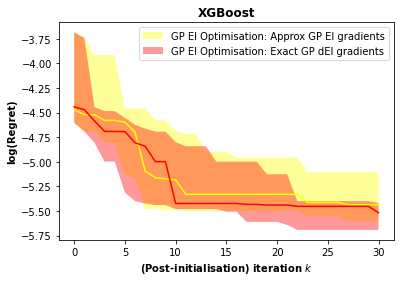

In [113]:
### Visualise!

title = obj_func

plt.figure()

plt.plot(median_approx, color = 'Yellow')
plt.plot(median_exact, color = 'Red')

xstar = np.arange(0, max_iter+1, step=1)
plt.fill_between(xstar, lower_approx, upper_approx, facecolor = 'Yellow', alpha=0.4, label='GP EI Optimisation: Approx GP EI gradients')
plt.fill_between(xstar, lower_exact, upper_exact, facecolor = 'Red', alpha=0.4, label='GP EI Optimisation: Exact GP dEI gradients')

plt.title(title, weight = 'bold')
plt.xlabel('(Post-initialisation) iteration $\it{k}$', weight = 'bold') # x-axis label
plt.ylabel('log(Regret)', weight = 'bold') # y-axis label
plt.legend(loc=0) # add plot legend

plt.show() #visualise


In [107]:
rmse_approx = [rmse_approx_1,
rmse_approx_2,
rmse_approx_3,
rmse_approx_4,
rmse_approx_5,
rmse_approx_6,
rmse_approx_7,
rmse_approx_8,
rmse_approx_9,
rmse_approx_10,
rmse_approx_11,
rmse_approx_12,
rmse_approx_13,
rmse_approx_14,
rmse_approx_15,
rmse_approx_16,
rmse_approx_17,
rmse_approx_18,
rmse_approx_19,
rmse_approx_20]

np.mean(rmse_approx)

0.06197546458738397

In [108]:
rmse_exact = [rmse_exact_1,
rmse_exact_2,
rmse_exact_3,
rmse_exact_4,
rmse_exact_5,
rmse_exact_6,
rmse_exact_7,
rmse_exact_8,
rmse_exact_9,
rmse_exact_10,
rmse_exact_11,
rmse_exact_12,
rmse_exact_13,
rmse_exact_14,
rmse_exact_15,
rmse_exact_16,
rmse_exact_17,
rmse_exact_18,
rmse_exact_19,
rmse_exact_20]

np.mean(rmse_exact)

0.0599174019712835

In [109]:
min_rmse_approx = min_max_array(rmse_approx)
min_rmse_approx, len(min_rmse_approx)

([0.05968536249948937,
  0.05586505233282634,
  0.05586505233282634,
  0.05586505233282634,
  0.05586505233282634,
  0.05586505233282634,
  0.05586505233282634,
  0.05406726910923368,
  0.05406726910923368,
  0.05406726910923368,
  0.05406726910923368,
  0.05406726910923368,
  0.05406726910923368,
  0.05406726910923368,
  0.05406726910923368,
  0.05332813702243776,
  0.05332813702243776,
  0.05332813702243776,
  0.05332813702243776,
  0.05332813702243776],
 20)

In [110]:
min_rmse_exact = min_max_array(rmse_exact)
min_rmse_exact, len(min_rmse_exact)

([0.061890672951001424,
  0.05547038156657307,
  0.05536588383073458,
  0.05536588383073458,
  0.05536588383073458,
  0.05536588383073458,
  0.05536588383073458,
  0.05536588383073458,
  0.05536588383073458,
  0.05536588383073458,
  0.05536588383073458,
  0.05536588383073458,
  0.05536588383073458,
  0.05536588383073458,
  0.05536588383073458,
  0.05536588383073458,
  0.05536588383073458,
  0.05536588383073458,
  0.05173953573857795,
  0.05173953573857795],
 20)

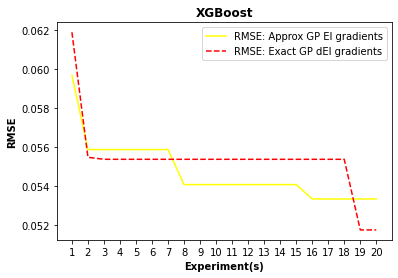

In [111]:
### Visualise!

title = obj_func
plt.figure()

plt.plot(min_rmse_approx, color = 'Yellow', label='RMSE: Approx GP EI gradients')
plt.plot(min_rmse_exact, color = 'Red', ls = '--', label='RMSE: Exact GP dEI gradients')

plt.title(title, weight = 'bold', family = 'Arial')
plt.xlabel('Experiment(s)', weight = 'bold', family = 'Arial') # x-axis label
plt.ylabel('RMSE', weight = 'bold', family = 'Arial') # y-axis label
plt.legend(loc=0) # add plot legend

### Make the x-ticks integers, not floats:
count = len(min_rmse_approx)
plt.xticks(np.arange(count), np.arange(1, count + 1))
plt.show() #visualise!
